# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Predicting Hospital Readmission Rates for Diabetes
## CS109a: Introduction to Data Science



**Harvard University**<br/>
**Fall 2023**<br/>
**Team members**: Karim Gowani, Ryan McGillicuddy, Yaseen Mohmand, Steven Worthington


<hr style="height:2pt">

# Introduction

## i. About This Notebook

This notebook represents a summary of a series of exploratory and model-based analysis, wherein we attempt various approaches to classify diabetes patients into early hospital readmittance (within 30 days) and later hospital readmittance (more than 30 days) classes. For an overview of the analytical sections of this notebook, please see the [Notebook Contents](#Notebook-Contents) index listed below this Introduction.

### i.i. A note about supporting notebooks

The code and results reported in this notebook are only a summary of the work completed for this project - they represent the final form of our analyses. Supplemental notebooks containing auxillary EDA, data cleaning, and model exploration illustrated in this report can be found in the **`notebooks/`** directory of the **[GitHub project repository](https://github.com/stevenworthington/cs109a_final_project)**. The notebooks in this repository are not curated or designed to be run in any particular order to reproduce the results shown in the final report. They just show the extra work and experiments we have tried that are not shown in the final report.

### i.ii. Presentation of research findings

You can view our presentation of the highlights of this project on the following [YouTube link](https://youtu.be/v0zB3Jhh37U).


## ii. Research Question

After initial exploration and cleaning of the data, we have focused our efforts on the following research question:

- **What risk factors drive early readmittance (within 30 days of discharge) to hospital for diabetes patients?**

## iii. Summary of Major Findings

1. After experimenting with several different classifiers, we were able to achieve an AUC-ROC of 71.9% on the test set using an extreme gradient boosting model. This model exhibited the least amount of overfitting out of our candidate models (78.5% AUC-ROC on the training set) and was well-calibrated (4.94% predicted early readmittance vs. 4.96% actual).

2. Clinicians should prioritize interventions or follow-ups for the 34% of patients predicted to have a higher chance than average (5%) of being readmitted early.

3. Top features associated with risk of being readmitted early include demographic factors (age and race), medical history (number of previous inpatient visits, number of current conditions, etc.), as well as where the patient is discharged to (home, nursing home, etc.). 

4. Patients discharged to Skilled Nursing Facilities (SNF) seem to be at high risk of being readmitted early. Follow-ups should be pursued here as to why SNF is associated with high readmission risk. Is it because SNFs are not taking good care of patients who go there? Is it because patients who are discharged to SNFs are so ill to begin with? Are there certain SNFs that are under-performers?
   
6. While our model suggests that African American diabetes patients seem generally less likely to be readmitted to hospital early, this may be an artifact of the model being poorly calibrated for them compared with Caucasians. This has important health care repercussions, as if African American readmittance rates are under-predicted they may be deprioritized for health interventions, relative to patients of other races. This issue is likely caused by training the model on a disproportionately smaller number of examples with African Americans.

<a name="Notebook-Contents"></a>
# Notebook Contents

[Introduction](#Introduction)

[Setup](#Setup)

**[1. Data Source and Composition](#1.-Data-Source-and-Composition)**

- [1.1. Data Source and Structure](#1.1.-Data-Source-and-Structure)

- [1.2. Data Granularity and Substantive Context](#1.2.-Data-Granularity-and-Substantive-Context)

- [1.3. Class Imbalance](#1.3.-Class-Imbalance)
 
- [1.4. Missing Observations](#1.4.-Missing-Observations)
  
**[2. Exploratory Data Analysis and Preprocessing](#2.-Exploratory-Data-Analysis-and-Preprocessing)**

- [2.1. EDA of Raw Data](#2.1.-EDA-of-Raw-Data)

- [2.2. Data Preprocessing](#2.2.-Data-Preprocessing)

- [2.3. Data Dictionary](#2.3.-Data-Dictionary)

- [2.4. Data Partitioning](#2.4.-Data-Partitioning)
 
- [2.5. EDA of Cleaned Training Data](#2.5.-EDA-of-Cleaned-Training-Data)

- [2.6. Summary of EDA Key Findings](#2.6.-Summary-of-EDA-Key-Findings)

**[3. Research Questions](#3.-Research-Questions)**

**[4. Modeling Pipeline and Training](#4.-Modeling-Pipeline-and-Training)**

- [4.1. Feature Engineering](#4.1.-Feature-Engineering)

- [4.2. Candidate Models and Performance Assessment](#4.2.-Candidate-Models-and-Performance-Assessment)

- [4.3. Base Model](#4.3.-Base-Model)

- [4.4. Logistic Regression Models](#4.4.-Logistic-Regression-Models)

- [4.5. K-Nearest Neighbors Models](#4.5.-K-Nearest-Neighbors-Models)

- [4.6. Random Forest Models](#4.6.-Random-Forest-Models)
 
- [4.7. Gradient Boosting Models](#4.7.-Gradient-Boosting-Models)
   
- [4.8. Extreme Gradient Boosting Models](#4.8.-Extreme-Gradient-Boosting-Models)
     
- [4.9. Stacked Ensemble Model](#4.9.-Stacked-Ensemble-Model)

**[5. Model Selection and Interpretation](#5.-Model-Selection-and-Interpretation)**

- [5.1. Model Selection](#5.1.-Model-Selection)

- [5.2. Best Model Interpretation](#5.2.-Best-Model-Interpretation)

**[6. Conclusions](#6.-Conclusions)**

**[7. Limitations and Future Work](#7.-Limitations-and-Future-Work)**

- [7.1. Limitations](#7.1.-Limitations)

- [7.2. Future Work](#7.2.-Future-Work)

**[8. References](#8.-References)**

# Setup

[Return to top](#Notebook-Contents)

This section includes code for general setup:
1. Installing the necessary packages needed for data preparation, modeling, and visualization
2. Setting a pseudo-random number seed for reproducibility

### Install Modules

In [1]:
# basic modules
import os
import time
import random as rn
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# plotting style
plt.style.use('seaborn-v0_8-notebook')
sns.set_style('white')
#sns.set_style('darkgrid')

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

# preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
 
# models
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier

# metrics & utilities 
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.metrics import average_precision_score, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import resample, class_weight

# variable importance
import shap
from shap.explainers import Tree
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import permutation_importance

# feature selection
# from boruta import BorutaPy

# warnings
import warnings
warnings.filterwarnings("ignore")

# user defined functions
import utility_functions as utl

### Set RNG seed

In [2]:
# ensure replicable results
SEED = 109
np.random.seed(SEED)
rn.seed(SEED)

<a name="1.-Data-Source-and-Composition"></a>
# 1. Data Source and Composition

[Return to top](#Notebook-Contents)

In this section, we introduce the dataset we have selected and describe its structure and substantive context.

<a name="1.1.-Data-Source-and-Structure"></a>
## 1.1 Data Source and Structure

[Return to top](#Notebook-Contents)

Our dataset is from the UC Irvine ML Repository and involves patient records of those diagnosed with diabetes from 1999 through 2008 at 130 US hospitals. A peer-reviewed paper is associated with the dataset (<https://www.hindawi.com/journals/bmri/2014/781670/>), which we have read. We have downloaded the dataset and examined it. It has ~102K records, a 3-level target variable, and 47 features, the majority of which are categorical. Each observation in the dataset is a 'encounter' between a patient and a hospital. Some patients have multiple encounters (i.e., multiple rows) while others only have a single encounter. During the course of our data preprocessing, we will aggregate these data to the patient-level. The available features encompass demographic variables, hospital-visit variables, and medication variables. The target is a 3-level categorical variable, which we will collapse to be binary during preprocessing: whether a patient was readmitted to hospital within 30 days of being discharged or not. The table below provides a comprehensive description of the raw encounter-level data.

| Feature name         | Type    | Description and values                                                                                             | % missing |
| :------------------- | :------ | :----------------------------------------------------------------------------------------------------------------- | :-------: |
| Encounter ID         | Numeric | Unique identifier of an encounter                                                                                   |    0    |
| Patient number       | Numeric | Unique identifier of a patient                                                                                      |    0    |
| Race                 | Nominal | Values: Caucasian, Asian, African American, Hispanic, and other                                                    |    2    |
| Gender               | Nominal | Values: male, female, and unknown/invalid                                                                          |    0    |
| Age                  | Nominal | Grouped in 10-year intervals                                                                                       |    0    |
| Weight               | Numeric | Weight in pounds                                                                                                   |   97    |
| Admission type       | Nominal | Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available |    0    |
| Discharge disposition| Nominal | Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available  |    0    |
| Admission source     | Nominal | Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room, and transfer from a hospital |    0    |
| Time in hospital     | Numeric | Integer number of days between admission and discharge                                                            |    0    |
| Payer code           | Nominal | Integer identifier corresponding to 23 distinct values, for example, Blue Cross Blue Shield, Medicare, and self-pay |   52    |
| Medical specialty    | Nominal | Integer identifer of a specialty of the admitting physician, corresponding to 84 distinct values, for example, cardiology, internal medicine, family general practice, and surgeon |   53    |
| Number of lab procedures | Numeric | Number of lab tests performed during the encounter                                                              |    0    |
| Number of procedures | Numeric | Number of procedures (other than lab tests) performed during the encounter                                        |    0    |
| Number of medications| Numeric | Number of distinct generic medications administered during the encounter                                               |    0   |
| Number of outpatient visits | Numeric | Number of outpatient visits of the patient in the year preceding the encounter                                  |    0    |
| Number of emergency visits | Numeric | Number of emergency visits of the patient in the year preceding the encounter                                   |    0    |
| Number of inpatient visits | Numeric | Number of inpatient visits of the patient in the year preceding the encounter                                   |    0    |
| Diagnosis 1          | Nominal | Primary diagnosis (coded as the first three digits of ICD9; 848 distinct values                                   |    0    |
| Diagnosis 2          | Nominal | Secondary diagnosis (coded as first three digits of ICD9; 923 distinct values                                     |    0    |
| Diagnosis 3          | Nominal | Additional secondary diagnosis (coded as first three digits of ICD9; 954 distinct values                          |    1    |
| Number of diagnoses  | Numeric | Number of diagnoses entered to the system                                                                        |    0    |
| Glucose serum test result | Nominal | Indicates the range of the result or if the test was not taken. Values: ">200", ">300", "normal", and "none" if not measured |    0    |
| A1c test result      | Nominal | Indicates the range of the result or if the test was not taken. Values: ">8" if the result was greater than 8%, ">7" if the result was greater than 7% but less than 8%, "normal" if the result was less than 7%, and "none" if not measured |    0    |
| Change of medications | Nominal | Indicates if there was a change in diabetic medications (either dosage or generic name). Values: "change" and "no change" |    0    |
| Diabetes medications | Nominal | Indicates if there was any diabetic medication prescribed. Values: "yes" and "no"                                 |    0    |
| 24 features for medications | Nominal | The feature indicates whether the drug was prescribed or there was a change in the dosage. Values: "up" if the dosage was increased during the encounter, "down" if the dosage was decreased, "steady" if the dosage did not change, and "no" if the drug was not prescribed |    0    |
| Readmitted  | Nominal | Days to inpatient readmission. Values: "<30" if the patient was readmitted in less than 30 days, ">30" if the patient was readmitted in more than 30 days, and "No" for no record of readmission   |   0    |

<a name="1.2.-Data-Granularity-and-Substantive-Context"></a>
## 1.2 Data Granularity and Substantive Context

[Return to top](#Notebook-Contents)

In a clinical setting, doctors and medical staff would like to answer the question, "given information from the current and previous hospitalizations, how likely is it for this patient to be readmitted to hospital early (within 30 days)?". This question is inherently at the patient-level, but each record in the dataset is at the level of an 'encounter', which represents a patient hospitalization event (rather than an outpatient visit). A subset of 16.5% of patients have multiple encounters.

A patient-level perspective is more likely to be of benefit to clinicians, since answering the above question will help medical personnel prioritize follow-ups and interventions through the creation of patient risk profiles, which can identify patients at the highest risk level for early hospital readmittance. This information is actionable and can be used to mitigate negative health outcomes for these patients as well as increased costs for the hospital and insurance carrier. We will therefore aggregate data from the encounter-level to the patient-level.

For those patients with multiple encounters, however, features that vary at the encounter-level contain important information that we do not wish to discard. For example, if a patient was readmitted early relative to the immediately preceding encounter, it is perhaps more likely that the patient will be readmitted to hospital early again after the current encounter. Therefore, our strategy will be to select only the final encounter for these patients and create several new derived features that encapsulate the history of their previous encounters. Such features will include, but are not limited to, the number of previous inpatient encounters, whether the last encounter resulted in early readmission, and whether the patient ever had a high value of A1c.

In following this approach, we will have to make a (reasonable) assumption that encounters for each patient are in temporal order in the dataset because no explicit date information is provided.

<a name="1.3.-Class-Imbalance"></a>
## 1.3 Class Imbalance

[Return to top](#Notebook-Contents)

At the encounter-level, about 11% of observations belong to the positive class (readmitted within 30 days), however, once aggregated to the patient-level this decreases to 4.96%. Google describes this as ['moderate' imbalance](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data), with its definition of 'extreme' being < 1% minority class. While our primary model performance metric (AUC-ROC) is robust to class imbalance, we will still try to address this issue in several ways. We will use stratified sampling in train/test splits, and we will attempt the standard techniques of under- and over-sampling, as well as use of class weights built into the different machine learning models of interest.

<a name="1.4.-Missing-Observations"></a>
## 1.4 Missing Observations

[Return to top](#Notebook-Contents)

There are 7 (out of 47) features that contain missing values:
- `Weight` is missing ~97% of its values, so this column can be safely dropped; no other numerical column has missing values.
- `Medical specialty` is missing ~49% of its values, but may be relevant to the classification task, so we will keep it and fill the missing values with 'unknown'.
- `Payer code` (insurance carrier) is missing ~40% of the values, but because it does not seem to be relevant to the target, it is also a candidate for being eliminated.

The remaining four columns have less than 3% values missing so they can be managed. They are all categorical, including race and diagnosis codes. As is common for categorical variables, we will fill the missing values with 'unknown'.

We note that two other columns, `Max_glu_serum` and `A1C result`, appear to have many missing observations with values entered as `NaN` in the raw data. However, according to the [paper associated with the data](<https://www.hindawi.com/journals/bmri/2014/781670/>), these values do in fact contain clinically relevant information: they denote the situation where a clinician decided not to run the relevant blood test on the patient during that encounter. This means these values represent evidence for the absence of a clinical need for the given test, rather than absence of evidence for the test being given. Both `Max_glu_serum` and `A1C result` can therefore be considered to have no missing values.

<a name="2.-Exploratory-Data-Analysis-and-Preprocessing"></a>
# 2. Exploratory Data Analysis and Preprocessing

[Return to top](#Notebook-Contents)

In this section, we load our raw data, perform some initial exploratory data analysis to assess what preprocessing steps are necessary, perform those steps, partition the data into training and testing sets, perform additional exploratory data analysis on the cleaned training data, and present a summary of our findings.

<a name="2.1.-EDA-of-Raw-Data"></a>
## 2.1 EDA of Raw Data

[Return to top](#Notebook-Contents)

We will explore the raw encounter-level data using visualizations and tables.

### Raw Diabetes Data

In [3]:
# load the encounter-level data
df_encounters = pd.read_csv('../../data/diabetic_data.csv', 
                            na_values='?',
                            low_memory=False # silence the mixed dtypes warning
                           )
df_encounters.head()

encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)    NaN   
1        149190     55629189        Caucasian  Female  [10-20)    NaN   
2         64410     86047875  AfricanAmerican  Female  [20-30)    NaN   
3        500364     82442376        Caucasian    Male  [30-40)    NaN   
4         16680     42519267        Caucasian    Male  [40-50)    NaN   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital payer_code         medical_specialty  num_lab_procedures  \
0                 1        NaN  Pediatrics-Endocrinology                  41   
1                 3        NaN                       NaN                  59   
2                 2        NaN                       NaN                  11   
3                 2        NaN                       NaN                  44   
4                 1        NaN                       NaN                  51   

   num_procedures  num_medications  number_outpatient  number_emergency  \
0               0                1                  0                 0   
1               0               18                  0                 0   
2               5               13                  2                 0   
3               1               16                  0                 0   
4               0                8                  0                 0   

   number_inpatient  diag_1  diag_2 diag_3  number_diagnoses max_glu_serum  \
0                 0  250.83     NaN    NaN                 1           NaN   
1                 0     276  250.01    255                 9           NaN   
2                 1     648     250    V27                 6           NaN   
3                 0       8  250.43    403                 7           NaN   
4                 0     197     157    250                 5           NaN   

  A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride  \
0       NaN        No          No          No             No          No   
1       NaN        No          No          No             No          No   
2       NaN        No          No          No             No          No   
3       NaN        No          No          No             No          No   
4       NaN        No          No          No             No          No   

  acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone  \
0            No        No        No          No           No            No   
1            No        No        No          No           No            No   
2            No    Steady        No          No           No            No   
3            No        No        No          No           No            No   
4            No    Steady        No          No           No            No   

  acarbose miglitol troglitazone tolazamide examide citoglipton insulin  \
0       No       No           No         No      No          No      No   
1       No       No           No         No      No          No      Up   
2       No       No           No         No      No          No      No   
3       No       No           No         No      No          No      Up   
4       No       No           No         No      No          No  Steady   

  glyburide-metformin glipizide-metformin glimepiride-pioglitazone  \
0                  No                  No                       No   
1                  No                  No                       No   
2                  No                  No                       No   
3                  No                  No                       No   
4        

### Data types

In [4]:
# dtypes and columns counts
data_types= df_encounters.dtypes
type_counts = data_types.value_counts()
print(type_counts)

object    37
int64     13
Name: count, dtype: int64


In [5]:
# dtype for each column
data_types

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

### Summary Statistics

In [6]:
# summary stats (after removing ID columns)
df_summary = df_encounters[[col for col in df_encounters.columns if not (col.endswith('_id') or col.endswith('_nbr'))]]
df_summary.describe().round(1)

time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
count          101766.0            101766.0        101766.0         101766.0   
mean                4.4                43.1             1.3             16.0   
std                 3.0                19.7             1.7              8.1   
min                 1.0                 1.0             0.0              1.0   
25%                 2.0                31.0             0.0             10.0   
50%                 4.0                44.0             1.0             15.0   
75%                 6.0                57.0             2.0             20.0   
max                14.0               132.0             6.0             81.0   

       number_outpatient  number_emergency  number_inpatient  number_diagnoses  
count           101766.0          101766.0          101766.0          101766.0  
mean                 0.4               0.2               0.6               7.4  
std                  1.3               0.9               1.3               1.9  
min                  0.0               0.0               0.0               1.0  
25%                  0.0               0.0               0.0               6.0  
50%                  0.0               0.0               0.0               8.0  
75%                  0.0               0.0               1.0               9.0  
max                 42.0              76.0              21.0              16.0

### Missing data

We can see that some of the columns appear to have a lot of missing data such as `Weight`, `Max_glu_serum`, `A1C result`, `Medical specialty`, and `Payer code`. However, for `Max_glu_serum` and `A1C result` the values entered as `NaN` do in fact contain clinically relevant information: according to the [paper associated with the data](<https://www.hindawi.com/journals/bmri/2014/781670/>), they denote the situation where a clinician decided not to run the relevant test on the patient in that encounter. This means these values represent evidence for the absence of a clinical need for the given test, rather than absence of evidence for the test being given. Both `Max_glu_serum` and `A1C result` therefore have no missing values. For the other columns with missing observations, we will treat them in the subsequent cells.

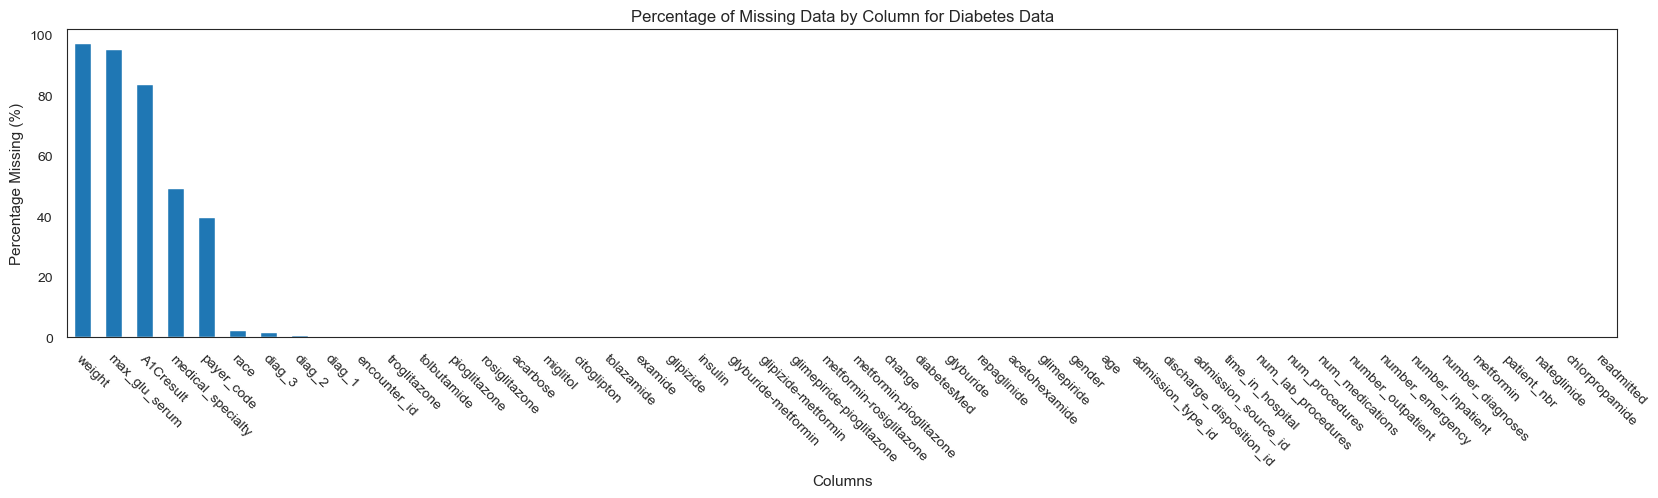

In [7]:
# Calculate missing data percentages
missing_data_percentage = (df_encounters.isnull().sum() / len(df_encounters)) * 100
# Sort the values for better visualization
missing_data_percentage = missing_data_percentage.sort_values(ascending=False)

# Create a figure with specified size
plt.figure(figsize=(20, 4))
# Plot the data as a vertical bar plot
missing_data_percentage.plot(kind='bar')
plt.title('Percentage of Missing Data by Column for Diabetes Data')
plt.xticks(rotation=-45, ha="left", rotation_mode="anchor") 
plt.ylabel('Percentage Missing (%)')
plt.xlabel('Columns');

In [8]:
# missing values table
missing_values = df_encounters.isnull().sum()
missing_percentage = (100 * df_encounters.isnull().sum() / len(df_encounters))
missing_values_table = pd.concat([missing_values, missing_percentage], axis=1)
    
missing_values_table = missing_values_table.rename(
  columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
missing_values_table = missing_values_table[
    missing_values_table.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
print(f"The diabetes data have " + str(df_encounters.shape[1]) + " columns.\n"      
    "There are " + str(missing_values_table.shape[0]) +
    " columns that have missing values.\n")

display(missing_values_table)

The diabetes data have 50 columns.
There are 9 columns that have missing values.



Missing Values  % of Total Values
weight                      98569               96.9
max_glu_serum               96420               94.7
A1Cresult                   84748               83.3
medical_specialty           49949               49.1
payer_code                  40256               39.6
race                         2273                2.2
diag_3                       1423                1.4
diag_2                        358                0.4
diag_1                         21                0.0

### Numeric Data

#### Distribution plots

1. Most of our other variable distribution is skewed either to the right or left, which is expected because for example we would not expect a lot of patients to have multiple emergency visits, we would expect the majority to have 0 emergencies and then a long tail.

2. Some of the numeric variables we see more variablility than others. The variables with more variablility might have more predictive power.

3. We can also see that different variables have very different scales, which will make it important for us to scale the normalize/ transform the data if we want to use predictive techniques like k-NN.


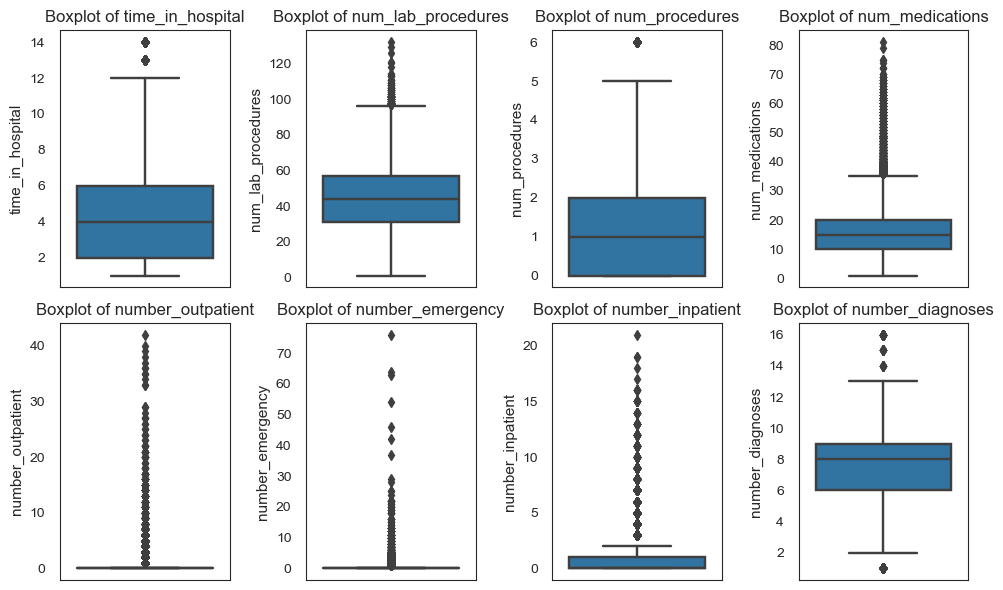

In [9]:
# boxplots for each numeric column
box_vars = ['time_in_hospital', 'num_lab_procedures', 
            'num_procedures', 'num_medications', 'number_outpatient',
            'number_emergency', 'number_inpatient', 'number_diagnoses']

fig, axes = plt.subplots(2, 4, figsize=(10, 6))
for ax, column in zip(axes.flatten(), box_vars):
    sns.boxplot(y=column, data=df_encounters, ax=ax)
    ax.set_title(f'Boxplot of {column}')
plt.tight_layout();

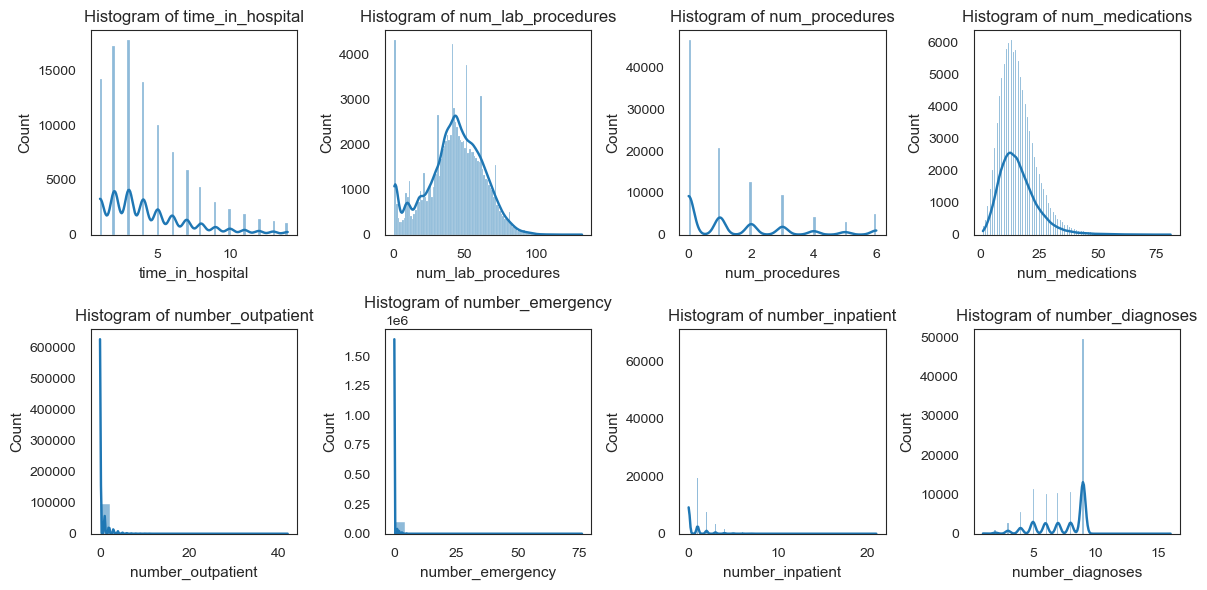

In [10]:
box_vars = ['time_in_hospital', 'num_lab_procedures', 
            'num_procedures', 'num_medications', 'number_outpatient',
            'number_emergency', 'number_inpatient', 'number_diagnoses']

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for ax, column in zip(axes.flatten(), box_vars):
    sns.histplot(df_encounters[column], kde=True, ax=ax)  # using seaborn's histplot
    ax.set_title(f'Histogram of {column}')
plt.tight_layout();

#### Correlation Plots

Our correlation analysis reveals moderate associations among several variables within the dataset. Notably, no pair of variables exhibits an extremely high correlation exceeding the 90% threshold.

Key observations of notable correlations include:

1. A predictable inverse relationship between 'gender_male' and 'gender_female,' as they represent binary and mutually exclusive categories.
2. A discernible correlation between 'race_African American' and 'race_Caucasian,' which likely arises from the demographic representation in the dataset, where Caucasians form the majority and African Americans are the second-largest demographic group.
3. There is an observable correlation between the 'not_readmitted' and 'readmitted_within_30_days' categories. This pattern is attributable to the predominance of the 'not_readmitted' group contrasted with the sizable proportion of cases readmitted within a 30-day period.

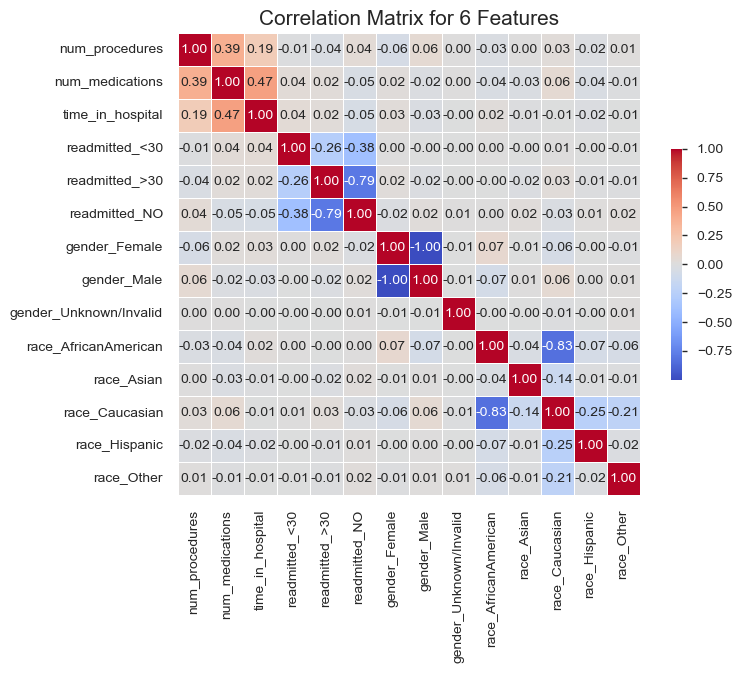

In [11]:
# correlation visualization
cor_vars = ['readmitted', 'gender', 'race', 'num_procedures', 
            'num_medications', 'time_in_hospital']
corr = pd.get_dummies(df_encounters[cor_vars]).corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix for 6 Features', fontsize=15);

### Class Imbalance

Our analysis indicates that the target variable, 'readmission within 30 days,' is underrepresented, comprising just 11.15% of the cases, thus confirming a class imbalance in the dataset. This imbalance is a critical factor to consider as it can influence model training and the interpretability of performance metrics.

During the data preparation phase, particularly for train-test splitting, it is essential to maintain a stratified sampling approach. This will ensure that both the training and testing sets reflect the original proportion of the 30-day readmission cases.

In terms of model evaluation, reliance on accuracy as the sole performance metric may be inadequate and potentially misleading due to the skewed class distribution. Alternative metrics such as precision, recall, the F1 score, and the area under the Receiver Operating Characteristic (ROC) curve will be more informative. These metrics can provide a more nuanced view of the model's ability to correctly predict the minority class while distinguishing it from the majority class.

In [12]:
round(df_encounters['readmitted'].value_counts()/(len(df_encounters['readmitted']))*100, 4)

readmitted
NO     53.912
>30    34.928
<30    11.160
Name: count, dtype: float64

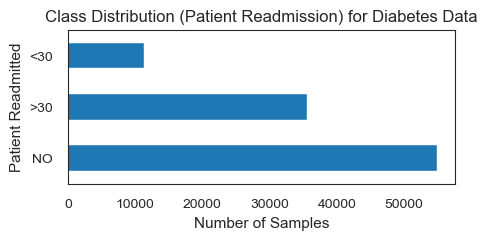

In [13]:
# visualize class imbalance
plt.figure(figsize=(5, 2))
df_encounters['readmitted'].value_counts().plot(kind='barh')
plt.title('Class Distribution (Patient Readmission) for Diabetes Data')
plt.ylabel('Patient Readmitted')
plt.xlabel('Number of Samples');

### Frequency of patient visits

The total number of patients with multiple encounters is 16773. this is 16.48 percent of the data. Majority of the patients only visited the hospital once.

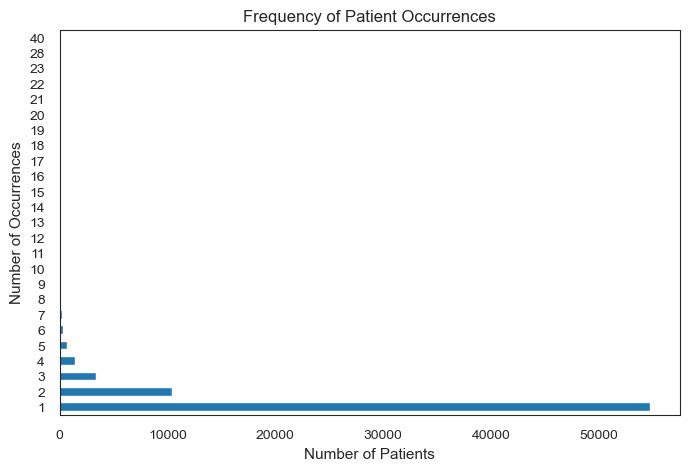

In [14]:
# calculate the frequency of each 'patient_id'
id_counts = df_encounters['patient_nbr'].value_counts()
# count how many 'patient_id's occur for each frequency
frequency_counts = id_counts.value_counts().sort_index()

plt.figure(figsize=(8,5))
frequency_counts.plot(kind='barh')
plt.ylabel('Number of Occurrences')
plt.xlabel('Number of Patients')
plt.title('Frequency of Patient Occurrences');

In [15]:
# group by 'patient_id' and filter out those with only one encounter
multiple_encounters = df_encounters.groupby('patient_nbr').filter(lambda x: len(x) > 1)
print(f"Total number of patients with multple encounters: {multiple_encounters['patient_nbr'].nunique()}")

Total number of patients with multple encounters: 16773


Total number of patients with different outcomes across encounters: 2766



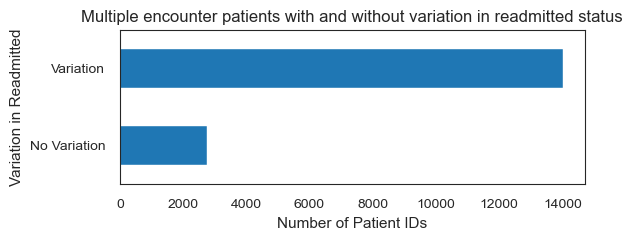

In [16]:
# check if 'readmitted' values vary within each group
def check_variation(df):
    return df['readmitted'].nunique() > 1

variation = multiple_encounters.groupby('patient_nbr').apply(check_variation)

variation_counts = variation.astype(int).value_counts().sort_index()

print(f"Total number of patients with different outcomes across encounters: {variation.value_counts()[1]}\n")

plt.figure(figsize=(6,2))
variation_counts.plot(kind='barh')
plt.xlabel('Number of Patient IDs')
plt.ylabel('Variation in Readmitted')
plt.title('Multiple encounter patients with and without variation in readmitted status')
plt.yticks(ticks=[0, 1], labels=['No Variation', 'Variation']);

In [17]:
variation = multiple_encounters.groupby('patient_nbr')  #.apply(check_variation)
display(variation);

### Categorical Data

#### Age Distribution

The patient age distribution within our dataset skews older, with the majority of patients being over 50 years of age. Age categories under 50 are noticeably less populated, suggesting sparsity in younger demographics.

To streamline our analysis and potentially enhance model performance, we could consider aggregating these sparser younger age groups into a single category during preprocessing. This consolidation could reduce dimensionality and simplify patterns within the data, making it more manageable for subsequent analysis.

In [18]:
# age
df_encounters['age'].value_counts(normalize=True, dropna=False) * 100

age
[70-80)     25.616
[60-70)     22.093
[50-60)     16.957
[80-90)     16.899
[40-50)      9.517
[30-40)      3.709
[90-100)     2.745
[20-30)      1.628
[10-20)      0.679
[0-10)       0.158
Name: proportion, dtype: float64

#### Gender Distribution

Both genders are equally represented in the dataset with slightly more females than males

In [19]:
# gender
df_encounters['gender'].value_counts(normalize=True, dropna=False) * 100

gender
Female             53.759
Male               46.238
Unknown/Invalid     0.003
Name: proportion, dtype: float64

#### Race Distribution

Our dataset's demographic breakdown is predominantly Caucasian, followed by African American as the second-largest racial group. This distribution aligns with the correlations observed earlier, reflecting the demographic representation within the data.

In [20]:
# race
df_encounters['race'].value_counts(normalize=True, dropna=False) * 100

race
Caucasian          74.778
AfricanAmerican    18.877
NaN                 2.234
Hispanic            2.002
Other               1.480
Asian               0.630
Name: proportion, dtype: float64

#### Medical Specialty

Nearly half of the 'medical_specialty' data is missing, yet its relevance for readmission insights means it's worth keeping. Internal Medicine is the predominant specialty, which is typical as it's often a first step before patients move to sub-specialties. Emergency/Trauma and Family/General Practice are also common, reflecting standard hospital intake patterns. Sub-specialties, while less frequent, could be critical in predicting 30-day readmissions and should not be overlooked in predictive modeling.

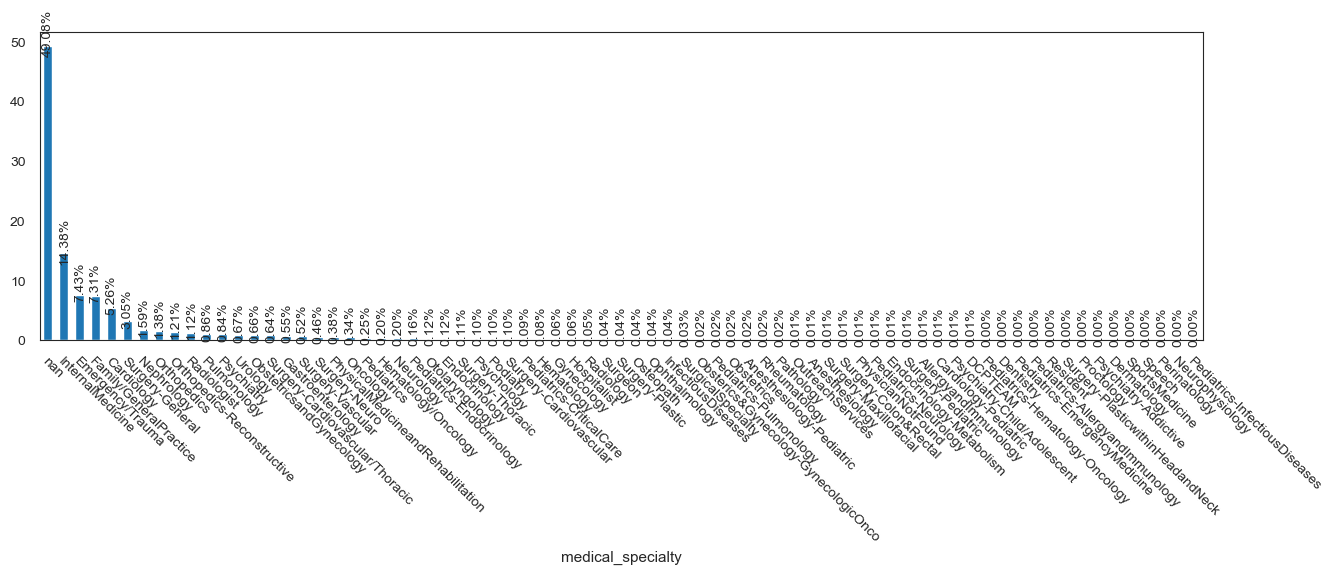

In [21]:
plt.figure(figsize=(15, 4))  # Set the figure size to make sure there's enough room for annotations

medical_speciality = df_encounters['medical_specialty'].value_counts(normalize=True, dropna=False) * 100
ax = medical_speciality.plot(kind='bar')  # Save the Axes object returned by the plot

# Annotate each bar with the percentage
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', rotation=90)
plt.xticks(rotation=-45, ha="left", rotation_mode="anchor");

<a name="2.2.-Data-Preprocessing"></a>
## 2.2 Data Preprocessing

[Return to top](#Notebook-Contents)

### Overall Strategy

Several of the categorical variables have many categories that should be collapsed to reduce dimensionality:
- At the most extreme, the first diagnosis (`diag_1`) column has 716 codes, only 23 of which represent more than 1% of the observations; similarly for the second (`diag_2`) and third (`diag_3`) diagnosis variables. In fact, these diagnosis codes should be grouped into types such as Circulatory (codes 390-459), respiratory (codes 460-519), digestive (520-579), etc.
- Admission type code has 8 categories, 3 of which make up less than 1% of observations and can be safely collapsed.
- Medical specialty has 72 categories, but only 9 represent more than 1% of the observations.
- Age buckets can be consolidated: Currently, each bucket includes only 10 years, but less than 1% of
the observations fall into age < 20 and age > 90.

Furthermore, patients who were discharged with codes such as expired, hospice, transferred to another institution as inpatient, etc. should be filtered out as these types of discharge codes are of no practical relevance for predicting the target of early readmission. Trivially, encounter ID and patient ID are mere identifiers and should not be fed into any modeling.

### Columns with Null Values

First, let's examine the number of null values for each feature.

In [22]:
df_encounters.isnull().sum().sort_values(ascending=False).head(10)

weight               98569
max_glu_serum        96420
A1Cresult            84748
medical_specialty    49949
payer_code           40256
race                  2273
diag_3                1423
diag_2                 358
diag_1                  21
encounter_id             0
dtype: int64

#### Weight and Payer Code

Weight jumps out as a feature with a vast majority of null values, so that feature will be dropped from our analysis. Payer code, a feature related to the indentity of the health insurance provider (Blue Cross Blue Shield, Medicare, etc.) is also a candidate for droppoing both due to high missingness and lower clinical relevance.

#### Max_glu_serum

Let us now examine the rest of features with `NaN` values, starting with `max_glu_serum`. Here, `NaN` actually signifies that clinicians chose not to measure the patient's glucose, which is clinically relevant, so we keep this feature.

In [23]:
df_encounters['max_glu_serum'].value_counts()

max_glu_serum
Norm    2597
>200    1485
>300    1264
Name: count, dtype: int64

We will replace the `NaN` values with `UNK` (unknown), to signify that the measurements were not taken. For later processing, we will also create a feature signifying whether the glucose serum test result is high, which we will categorize as a reading > 300.

#### A1C Result

The A1C result is one of the main predictors in the paper describing this dataset. HbA1C is a blood test that measures glycated hemoglobin, with higher values indicating a higher risk for developing diabetes. Chemically, sugar present in the bloodstream reacts with the hemoglobin, forming glycated hemoglobin, and the sugar remains bound for the remainder of the life of the hemoglobin cell, which is several months. Therefore, the A1C level represents a weighted time average of a patient's glucose level over the previous several months.

In [24]:
df_encounters['A1Cresult'].value_counts()

A1Cresult
>8      8216
Norm    4990
>7      3812
Name: count, dtype: int64

As before, `NaN` values are clinically relevant (the measurement was not taken) and we will replace those values with `UNK`. For later processing, we again create a feature signifying whether the measurement is high, which we will categorize as a reading > 8.

#### Medical Specialty

The next feature with many missing values is the medical speciality. Examining this feature, we see that there are 72 unique values of medical specialty.

In [25]:
num_spec = len(df_encounters['medical_specialty'].value_counts())
print(f'There are {num_spec} unique specialties')

There are 72 unique specialties


Of the 72 different values of medical specialty, only 9 of them have counts above 1000 in the dataset.

In [26]:
df_encounters['medical_specialty'].value_counts().head(10)

medical_specialty
InternalMedicine              14635
Emergency/Trauma               7565
Family/GeneralPractice         7440
Cardiology                     5352
Surgery-General                3099
Nephrology                     1613
Orthopedics                    1400
Orthopedics-Reconstructive     1233
Radiologist                    1140
Pulmonology                     871
Name: count, dtype: int64

Furthermore, the top 9 specialties acount for 83.90% of the non-`NaN` encounters.

In [27]:
top9_sum = sum(df_encounters['medical_specialty'].value_counts().head(9))
top9_perc = top9_sum/sum(df_encounters['medical_specialty'].value_counts())

print(f'The top 9 specialties account for {top9_sum} encounters and {top9_perc*100:.2f}% of non-NaN encounters')

The top 9 specialties account for 43477 encounters and 83.90% of non-NaN encounters


Lastly, a distribution of the medical specialty counts shows a long tail, with many medical specialties having low counts in the dataset.

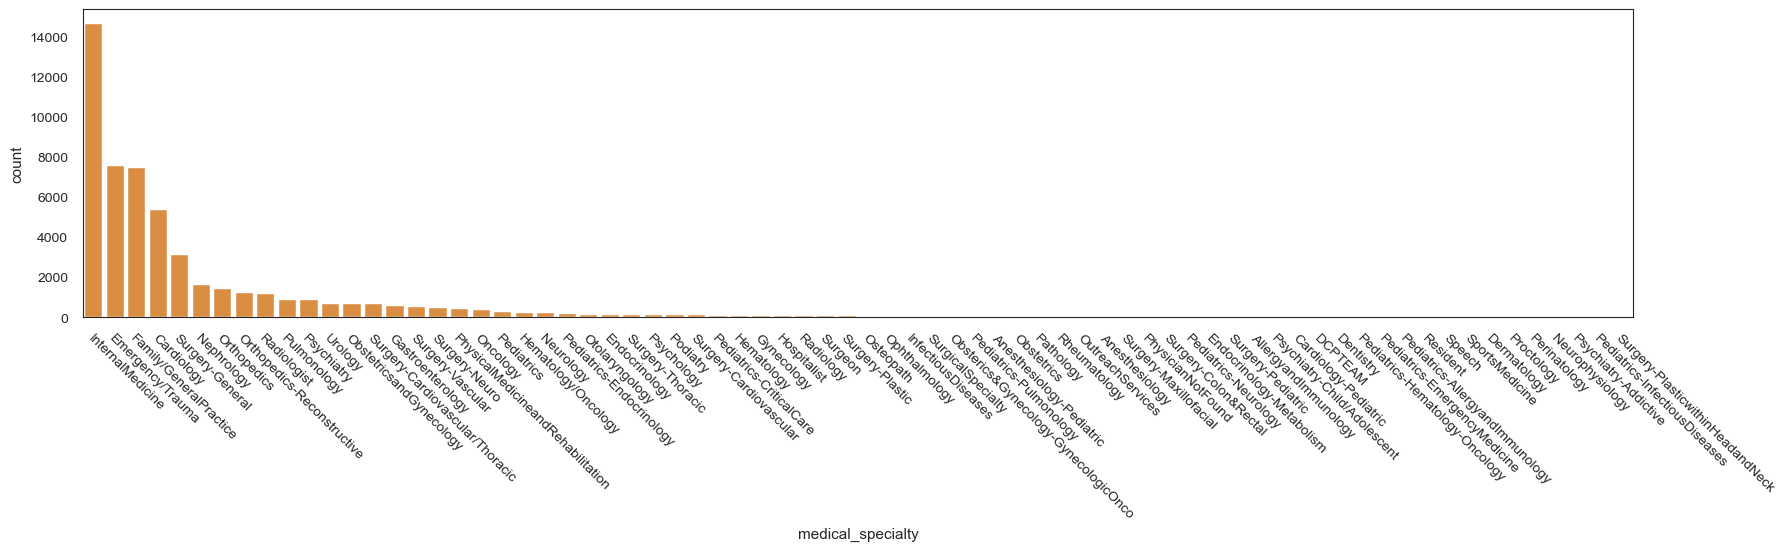

In [28]:
plt.figure(figsize=(20, 4))

ax = sns.barplot(y=df_encounters['medical_specialty'].value_counts(),
                 x=df_encounters['medical_specialty'].value_counts().index, 
                 color='#f28e2b')

ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha="left", rotation_mode="anchor");

To reduce the potential dimensionality of a one-hot-encoded medical specialty feature and remove medical specialty cateogries that have low counts, we group every medical speciality that has less than 1000 counts, and all NaN values of medical speciality, into a category called other. We maintain all categories of medical specialty that have counts above 1000. We also collapse the two orthopedics categories into one category, as we expect them to be medically similar.

In [29]:
frequent_specialties = df_encounters['medical_specialty'].value_counts().index[:9].values
frequent_specialties

array(['InternalMedicine', 'Emergency/Trauma', 'Family/GeneralPractice',
       'Cardiology', 'Surgery-General', 'Nephrology', 'Orthopedics',
       'Orthopedics-Reconstructive', 'Radiologist'], dtype=object)

#### Race

Only a couple thousand values of race are missing and there are only 5 categories of race.

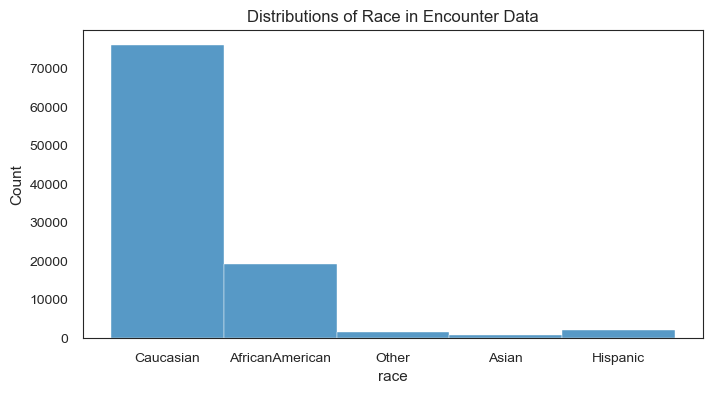

In [30]:
plt.figure(figsize=(8, 4))
sns.histplot(df_encounters['race'])
plt.title('Distributions of Race in Encounter Data');

Given that there are only 5 categories of race, we do not collapse any catgories of race. The `NaN` values are simply replaced with `UNK` for unknown.

#### Diagnoses Codes

The 3 diagnoses codes are the last remainining features with `NaN` values. We will replace these `NaN` values with `UNK` (unknown), but the diagnoses features present another challenge. This can be seen by examining the number of unique diagnoses codes used in the dataset.

In [31]:
num_diag1 = df_encounters['diag_1'].value_counts().shape[0]
num_diag2 = df_encounters['diag_2'].value_counts().shape[0]
num_diag3 = df_encounters['diag_2'].value_counts().shape[0]
max_diags = max(num_diag1, num_diag2, num_diag3)

print(f'There are {max_diags} unique diagnoses codes used in the dataset.')

There are 748 unique diagnoses codes used in the dataset.


As described in the associated paper (https://www.hindawi.com/journals/bmri/2014/781670/), the diagnoses code categories can be collapsed into smaller groups of diagnoses, namely diabetes, circulatory, respiratory, digestive, injury, muscoloskeletal, genitournary, neoplasms, and an other category which includes mental disorders, nervous system diseases, pregenancy complication diagnoses, and more. We collapse these categories based on regular expressions to identify the codes belonging to each diagnoses group. The `NaN` values are replaced with `UNK` for unknown for the `diag_1`, `diag_2`, and `diag_3` features.

In [32]:
df_new = utl.process_diag_codes(df_encounters)

In [33]:
df_new['diag_2'].value_counts()

diag_2
other              37860
neoplasms          26931
respiratory        10895
genitournary        8376
diabetes            6723
digestive           4170
injury              3159
musculoskeletal     1764
circulatory         1530
UNK                  358
Name: count, dtype: int64

We have then handled all features that have `NaN` values. Our next preprocessing steps aim to collapse superfluous categories contained in other features.

### Collapsing Categories in Features with No NaN Values

In order to reduce the dimensionality or cardinality of potentially one-hot-encoded or ordinal categorical variables, we aim to collapse the categories of features when possible. Justifications for collapsing the categories include there being a reason to believe the category will not be predictive for readmission rates, not having enough data in the category, or a strong imbalance in the category relative to other categories in the feature.

#### Age Feature

We find that only ~ 15% of the ages for encounters in this dataset are from ages below 50 years old. We also expect that the response we are trying to predict, readmission within 30 days, is going to be more prevelant in the > 50 years old category. 

In [34]:
def perc_first_n_age_groups(df, n):
    return sum(df_encounters['age'].value_counts(normalize=True).sort_index().values[:n] * 100)

perc = perc_first_n_age_groups(df_encounters, 5)

print(f'The percent of encounters in the dataset below age 50 are {perc:.2f}%')

The percent of encounters in the dataset below age 50 are 15.69%


Additionally, as can be seen from the age distribution plot below, the number of people in the highest age category (90-100 years old) is low, so we collapse that category into the 80-90 years old category.

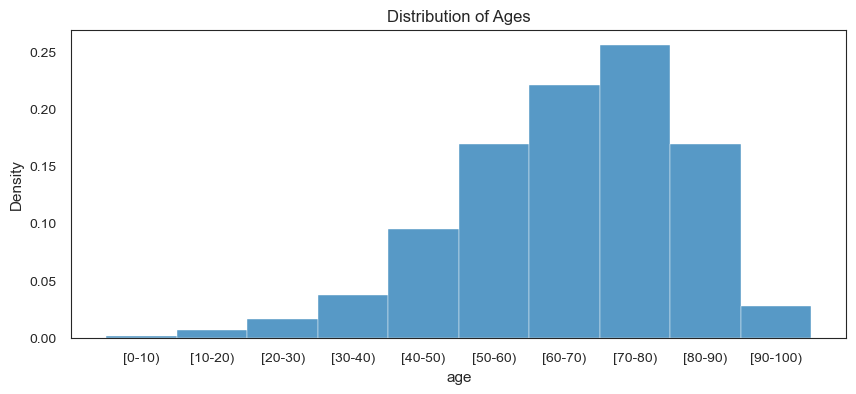

In [35]:
plt.figure(figsize=(10, 4))
sns.histplot(df_encounters['age'], stat='density')
plt.title('Distribution of Ages');

#### Discharge Disposition ID

An examination of the discharge disposition ID values shows a distribution that falls off dramatically after the 1,3 and 6 ID codes, with 85% of discharge disposition IDs belonging to 1, 3, and 6.

In [36]:
def perc_disposition_id_first_n(df, n):
    return sum(df_encounters['discharge_disposition_id'].value_counts()[:3])/sum(df_encounters['discharge_disposition_id'].value_counts())*100

n = 3
perc = perc_disposition_id_first_n(df_encounters, n)
ids = df_encounters['discharge_disposition_id'].value_counts()[:n].index.values
print(f'{perc:.2f}% of the dicharge disposition ids are {ids}.')

85.58% of the dicharge disposition ids are [1 3 6].


In [37]:
df_encounters['discharge_disposition_id'].value_counts().values

array([60234, 13954, 12902,  3691,  2128,  1993,  1642,  1184,   989,
         815,   623,   412,   399,   372,   139,   108,    63,    48,
          21,    14,    11,     8,     6,     5,     3,     2])

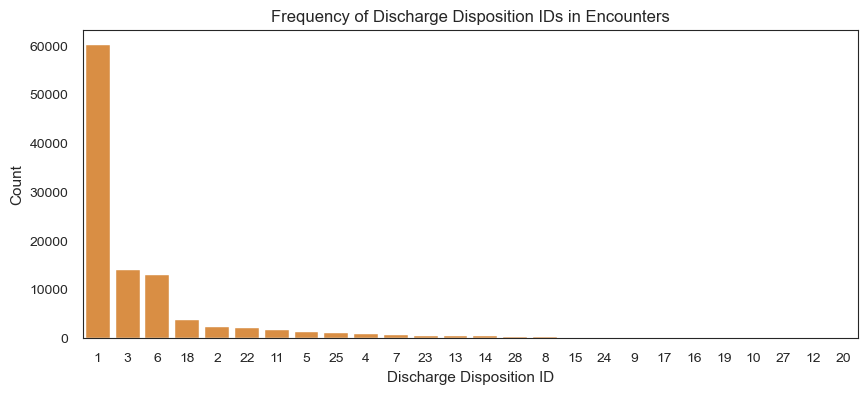

In [38]:
plt.figure(figsize=(10, 4))

ids = [str(id) for id in df_encounters['discharge_disposition_id'].value_counts().index]

sns.barplot(x=ids, y=df_encounters['discharge_disposition_id'].value_counts().values, color='#f28e2b')
plt.ylabel('Count')
plt.xlabel('Discharge Disposition ID')
plt.title('Frequency of Discharge Disposition IDs in Encounters');

Additionally, several ID codes are related to patients that are discharged to hospice or died in the encounter. We do not want to predict on these encounters because the other features will no longer be predictive for a readmission occurance. Therefore, unlike other preprocessing steps discussed so far, for these categories we will drop the encounter (observation).

#### Admission Type ID

Given the distribution of admission type ids, we keep the top 3 admission type ids and collapse all other admission type ids into an other category. We also add descriptive labels to the ids that are maintained in the dataset.

In [ ]:
# maybe generalize this with the above to print out a general % of first n features and their values
def perc_feature_first_n(df, n, feature):
    return sum(df_encounters[feature].value_counts()[:3])/sum(df_encounters[feature].value_counts())*100

n = 3
feature = 'admission_type_id'
perc = perc_feature_first_n(df_encounters, n, feature)
ids = df_encounters[feature].value_counts()[:n].index.values
print(f'{perc:.2f}% of the {feature} ids are {ids}.')

89.75% of the admission_type_id ids are [1 3 2].


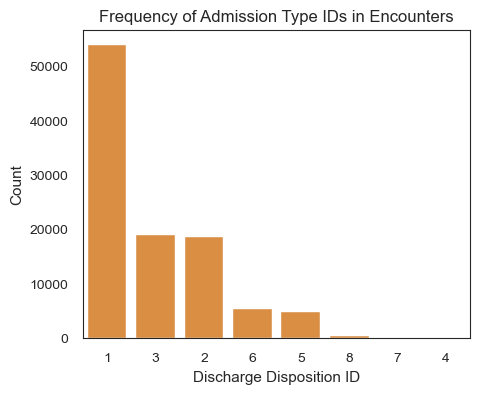

In [40]:
# plot frequency of admission type IDs
plt.figure(figsize=(5, 4))

ids = [str(id) for id in df_encounters['admission_type_id'].value_counts().index]

sns.barplot(x=ids, y=df_encounters['admission_type_id'].value_counts().values, color='#f28e2b')
plt.ylabel('Count')
plt.xlabel('Discharge Disposition ID')
plt.title('Frequency of Admission Type IDs in Encounters');

#### Admission Source ID

Admission source ID is an integer identifier corresponding different sources of admission into the hospital. Here we finds that the top 2 most frequent admission IDs correspond to greater than 90% of the IDs recorded in the dataset. These IDs, 7 and 1,  correspond to emergency room admission and physician referral, respectively. All other admission IDs are collapsed into an other category.

In [41]:
n = 2
feature = 'admission_source_id'
perc = perc_feature_first_n(df_encounters, n, feature)
ids = df_encounters[feature].value_counts()[:n].index.values
print(f'{perc:.2f}% of the {feature} ids are {ids}.')

92.21% of the admission_source_id ids are [7 1].


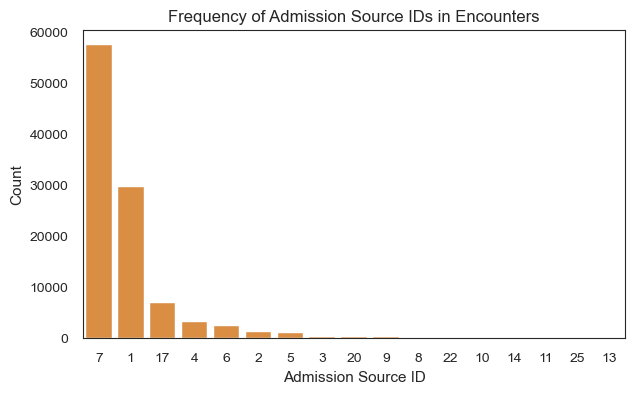

In [42]:
# maybe could also be made into a function
plt.figure(figsize=(7, 4))

ids = [str(id) for id in df_encounters['admission_source_id'].value_counts().index]

sns.barplot(x=ids, y=df_encounters['admission_source_id'].value_counts().values, color='#f28e2b')
plt.ylabel('Count')
plt.xlabel('Admission Source ID')
plt.title('Frequency of Admission Source IDs in Encounters');

#### Readmitted

The readmitted response has 3 values. First, there is `NO`, which indicates that there was no readmission. Next, there is `> 30`, which indicates that there was readmission within 30 days. Last, there is `< 30`, which indicates there was readmission within 30 days. We are interested in predicting readmission within 30 days, so we keep this category and recode it as one. The other two categories are recoded as zero.

In [43]:
df_encounters.readmitted.value_counts()

readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

#### Recoding DiabetesMed and Change

Both the `diabetesMed` and `change` fetures contain only 2 categories, so we recde these categories into binary categories. In `diabetesMed` a `Yes`, indicting that a diabetes related medication was prescribed during the encounters, is recoded as a 1. In the `change` feature a change (`Ch`) in the diabetic medications resulting from the visit, is recoded as a 1. No levels are dropped from either of these features.

In [44]:
df_encounters['diabetesMed'].value_counts()

diabetesMed
Yes    78363
No     23403
Name: count, dtype: int64

In [45]:
df_encounters['change'].value_counts()

change
No    54755
Ch    47011
Name: count, dtype: int64

### Combining Preprocessing Functions to Preprocess Data

Here we preprocess the encounter-level data by chaining together functions defined in the `utility_functions.py` file. In addition, we drop the payer code and weight features.

In [46]:
process_list = [
    utl.process_max_glu_serum, 
    utl.process_A1Cresult, 
    utl.process_medical_specialty, 
    utl.process_race, 
    utl.process_diag_codes, 
    utl.process_age, 
    utl.process_discharge_disposition_id, 
    utl.process_admission_type_id, 
    utl.process_admission_source_ID, 
    utl.process_readmitted, 
    utl.process_diabetesMed_and_change
]

In [47]:
df_encounters_processed = utl.preprocess_df(df_encounters, process_list)

In [48]:
df_encounters_processed

encounter_id  patient_nbr             race  gender       age  \
0            2278392      8222157        Caucasian  Female    [0-50)   
1             149190     55629189        Caucasian  Female    [0-50)   
2              64410     86047875  AfricanAmerican  Female    [0-50)   
3             500364     82442376        Caucasian    Male    [0-50)   
4              16680     42519267        Caucasian    Male    [0-50)   
...              ...          ...              ...     ...       ...   
101761     443847548    100162476  AfricanAmerican    Male   [70-80)   
101762     443847782     74694222  AfricanAmerican  Female  [80-100)   
101763     443854148     41088789        Caucasian    Male   [70-80)   
101764     443857166     31693671        Caucasian  Female  [80-100)   
101765     443867222    175429310        Caucasian    Male   [70-80)   

       admission_type_id discharge_disposition_id admission_source_id  \
0                  Other                    Other  Physician Referral   
1              Emergency                     Home      Emergency Room   
2              Emergency                     Home      Emergency Room   
3              Emergency                     Home      Emergency Room   
4              Emergency                     Home      Emergency Room   
...                  ...                      ...                 ...   
101761         Emergency                      SNF      Emergency Room   
101762         Emergency                    Other               Other   
101763         Emergency                     Home      Emergency Room   
101764            Urgent                      SNF      Emergency Room   
101765         Emergency                     Home      Emergency Room   

        time_in_hospital medical_specialty  num_lab_procedures  \
0                      1             Other                  41   
1                      3             Other                  59   
2                      2             Other                  11   
3                      2             Other                  44   
4                      1             Other                  51   
...                  ...               ...                 ...   
101761                 3             Other                  51   
101762                 5             Other                  33   
101763                 1             Other                  53   
101764                10   Surgery-General                  45   
101765                 6             Other                  13   

        num_procedures  num_medications  number_outpatient  number_emergency  \
0                    0                1                  0                 0   
1                    0               18                  0                 0   
2                    5               13                  2                 0   
3                    1               16                  0                 0   
4                    0                8                  0                 0   
...                ...              ...                ...               ...   
101761               0               16                  0                 0   
101762               3               18                  0                 0   
101763               0                9                  1                 0   
101764               2               21                  0                 0   
101765               3                3                  0                 0   

        number_inpatient     diag_1        diag_2       diag_3  \
0                      0   diabetes           UNK          UNK   
1                      0  neoplasms      diabetes    neoplasms   
2                      1      other     neoplasms        other   
3                      0      other      diabetes        other   
4                      0  neoplasms     neoplasms    neoplasms   
...                  ...        ...           ...          ...   
101761                 0   diabetes     neoplasms 

In [49]:
max(df_encounters_processed['patient_nbr'].value_counts())

40

### Data Aggregation

Here we aggregate the encounter-level data to the patient-level, using functions defined in the `utility_functions.py` file.

In [50]:
df_patients = utl.aggregate_encounters(df_encounters_processed)

In [51]:
# change binary columns back to categorical to simplify downstream pipeline
for col in df_patients.columns:
    if df_patients[col].nunique()==2 and col != 'readmitted':
        df_patients[col].replace({1:'Yes',0:'No'}, inplace=True)

In [52]:
df_patients.shape

(69990, 84)

<a name="2.3.-Data-Dictionary"></a>
## 2.3 Data Dictionary

[Return to top](#Notebook-Contents)

Here we provide a description and explanation of the pre-processed features in the patient-level dataset.

| Feature name                | Variants         | Type    | Description and values                                                                                                      | % missing |
| :-------------------------- | :--------------- | :------ | :-------------------------------------------------------------------------------------------------------------------------- | :-------: |
| Race                        |                  | Nominal | Values: Caucasian, Asian, African American, Hispanic, other, and unknown                                                    |    0    |
| Gender                      |                  | Nominal | Values: male, female, and unknown                                                                                           |    0    |
| Age                         |                  | Nominal | Grouped in intervals (0-50, 51-60, 61-70, 71-80, 81-100)                                                                    |    0    |
| Admission type ID           |                  | Nominal | Grouped into four categories: emergency, elective, urgent, other                                                            |    0    |
| Discharge disposition ID    |                  | Nominal | Grouped into four categories: home, home with service, SNF, other                                                           |    0    |
| Admission source ID         |                  | Nominal | Grouped into three categories: emergency room, physician referral, other                                                    |    0    |
| Number of encounters        |                  | Nominal | Count of the number of times a patient was previously admitted to hospital                                                  |    0    |
| Time in hospital            | Mean, Min, Max   | Numeric | Integer number of days between admission and discharge                                                                      |    0    |
| Medical specialty           |                  | Nominal | Grouped into nine categories: internal medicine, family/general practice, emergency/trauma, cardiology, surgery-general, orthopedics, nephrology, radiology, and other |   0    |
| Number of lab procedures    | Mean, Min, Max   | Numeric | Statistics for lab tests performed during all encounters                                                                    |    0    |
| Number of procedures        | Mean, Min, Max   | Numeric | Statistics for procedures (other than lab tests) performed during all encounters                                            |    0    |
| Number of medications       | Mean, Min, Max   | Numeric | Statistics for distinct generic medications administered during all encounters                                              |    0    |
| Number of outpatient visits |                  | Numeric | Count of outpatient visits of the patient in the year preceding the last encounter                                          |    0    |
| Number of emergency visits  |                  | Numeric | Count of emergency visits of the patient in the year preceding the last encounter                                           |    0    |
| Number of inpatient visits  |                  | Numeric | Count of inpatient visits of the patient in the year preceding the last encounter                                           |    0    |
| Diagnosis 1                 |                  | Nominal | Primary diagnosis grouped into 10 categories: neoplasms, respiratory, digestive, diabetes, injury, musculoskeletal, genitournary, circulatory, other, and unknown |    0    |
| Diagnosis 2                 |                  | Nominal | Secondary diagnosis grouped into 10 categories (see primary diagnosis description)                                               |    0    |
| Diagnosis 3                 |                  | Nominal | Additional secondary diagnosis grouped into 10 categories (see primary diagnosis description)                                    |    0    |
| Number of diagnoses         | Mean, Min, Max   | Numeric | Number of diagnoses entered to the system                                                                                   |    0    |
| Glucose serum test result   | Values, Mean, Count, Always, Ever | Numeric/Nominal | Statistics for the glucose serum test, which measures the amount of glucose in the blood at test time  |    0    |
| A1c test result             | Values, Mean, Count, Always, Ever | Numeric/Nominal | Statistics for the hemoglobin A1c test, which measures average blood sugar levels over the past 3 months  |    0    |
| Change of medications       | Mean, Count, Always, Ever  | Numeric/Nominal | Statistics for changes in diabetic medications (either dosage or generic name)                             |    0    |
| Diabetes medications        | Mean, Count, Always, Ever  | Numeric/Nominal | Statistics for any diabetic medication prescribed                                                          |    0    |
| 23 features for medications |                  | Nominal | Each feature is a binary indicator for whether the drug was prescribed or there was a change in the dosage                   |    0    |
| Previously Readmitted       | Mean, Count, Always, Ever  | Numeric/Nominal | Statistics for being previously readmitted in <30 days                                                                         |    0    |
| Readmitted                  |                  | Nominal | Days to inpatient readmission. Values: "1" if the patient was readmitted in less than 30 days and "0" otherwise              |    0    |


Of particular interest and clinical relevance here are the following features:
- **A1c test result:** these features capture long-term blood sugar levels and is a primary diagnostic for diabetes
- **Glucose serum test result:** these features capture short-term blood sugar levels and is a primary diagnostic for diabetes
- **Age:** the patient's age group
- **Number of encounters:** how many times a patient was previously admitted to hospital
- **Previously Readmitted:** these features capture whether a patient has been previously readmitted to hospital within 30 days
- **Admission source ID:** this feature tracks how a patient came to be admitted to hospital
- **Discharge disposition ID:** this feature tracks where a patient was sent after being discharged from hospital

<a name="2.4.-Data-Partitioning"></a>
## 2.4 Data Partitioning

[Return to top](#Notebook-Contents)

Our dataset has an imbalanced target variable. To address this, we employ a stratified data splitting approach. This ensures that the proportion of the positive class in both the training and testing sets remains consistent.

#### Key Arguments for the Splitting Process:

1. The random state is fixed at 109. This is a deliberate choice to guarantee that our results can be consistently replicated.
2. The sizes of the train/test subsets is established at 80%/20%.

#### Post-Split Evaluations:

1. We confirmed that the split was indeed stratified, maintaining the proportional representation of each class.
2. Although not detailed in this notebook, we have conducted additional checks to verify that both the training and testing sets contain comparable representations of patients categorized by the number of visits (specifically, those with a single visit compared to those with multiple visits).

In [53]:
# partition the data
X_train, X_test, y_train, y_test = utl.stratified_split(df_patients)

# check the dimensions
print(f'Training features shape: {X_train.shape}')
print(f'Testing features shape: {X_test.shape}')
print(f'Training target shape: {y_train.shape}')
print(f'Testing target shape: {y_test.shape}')

Before splitting the class percentage in our dataset is: 0.0496
After splitting the class percentage in y_train is: 0.0496
After splitting the class percentage in y_test is: 0.0496
Training features shape: (55992, 83)
Testing features shape: (13998, 83)
Training target shape: (55992,)
Testing target shape: (13998,)


<a name="2.5.-EDA-of-Cleaned-Training-Data"></a>
## 2.5 EDA of Cleaned Training Data

[Return to top](#Notebook-Contents)

Now we will do further exploratory data analysis on the cleaned patient-level data. However, we will only inspect the training data so as to avoid data leakage.

In [54]:
# combine the training target with the features for EDA
Xy_train = pd.concat([X_train, y_train], axis=1)

### Description

In [55]:
pd.set_option('display.max_rows', None)
Xy_train.dtypes

race                                  object
gender                                object
age                                   object
admission_type_id                     object
discharge_disposition_id              object
admission_source_id                   object
time_in_hospital                       int64
medical_specialty                     object
num_lab_procedures                     int64
num_procedures                         int64
num_medications                        int64
number_outpatient                      int64
number_emergency                       int64
number_inpatient                       int64
diag_1                                object
diag_2                                object
diag_3                                object
number_diagnoses                       int64
max_glu_serum                         object
A1Cresult                             object
metformin                             object
repaglinide                           object
nateglinid

In [56]:
# summary stats (after removing ID columns)
Xy_train_summary = Xy_train[[col for col in X_train.columns if not (col.endswith('_id') or col.endswith('_nbr'))]]
Xy_train_summary.describe().round(1)

time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
count           55992.0             55992.0         55992.0          55992.0   
mean                4.3                43.1             1.4             15.8   
std                 3.0                19.8             1.7              8.3   
min                 1.0                 1.0             0.0              1.0   
25%                 2.0                31.0             0.0             10.0   
50%                 3.0                44.0             1.0             14.0   
75%                 6.0                57.0             2.0             20.0   
max                14.0               129.0             6.0             81.0   

       number_outpatient  number_emergency  number_inpatient  \
count            55992.0           55992.0           55992.0   
mean                 0.3               0.1               0.5   
std                  1.1               0.7               1.0   
min                  0.0               0.0               0.0   
25%                  0.0               0.0               0.0   
50%                  0.0               0.0               0.0   
75%                  0.0               0.0               1.0   
max                 40.0              54.0              19.0   

       number_diagnoses  num_encounters  avg_time_in_hospital  \
count           55992.0         55992.0               55992.0   
mean                7.3             0.4                   1.1   
std                 2.0             1.1                   2.3   
min                 1.0             0.0                   0.0   
25%                 6.0             0.0                   0.0   
50%                 8.0             0.0                   0.0   
75%                 9.0             0.0                   0.0   
max                16.0            39.0                  14.0   

       min_time_in_hospital  max_time_in_hospital  avg_num_lab_procedures  \
count               55992.0               55992.0                 55992.0   
mean                    0.9                   1.2                     9.9   
std                     2.1                   2.7                    19.9   
min                     0.0                   0.0                     0.0   
25%                     0.0                   0.0                     0.0   
50%                     0.0                   0.0                     0.0   
75%                     0.0                   0.0                     0.0   
max                    14.0                  14.0                   132.0   

       min_num_lab_procedures  max_num_lab_procedures  avg_num_procedures  \
count                 55992.0                 55992.0             55992.0   
mean                      8.8                    10.9                 0.3   
std                      18.6                    21.9                 0.9   
min                       0.0                     0.0                 0.0   
25%                       0.0                     0.0                 0.0   
50%                       0.0                     0.0                 0.0   
75%                       0.0                     0.0                 0.0   
max                     132.0                   132.0                 6.0   

       min_num_procedures  max_num_procedures  avg_num_medications  \
count             55992.0             55992.0              55992.0   
mean                  0.2                 0.4                  3.7   
std                   0.9                 1.1                  7.6   
min                   0.0                 0.0                  0.0   
25%                   0.0                 0.0                  0.0   
50%                   0.0                 0.0                  0.0   
75%                   0.0                 0.0                  0.0   
max                   6.0                 6.0                 72.0   

       min_num_medications  max_num_medications  mean_diagnoses  \
count              55992.0           

### Correlations

In [57]:
# Checking correlation between the float columns and readmission

int_columns=Xy_train.select_dtypes(['int']).columns

# Initialize lists to store the results
cor_list = []
col_list = []

# Loop through each column in the integer columns list
for col in int_columns:
    col_list.append(col)
    # Compute correlation between the column and 'readmitted'
    cor_value = np.corrcoef(Xy_train[col], Xy_train['readmitted'])[0, 1]
    cor_list.append(cor_value)

# Create a DataFrame with the results
correlation_df = pd.DataFrame({
    'Column': col_list,
    'Correlation with Readmitted': cor_list
})

# Now you can print or display the DataFrame
correlation_df.sort_values('Correlation with Readmitted', ascending=False)

Column  Correlation with Readmitted
8          readmitted                        1.000
6    number_inpatient                        0.143
7    number_diagnoses                        0.054
0    time_in_hospital                        0.053
1  num_lab_procedures                        0.050
3     num_medications                        0.040
5    number_emergency                        0.039
4   number_outpatient                        0.022
2      num_procedures                       -0.006

Of the eight numeric features, only the number of inpatient visits (`number_inpatient`) shows even a low correlation with early readmittance.

In [58]:
# Checking corelation between the X variables

# Set your threshold
upper_threshold = 0.99
lower_threshold=0.85

# Calculate the correlation matrix
int_df = Xy_train.select_dtypes(include=['int', 'int64', 'float64'])
corr_matrix = int_df.corr()

# Apply the threshold to the correlation matrix and find pairs with high correlation
high_corr_pairs = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                   .stack()
                   .reset_index())
high_corr_pairs.columns = ['col1', 'col2', 'corr_value']

# Filter out the pairs with correlation above the threshold
high_corr_pairs = high_corr_pairs[(high_corr_pairs['corr_value'] > lower_threshold )& (high_corr_pairs['corr_value'] < upper_threshold ) ]
high_corr_pairs.sort_values('corr_value',ascending=False)

col1                               col2  corr_value
367   avg_num_lab_procedures             max_num_lab_procedures       0.984
496      avg_num_medications                max_num_medications       0.981
495      avg_num_medications                min_num_medications       0.980
561            min_diagnoses                      max_diagnoses       0.979
366   avg_num_lab_procedures             min_num_lab_procedures       0.973
289     avg_time_in_hospital               max_time_in_hospital       0.965
288     avg_time_in_hospital               min_time_in_hospital       0.960
575            max_diagnoses            unique_glu_measurements       0.953
548           mean_diagnoses            unique_glu_measurements       0.949
435       avg_num_procedures                 min_num_procedures       0.940
436       avg_num_procedures                 max_num_procedures       0.936
562            min_diagnoses            unique_glu_measurements       0.933
513      min_num_medications                max_num_medications       0.927
284           num_encounters  num_times_diabetic_med_prescribed       0.924
578            max_diagnoses                 unique_a1c_results       0.923
590  unique_glu_measurements                 unique_a1c_results       0.923
390   min_num_lab_procedures             max_num_lab_procedures       0.920
551           mean_diagnoses                 unique_a1c_results       0.914
421   max_num_lab_procedures                      max_diagnoses       0.898
419   max_num_lab_procedures                     mean_diagnoses       0.892
497      avg_num_medications                     mean_diagnoses       0.890
425   max_num_lab_procedures                 unique_a1c_results       0.890
565            min_diagnoses                 unique_a1c_results       0.890
499      avg_num_medications                      max_diagnoses       0.889
532      max_num_medications                      max_diagnoses       0.888
374   avg_num_lab_procedures                     mean_diagnoses       0.887
376   avg_num_lab_procedures                      max_diagnoses       0.886
422   max_num_lab_procedures            unique_glu_measurements       0.881
530      max_num_medications                     mean_diagnoses       0.881
498      avg_num_medications                      min_diagnoses       0.881
375   avg_num_lab_procedures                      min_diagnoses       0.877
377   avg_num_lab_procedures            unique_glu_measurements       0.876
500      avg_num_medications            unique_glu_measurements       0.873
420   max_num_lab_procedures                      min_diagnoses       0.872
533      max_num_medications            unique_glu_measurements       0.868
652    num_times_med_changed  num_times_diabetic_med_prescribed       0.868
515      min_num_medications                      min_diagnoses       0.867
514      min_num_medications                     mean_diagnoses       0.864
380   avg_num_lab_procedures                 unique_a1c_results       0.863
418   max_num_lab_procedures                max_num_medications       0.860
595  unique_glu_measurements  avg_times_diabetic_med_prescribed       0.860
531      max_num_medications                      min_diagnoses       0.860
315     min_time_in_hospital               max_time_in_hospital       0.859
349     max_time_in_hospital                max_num_medications       0.859
516      min_num_medications                      max_diagnoses       0.854
536      max_num_medications                 unique_a1c_results       0.854
296     avg_time_in_hospital                avg_num_medications       0.853
371   avg_num_lab_procedures                avg_num_medications       0.852
583            max_diagnoses  avg_times_diabetic_med_prescribed       0.852
416   max_num_lab_procedures                avg_num_medications       0.852

Quite a few of the derived variables created during pre-processing have high pairwise correlations. While this does not mean that these features are linearly dependent on one another, we will remove some of the most highly correlated features during feature engineering, prior to modeling.

### Class Imbalance

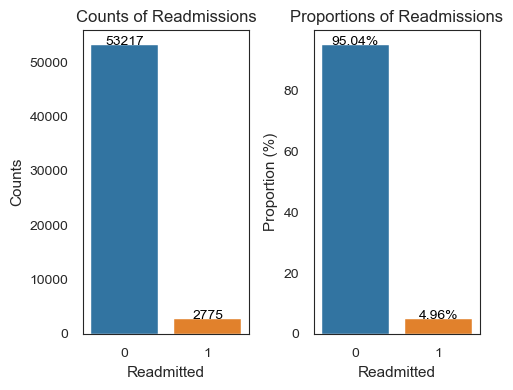

In [59]:
# Calculate counts
value_counts = Xy_train['readmitted'].value_counts()

# Calculate proportions
proportions = Xy_train['readmitted'].value_counts(normalize=True) * 100

# Create a DataFrame from the counts and proportions
data_to_plot = pd.DataFrame({'Counts': value_counts, 'Proportions': proportions})

# Create a figure with two subplots side by side
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(5, 4))  # Adjust figsize as needed

# Create a bar plot for the counts
count_plot = sns.barplot(x=data_to_plot.index, y=data_to_plot['Counts'], ax=axs[0])

# Annotate each bar in the count plot with the count value
for index, value in enumerate(data_to_plot['Counts']):
    count_plot.text(index, value, f'{value}', color='black', ha="center")

axs[0].set_title('Counts of Readmissions')
axs[0].set_xlabel('Readmitted')
axs[0].set_ylabel('Counts')

# Create a bar plot for the proportions
prop_plot = sns.barplot(x=data_to_plot.index, y=data_to_plot['Proportions'], ax=axs[1])

# Annotate each bar in the proportion plot with the proportion value
for index, value in enumerate(data_to_plot['Proportions']):
    prop_plot.text(index, value, f'{value:.2f}%', color='black', ha="center")

axs[1].set_title('Proportions of Readmissions')
axs[1].set_xlabel('Readmitted')
axs[1].set_ylabel('Proportion (%)')

plt.tight_layout();

There is marked class imbalance of the target variable, with about 5% of observations (n=2775) belonging to the positive class. Class imbalance has therefore increased as a result of aggregating the data from the encounter-level to the patient-level. We will use several strategies to deal with this class imbalance, including over- and undersamping, class weighting, and choosing performance metrics that are less sensitive to imbalance.

### Distributions of All Features

We will now inspect the distributions of all the pre-processed features to look for issues and anomalies that will need to be addressed at the feature engineering stage.

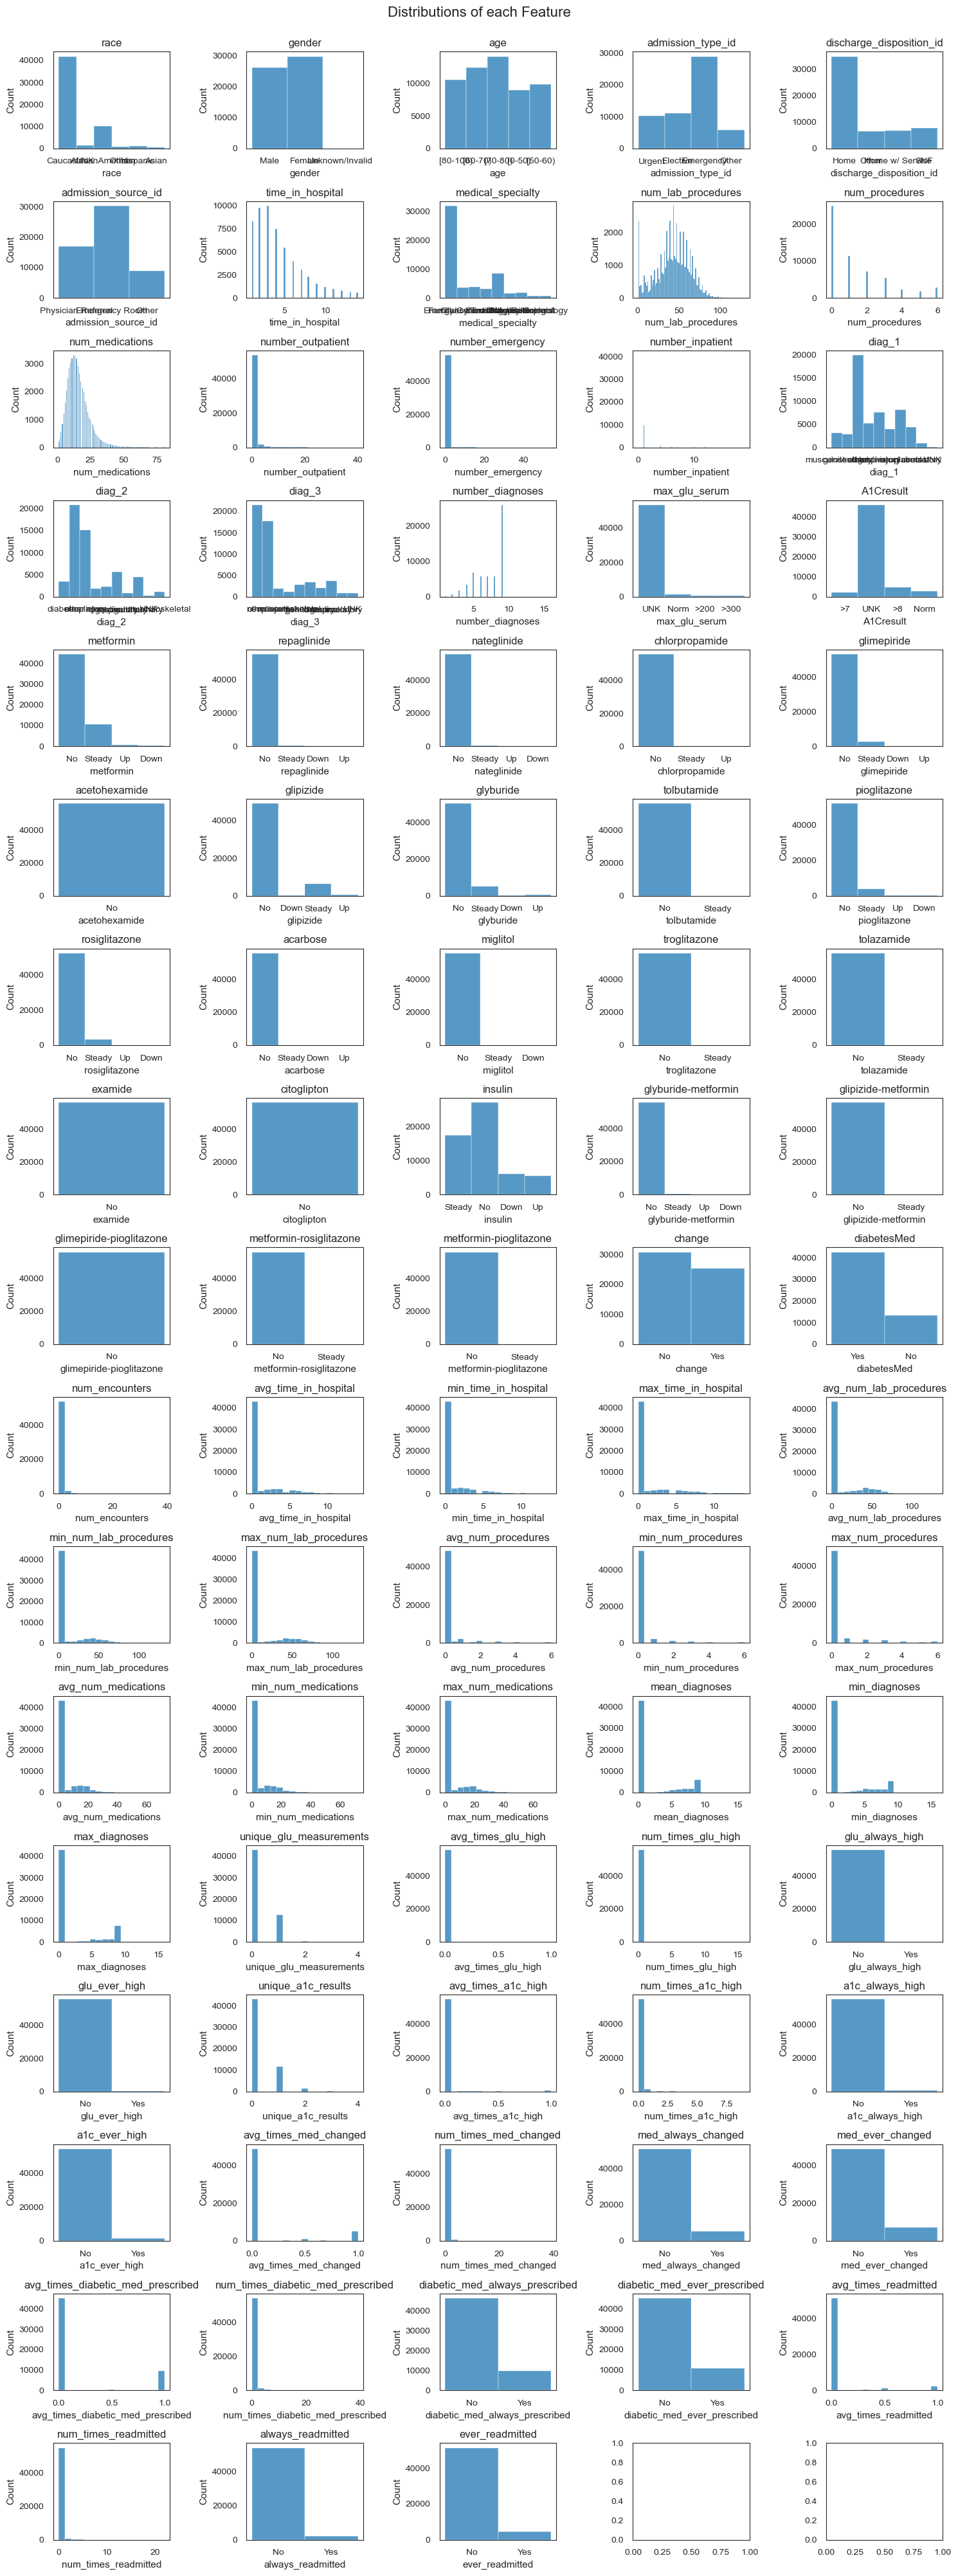

In [60]:
fig, axs = plt.subplots(17, 5, figsize=(15, 40))
axs = axs.ravel()
fig.suptitle('Distributions of each Feature', fontsize=16, y=1)

for i, col in enumerate(X_train.columns):
    sns.histplot(X_train[col], ax=axs[i], alpha=0.75)
    axs[i].set_title(f'{col}')
plt.tight_layout()

In the above figures we can see that many of the medications administered show little or no variation across their categorical levels. These features will not be useful for prediction and will be dropped during feature engineering. 

### Distributions of All Features by Readmittance Status

Now let us inspect the distributions of all the pre-processed features broken down by readmittance status. This will allow us to see which features have a bivariate association with the target variable.

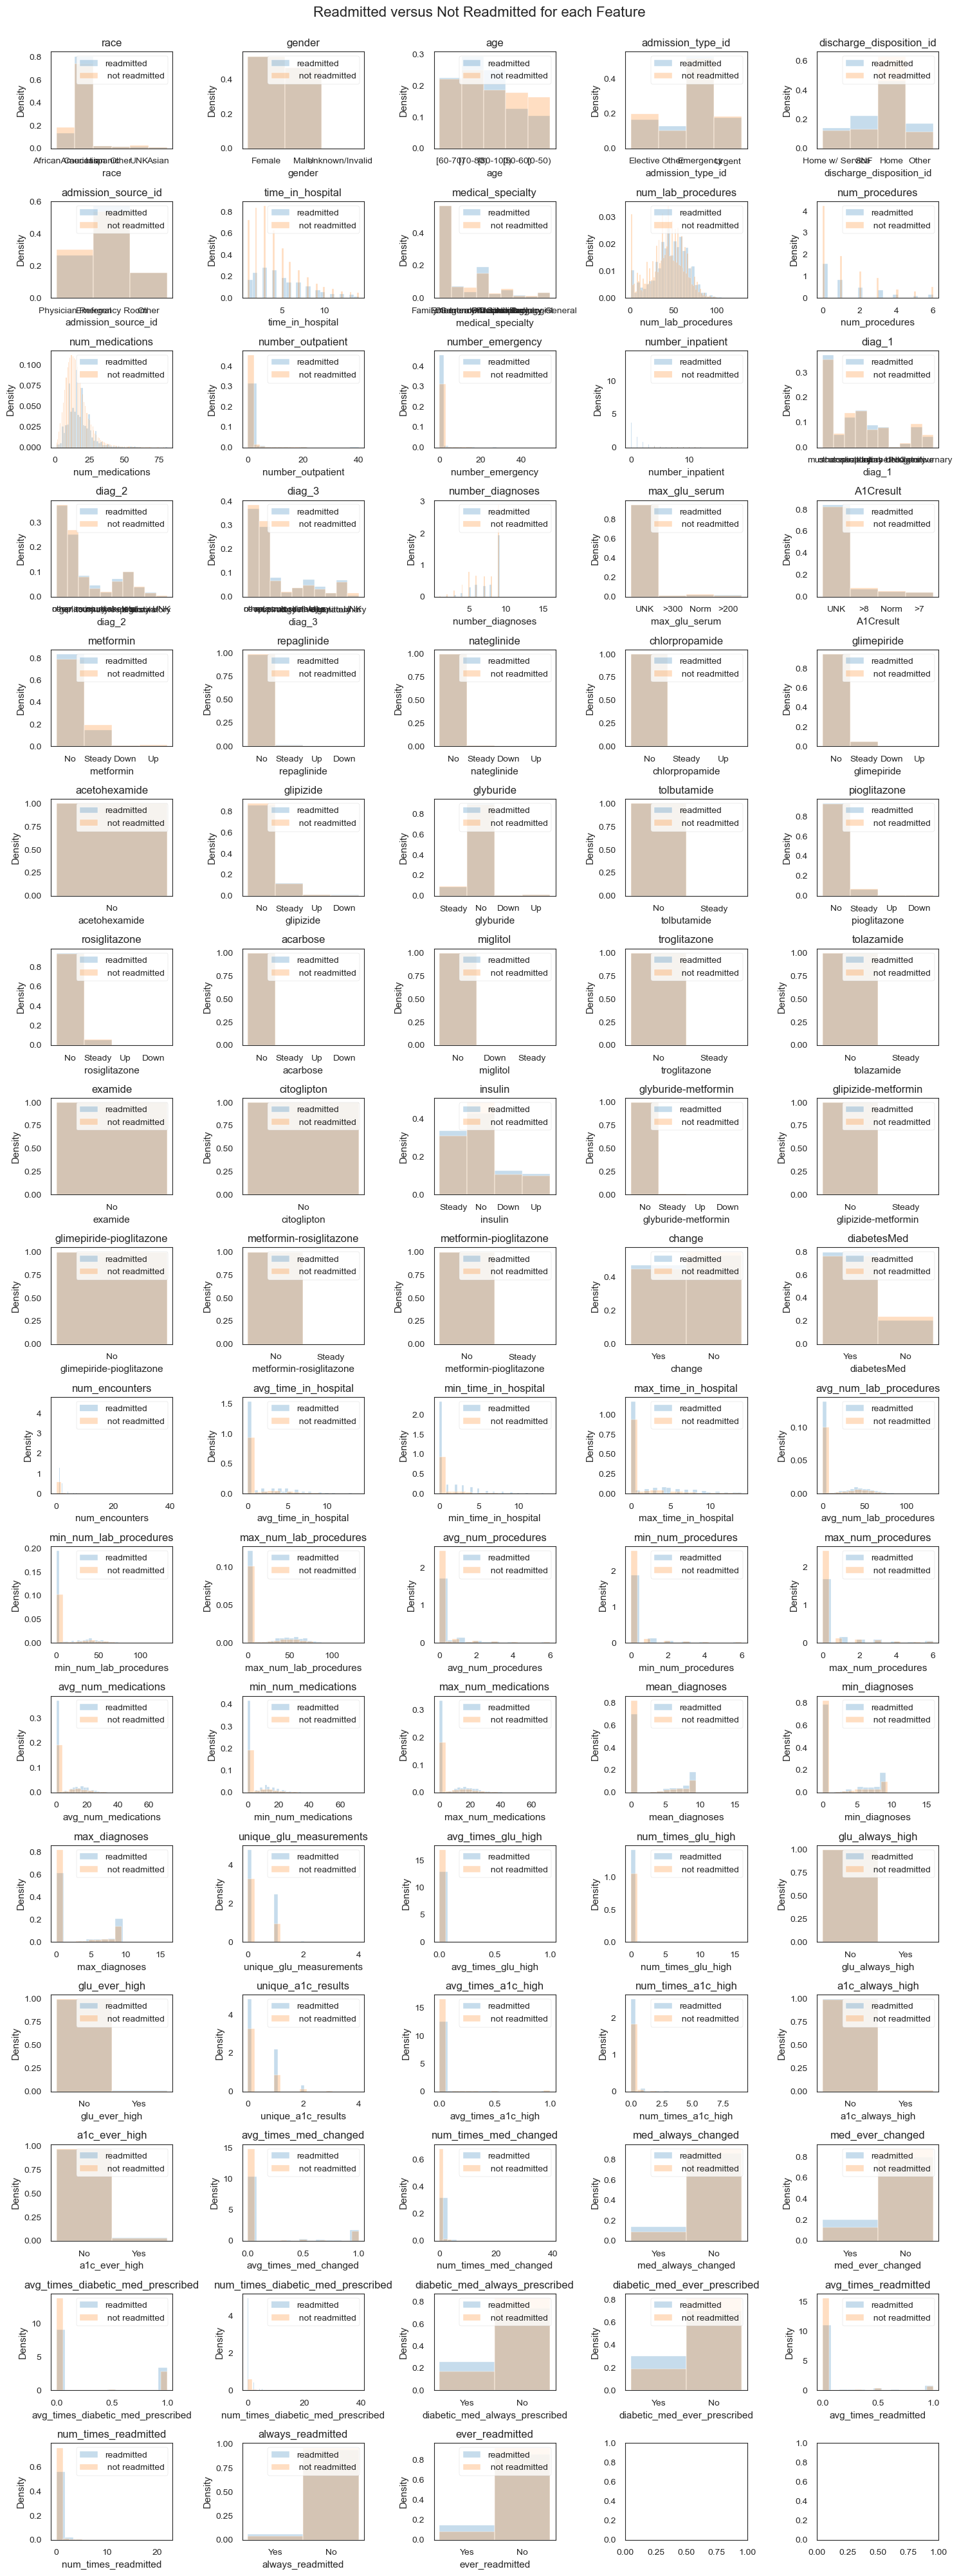

In [61]:
fig, axs = plt.subplots(17, 5, figsize=(15, 40))
axs = axs.ravel()
omit = ['patient_nbr']
mask = Xy_train['readmitted'] == 1
fig.suptitle('Readmitted versus Not Readmitted for each Feature', fontsize=16, y=1)

for i,col in enumerate(X_train.columns):
    sns.histplot(Xy_train[col][mask], ax=axs[i], alpha=0.25, label='readmitted', stat='density')
    sns.histplot(Xy_train[col][~mask], ax=axs[i], alpha=0.25, label=' not readmitted', stat='density')
    axs[i].legend()
    axs[i].set_title(f'{col}')
plt.tight_layout()

From the above figures we can see that many features do not appear to show bivariate associations with the target variable. However, some of these features may show associations that are conditional on other features (i.e., interactions) and so we must be cautious about excluding such features prematurely. However, there are several features that warrant a closer inspection and these are plotted below.

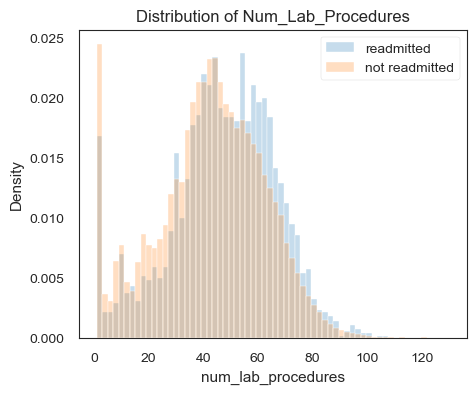

In [62]:
plt.figure(figsize=(5, 4))
bins = np.linspace(1,130,65)
sns.histplot(Xy_train['num_lab_procedures'][mask], alpha=0.25, label='readmitted', stat='density', bins=bins)
sns.histplot(Xy_train['num_lab_procedures'][~mask], alpha=0.25, label='not readmitted', stat='density', bins=bins)
plt.legend()
plt.title('Distribution of Num_Lab_Procedures');

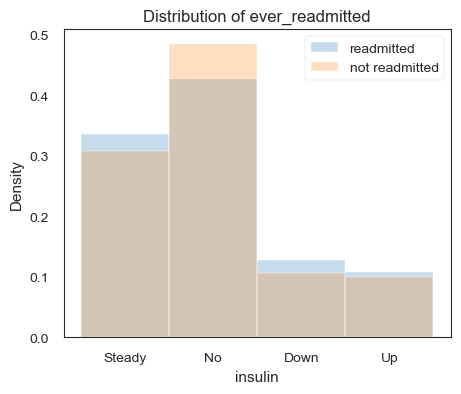

In [63]:
plt.figure(figsize=(5, 4))
mask = Xy_train['readmitted'] == 1
sns.histplot(Xy_train['insulin'][mask], alpha=0.25, label='readmitted', stat='density')
sns.histplot(Xy_train['insulin'][~mask], alpha=0.25, label='not readmitted', stat='density')
plt.legend()
plt.title(f'Distribution of {col}');

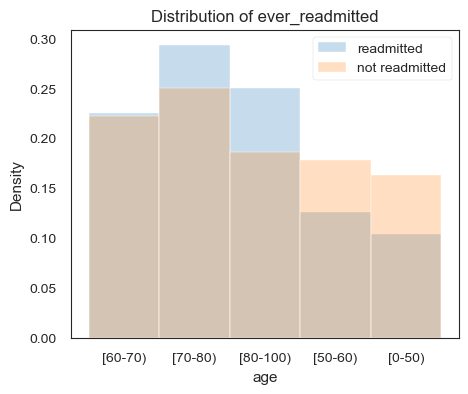

In [64]:
plt.figure(figsize=(5, 4))
mask = Xy_train['readmitted'] == 1
bins = Xy_train['age'].value_counts().sort_values().index.values
sns.histplot(x=Xy_train['age'][mask], alpha=0.25, label='readmitted', stat='density', bins=bins)
sns.histplot(x=Xy_train['age'][~mask], alpha=0.25, label='not readmitted', stat='density', bins=bins)
plt.legend()
plt.title(f'Distribution of {col}');

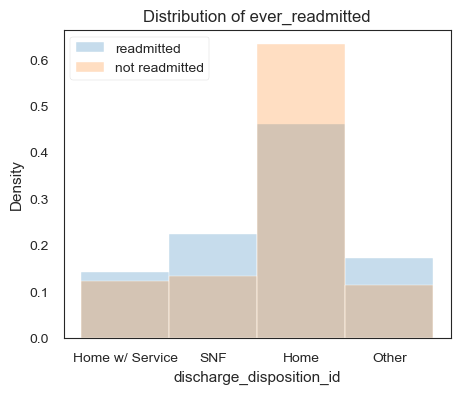

In [65]:
plt.figure(figsize=(5, 4))
mask = Xy_train['readmitted'] == 1
bins = Xy_train['age'].value_counts().sort_values().index.values
sns.histplot(x=Xy_train['discharge_disposition_id'][mask], alpha=0.25, label='readmitted', stat='density', bins=bins)
sns.histplot(x=Xy_train['discharge_disposition_id'][~mask], alpha=0.25, label='not readmitted', stat='density', bins=bins)
plt.legend()
plt.title(f'Distribution of {col}');

In the above four figures we can see that there is evidence of potential interactions between features and the target variable. In particular, between `ever_readmitted`, `age`, `discharge_disposition_ID`, `insulin`, and the target variable.

### Readmittance Rates by Features of Interest

We will now inspect readmittance rates broken down by some of the features that appear to be associated with this target variable.

In [66]:
readmittance_rate = Xy_train['readmitted'].value_counts(normalize=True)[1]

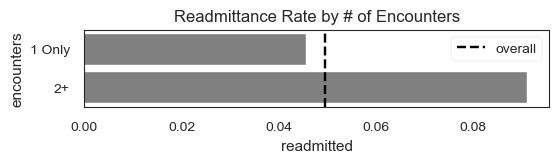

In [67]:
Xy_train['encounters']=X_train.num_encounters.apply(lambda v: '2+' if v>1 else '1 Only')
plt.figure(figsize=[6, 1])
ax = sns.barplot(data=Xy_train,y='encounters',x='readmitted',color='gray', errorbar=None)
ax.axvline(x=readmittance_rate,color='black',linestyle='--',label='overall')
ax.set_title('Readmittance Rate by # of Encounters')
ax.legend();

Patients that have two or more hospital encounters are more than twice as likely to be readmitted than those with only one encounter.

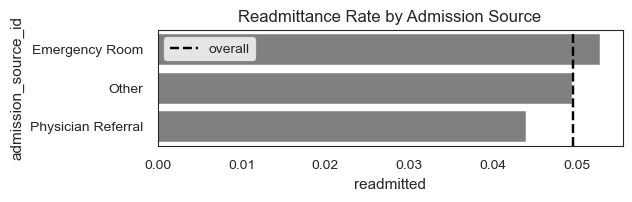

In [68]:
plt.figure(figsize=[6, 1.5])
ax = sns.barplot(data=Xy_train,y='admission_source_id',x='readmitted',color='gray', errorbar=None,
                order=['Emergency Room', 'Other','Physician Referral'])
ax.axvline(x=readmittance_rate,color='black',linestyle='--',label='overall')
ax.set_title('Readmittance Rate by Admission Source')
ax.legend();

Patients admitted from the emergency room are more likely to be readmitted than from other sources.

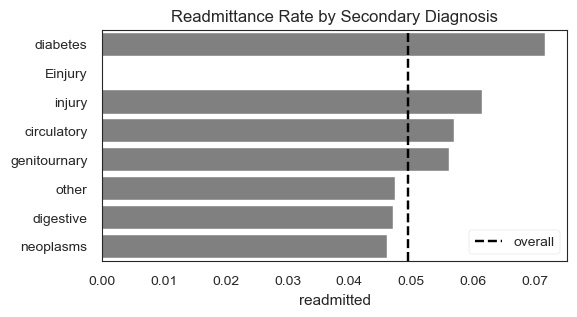

In [69]:
plt.figure(figsize=[6, 3])
ax = sns.barplot(data=Xy_train,y='diag_3',x='readmitted',color='gray', errorbar=None,
                 order=['diabetes','Einjury','injury','circulatory','genitournary','other',
                        'digestive','neoplasms'])
ax.axvline(x=readmittance_rate,color='black',linestyle='--',label='overall')
ax.set_title('Readmittance Rate by Secondary Diagnosis')
ax.set_ylabel('')
ax.legend();

Patients diagnosed with diabetes, injury, circulatory issues, genital-related issues are more likely to be readmitted.

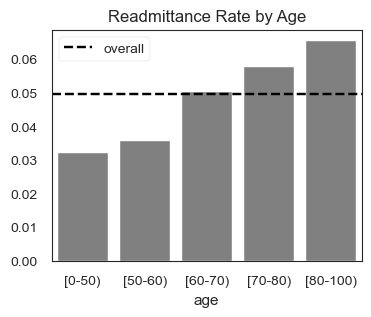

In [70]:
plt.figure(figsize=[4, 3])
ax = sns.barplot(data=Xy_train,x='age',y='readmitted',color='gray', errorbar=None,
                order=['[0-50)','[50-60)','[60-70)','[70-80)','[80-100)'])
ax.axhline(y=readmittance_rate,color='black',linestyle='--',label='overall')
ax.set_title('Readmittance Rate by Age')
ax.set_ylabel('')
ax.legend();

Patients aged 70 years and above are much more likely to be readmitted than younger patients.

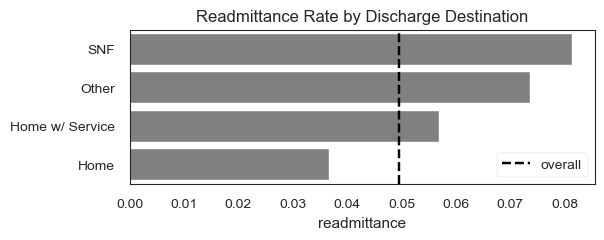

In [71]:
plt.figure(figsize=[6, 2])
ax = sns.barplot(data=Xy_train,y='discharge_disposition_id',x='readmitted',color='gray', errorbar=None,
                order=['SNF','Other','Home w/ Service','Home'])
ax.axvline(x=readmittance_rate,color='black',linestyle='--',label='overall')
ax.set_title('Readmittance Rate by Discharge Destination')
ax.set_xlabel('readmittance')
ax.set_ylabel('')
ax.legend();

Patients discharged to SNF, other, or home with service are more likely to be readmitted.

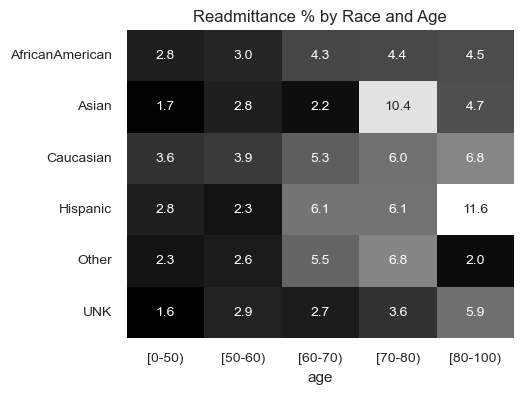

In [72]:
table = Xy_train.pivot_table(index="race", columns="age", values="readmitted", aggfunc="mean").apply(lambda x:x*100)
plt.figure(figsize=[5, 4])
ax = sns.heatmap(table,cmap='gray',annot=True,fmt='.1f',cbar=None)
ax.set_ylabel('');
ax.set_title('Readmittance % by Race and Age');

We can see that older hispanics and asians appear to have much higher readmittance rates than other groups. This highlights the need for a modeling approach that can incorporate interactions between features.

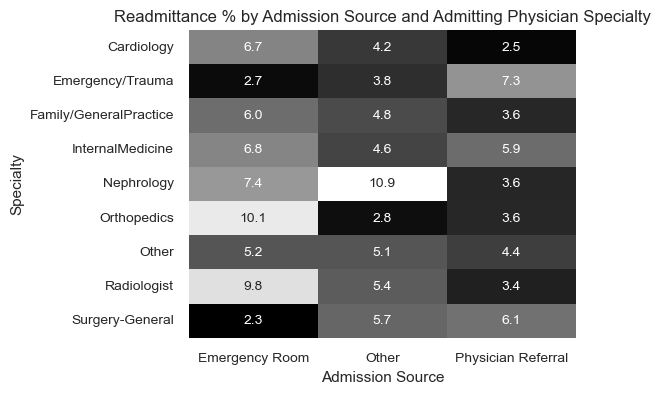

In [73]:
table = Xy_train.pivot_table(index="medical_specialty", columns="admission_source_id", values="readmitted", aggfunc="mean").apply(lambda x:x*100)
plt.figure(figsize=[5, 4])
ax = sns.heatmap(table,cmap='gray',annot=True,fmt='.1f',cbar=None)
ax.set_ylabel('');
ax.set_title('Readmittance % by Admission Source and Admitting Physician Specialty')
ax.set_ylabel('Specialty')
ax.set_xlabel('Admission Source');

We can also see that there are very high rates of early readmittance for radiology, orthopedics, and nephrology, particularly when patients are admitted from the emergency room.

In [74]:
Xy_train.readmitted.value_counts(normalize=True)*100

readmitted
0    95.044
1     4.956
Name: proportion, dtype: float64

The overall class imbalance for the patient-level has increased compared with the encounter-level data and is now 4.96% for the positive class.

<a name="2.6.-Summary-of-EDA-Key-Findings"></a>
## 2.6 Summary of EDA Key Findings

[Return to top](#Notebook-Contents)

After inspecting the data, performing preprocessing, and exploratory data analysis, we summarize our main findings here.

Our most important finding from the EDA of the cleaned training data is that readmittance rates differ markedly by:

- age
- number of previous encounters
- admission source
- secondary diagnosis
- discharge destination

In addition, some features appear to show clear interaction effects in their relationship to readmittance status:

- age and race
- medical speciality and  admission source

We will obviously include these features in all of our models and pay close attention to their variable importance rankings.

In addition, for the patient-level data target class imbalance has increased with the positive class now accounting for 4.96% of cases. We will need to address this issue using over- and undersampling, class weighting, and by selecting performance metrics that are less sensitive to imbalance.

<a name="3.-Research-Questions"></a>
# 3. Research Questions

[Return to top](#Notebook-Contents)

After initial exploration and cleaning of the data, we have focused our efforts on answering the following research question:

- **What risk factors drive early readmittance (within 30 days of discharge) to hospital for diabetes patients?**

Answering this question will help medical personnel prioritize follow-ups and interventions through the creation of patient risk profiles, which can identify patients at the highest risk level for early hospital readmittance. This information is actionable and can be used to mitigate negative health outcomes for these patients as well as increased costs for the hospital and insurance carrier.

<a name="4.-Modeling-Pipeline-and-Training"></a>
# 4. Modeling Pipeline and Training

[Return to top](#Notebook-Contents)

In this section, we establish a modeling pipeline that includes additional feature engineering steps, the establishment of a base model, the selection of six additional candidate models for hyperparameter tuning, the identification of appropriate model performance metrics, and finally the training of these models.

<a name="4.1.-Feature-Engineering"></a>
## 4.1 Feature Engineering

[Return to top](#Notebook-Contents)

We perform additional feature engineering steps that go beyond the previous preprocessing of the data. These steps include:

1. Removing features that have a pairwise correlation greater than 0.85.
2. Removing features that have cardinality greater than 10.
3. Transforming some continuous variables to the logarithmic scale.
4. Standardizing continuous variables.
5. One-hot encoding categorical variables.

These steps are efficiently achieved using an `sklearn pipeline`, so that we can fit and transform the steps on the training data and then use the same process to transform the test data.

In [75]:
# get lists of qualitative and quantitative column names
qual_cols = [cname for cname in X_train.columns if X_train[cname].dtype == "object"]
quant_cols = [cname for cname in X_train.columns if X_train[cname].dtype != "object"]

In [76]:
#################################################################################
##### Custom transformer code based on A. Geron Book by O'Reilly
#################################################################################

class PrepQuant(BaseEstimator, TransformerMixin): 
    
    def __init__(self, corr_threshold=0.85, cardinality_threshold=10):
        self.corr_threshold=corr_threshold
        self.cardinality_threshold=cardinality_threshold
    
    def fit(self, X, y=None):
        #source: stackoverflow
        corr_matrix = X.corr().abs()
        # Select upper triangle of correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.corr_cols = [column for column in upper.columns if any(upper[column] >= self.corr_threshold)] 
        
        self.high_cardinal_cols = [col for col in X.columns if X[col].nunique()>self.cardinality_threshold]
        
        return self
    
    def transform(self, X):
            
        X.drop(self.corr_cols, axis=1, inplace=True)
        
        #log Transformation is done here not because Logistic Regression
        #depends on it but to reduce the effects of outliers
        for col in X.columns:
            if col in self.high_cardinal_cols:
                X['log_'+col]=np.log1p(X[col])
                X.drop(col,axis=1,inplace=True)
        self.columns = X.columns
        return X
                
    def get_feature_names_out(self, *args, **params):
        return self.columns

In [77]:
# create the feature engineering pipeline
quant_pipeline = make_pipeline(PrepQuant(), StandardScaler())
ct = ColumnTransformer([('ohe',OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'),
                         qual_cols),
                       ('quant',quant_pipeline,quant_cols)])

# convert pipeline output to a dataframe
ct.set_output(transform='pandas')

# fit and transform on the training data
X_train_transformed = ct.fit_transform(X_train)
print(f'Transformed training data dimensions: {X_train_transformed.shape}')

# transform the testing data
X_test_transformed = ct.transform(X_test)
print(f'Transformed testing data dimensions: {X_test_transformed.shape}')

Transformed training data dimensions: (55992, 135)
Transformed testing data dimensions: (13998, 135)


In [78]:
# inspect training data dtypes
pd.set_option('display.max_rows', None)
display(X_train_transformed.dtypes)

ohe__race_Asian                                  float64
ohe__race_Caucasian                              float64
ohe__race_Hispanic                               float64
ohe__race_Other                                  float64
ohe__race_UNK                                    float64
ohe__gender_Male                                 float64
ohe__gender_Unknown/Invalid                      float64
ohe__age_[50-60)                                 float64
ohe__age_[60-70)                                 float64
ohe__age_[70-80)                                 float64
ohe__age_[80-100)                                float64
ohe__admission_type_id_Emergency                 float64
ohe__admission_type_id_Other                     float64
ohe__admission_type_id_Urgent                    float64
ohe__discharge_disposition_id_Home w/ Service    float64
ohe__discharge_disposition_id_Other              float64
ohe__discharge_disposition_id_SNF                float64
ohe__admission_source_id_Other 

In [79]:
# inspect training data variables
X_train_transformed.describe()

ohe__race_Asian  ohe__race_Caucasian  ohe__race_Hispanic  \
count        55992.000            55992.000           55992.000   
mean             0.007                0.747               0.021   
std              0.085                0.434               0.145   
min              0.000                0.000               0.000   
25%              0.000                0.000               0.000   
50%              0.000                1.000               0.000   
75%              0.000                1.000               0.000   
max              1.000                1.000               1.000   

       ohe__race_Other  ohe__race_UNK  ohe__gender_Male  \
count        55992.000      55992.000         55992.000   
mean             0.016          0.027             0.468   
std              0.126          0.161             0.499   
min              0.000          0.000             0.000   
25%              0.000          0.000             0.000   
50%              0.000          0.000             0.000   
75%              0.000          0.000             1.000   
max              1.000          1.000             1.000   

       ohe__gender_Unknown/Invalid  ohe__age_[50-60)  ohe__age_[60-70)  \
count                    5.599e+04         55992.000         55992.000   
mean                     5.358e-05             0.175             0.222   
std                      7.320e-03             0.380             0.416   
min                      0.000e+00             0.000             0.000   
25%                      0.000e+00             0.000             0.000   
50%                      0.000e+00             0.000             0.000   
75%                      0.000e+00             0.000             0.000   
max                      1.000e+00             1.000             1.000   

       ohe__age_[70-80)  ohe__age_[80-100)  ohe__admission_type_id_Emergency  \
count         55992.000          55992.000                         55992.000   
mean              0.253              0.189                             0.516   
std               0.435              0.392                             0.500   
min               0.000              0.000                             0.000   
25%               0.000              0.000                             0.000   
50%               0.000              0.000                             1.000   
75%               1.000              0.000                             1.000   
max               1.000              1.000                             1.000   

       ohe__admission_type_id_Other  ohe__admission_type_id_Urgent  \
count                     55992.000                      55992.000   
mean                          0.105                          0.183   
std                           0.307                          0.387   
min                           0.000                          0.000   
25%                           0.000                          0.000   
50%                           0.000                          0.000   
75%                           0.000                          0.000   
max                           1.000                          1.000   

       ohe__discharge_disposition_id_Home w/ Service  \
count                                      55992.000   
mean                                           0.123   
std                                            0.328   
min                                            0.000   
25%                                            0.000   
50%                                            0.000   
75%                                            0.000   
max                                            1.000   

       ohe__discharge_disposition_id_Other  ohe__discharge_disposition_id_SNF  \
count                            55992.000                          55992.000   
mean                                 0.116                              0.137   
std                                  0.321                              0.343   
min                    

<a name="4.2.-Candidate-Models-and-Performance-Assessment"></a>
## 4.2 Candidate Models and Performance Assessment

[Return to top](#Notebook-Contents)

### Base Model

We decided to use a non-regularized and untuned logistic regression as our base model, since this is a fairly simple and commonly used model that yields a linear decision boundary. We think, given the complexity of our data, this model is unlikely to perform well, but represents a good baseline.

### Candidate Models

Moving on from our base model, we selected six additional candidate models that we used to try to achieve higher performance for this classification task:

1. Lasso Logistic Regression
2. K-Nearest Neighbors Classifier
3. Random Forest Classifier
4. Gradient Boosting Classifier
5. Extreme Gradient Boosting Classifier
6. Stacked Ensemble (Meta-Model: Gradient Boosting Classifier)

These models were selected to span the major classes of classification model we have been exposed to in CS109A. We used a random state of `109` for all model training to make the results reproducable.

### Model Performance Assessment

We assessed model performance during hyperparameter training using 5-fold cross-validation on the training set, with the Area Under the Receiver Operating Characteristic curve (AUC-ROC) as our primary performance metric, since this metric is relatively invariant to class imbalance. With the exception of `XGBoost` and our stacked ensemble model, we employed `GridSearchCV` for systemetic hyperparameter tuning. This method involved experimenting with a multitude of hyperparameter combinations. For each model, we started with a relatively coarse grid of hyperparameters and created finer grids as we honed in on optimal values. The hyperparameter grids shown in this report represent a small subset of those tried.

To navigate effectively towards the optimal set of parameters, we adopted two approaches:
1. Inspecting validation set AUC-ROC for each combination of hyperparameters in the grid, and determining the disparity between training set and validation set AUC-ROC for the optimal combination of hyperparameters. This allowed us to quickly ascertain which hyperparameter settings were yielding good out-of-sample performance and were not resulting in too much overfitting. 
2. For some models, we logged runs into [wandb](https://wandb.ai/site). Wandb is a service that allows users to log their ML training runs, it records the hyperparameters and the resulting performance metric. The wandb runs are not shared here, to avoid authentication errors.

To assess tuned model performance on the full training and test set, we again used AUC-ROC and supplemented with six additional metrics. In particular, calibration was important for our use case: 
1. **AUC-ROC:** Area Under the Receiver Operating Characteristic curve measures the model’s ability to distinguish between positive and negative cases.
2. **Calibration:** the degree to which the predicted probabilities of a target match the actual frequencies of that target.
3. **AUC-PR:** Area Under the Precision-Recall curve measures the model's performance across the entire spectrum of Precision-Recall thresholds.
4. **F1-Score:** creates a balance between precision and recall by using their harmonic mean.
5. **Sensitivity-Recall:** the proportion of actual positive cases correctly identified by a model.
6. **Specificity:** the proportion of actual negative cases correctly identified by a model.
7. **Precision:** the proportion of true positives among all positive predictions made by the model.

<a name="4.3.-Base-Model"></a>
## 4.3 Base Model

[Return to top](#Notebook-Contents)

Here we fitted our base model - a non-regularized logistic regression model without any hyperparameter tuning - and assessed its performance. We fitted the model with and without balancing the class weights and compared the results.

### Summary Findings

Performance results:
- Train set AUC-ROC: 71.2%
- Test set AUC-ROC: 68.2%
- Test set calibration: 5.01% predicted vs. 4.96% actual

The base model Logistic Regression results indicated some overfitting, which regularization may help reduce. The train and test accuracies are both 95%, which is the same as the accuracy of the naive model that always outputs the majority class.

**Calibration:**
As a secondary metric, we are also interested in whether the actual predicted probabilities output by the model make sense. Note that the model without any class weights adjustment is reasonably well calibrated on the test set: average readmittance rate is 5.01% predicted vs. 4.96% actual. The model with balanced class weights (in a supplementary notebook) is, however, (expectedly) not well calibrated: average readmittance rate now jumps up to 43.68% on test versus the actual of 4.96%, with only a marginal gain in test AUC-ROC: 68.4% (balanced) vs. 68.2% (unbalanced).

**Coefficient Interpretation:**
The most important variables in Logistic Regression are the ones with the highest absolute value of coefficients. The top variables are dominated by changes in dosages of various medications such as `miglitol` (most important), `nateglinide`, and others. Primary diagnosis (reflected as `diag_1`) also seems to be an important predictor. The derived variable (`a1c_ever_high`) that measures an important blood test result of A1C for diabetic patients is also important.

In [80]:
start_time = time.time()

base_model = LogisticRegression(
    penalty=None, 
    C=1.0, 
    max_iter=10000, 
    random_state=109
).fit(X_train_transformed, y_train)

end_time = time.time()
print(f"Model fitting time: {end_time - start_time:.1f} seconds")

Model fitting time: 9.6 seconds


In [81]:
# save metrics for base model (unbalanced)
data = (X_train_transformed, X_test_transformed, y_train, y_test)
results = [utl.get_performance_metrics(base_model, 'Base Model', data)]
utl.get_results_df(results, model='Base Model')

model partition                     metric  value
0   Base Model     Train   Readmitted-Rate-Observed   4.96
1   Base Model     Train  Readmitted-Rate-Predicted   4.96
2   Base Model     Train             Naive-Accuracy  95.04
3   Base Model     Train                   Accuracy  67.45
4   Base Model     Train                    AUC-ROC  71.16
5   Base Model     Train                     AUC-PR  12.94
6   Base Model     Train                   F1-Score  16.01
7   Base Model     Train         Recall-Sensitivity  62.59
8   Base Model     Train                Specificity  67.71
9   Base Model     Train                  Precision   9.18
10  Base Model      Test   Readmitted-Rate-Observed   4.96
11  Base Model      Test  Readmitted-Rate-Predicted   5.01
12  Base Model      Test             Naive-Accuracy  95.04
13  Base Model      Test                   Accuracy  66.87
14  Base Model      Test                    AUC-ROC  68.17
15  Base Model      Test                     AUC-PR  10.62
16  Base Model      Test                   F1-Score  14.74
17  Base Model      Test         Recall-Sensitivity  57.78
18  Base Model      Test                Specificity  67.34
19  Base Model      Test                  Precision   8.45

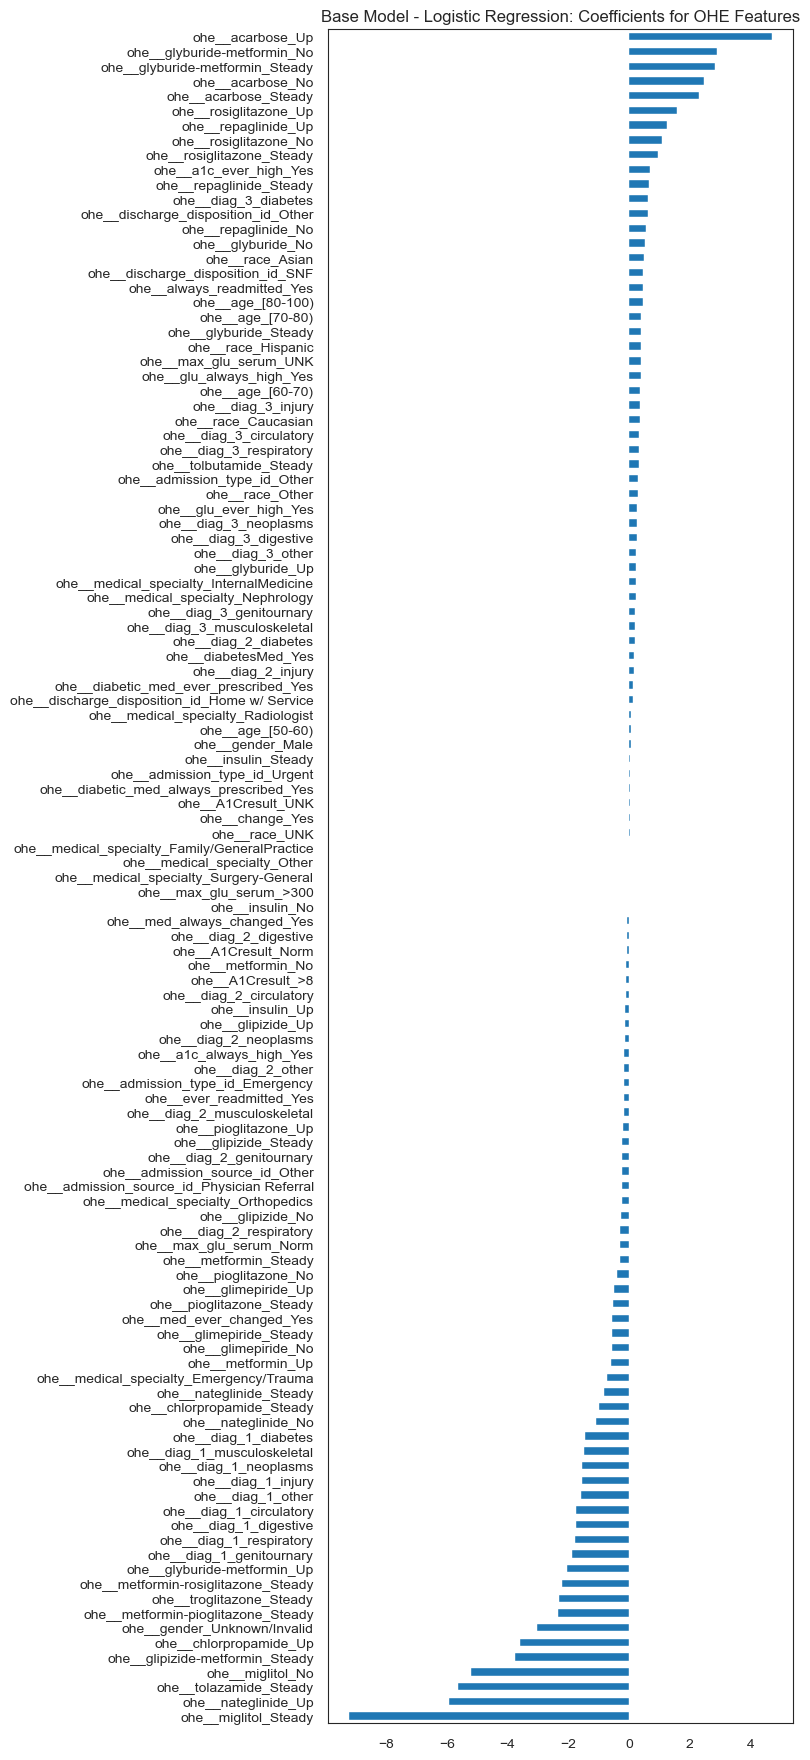

In [82]:
ohe_features = [feature for feature in base_model.feature_names_in_ if feature.startswith('ohe__')]
ohe_coefs    = [coef for feature,coef in zip(base_model.feature_names_in_,base_model.coef_.ravel())
                                             if feature.startswith('ohe__')]

plt.figure(figsize=(6,22))
coef = pd.Series(ohe_coefs, index=ohe_features)
_ = coef.sort_values().plot.barh().set_title('Base Model - Logistic Regression: Coefficients for OHE Features')

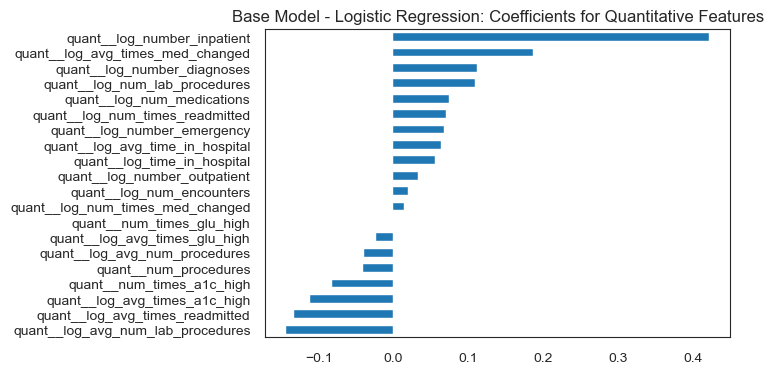

In [83]:
quant_features = [feature for feature in base_model.feature_names_in_ if feature.startswith('quant__')]
quant_coefs    = [coef for feature,coef in zip(base_model.feature_names_in_,base_model.coef_.ravel())
                                             if feature.startswith('quant__')]

plt.figure(figsize=(6,4))
coef = pd.Series(quant_coefs, index=quant_features)
_ = coef.sort_values().plot.barh().set_title('Base Model - Logistic Regression: Coefficients for Quantitative Features')

<a name="4.4.-Logistic-Regression-Models"></a>
## 4.4 Logistic Regression Models

[Return to top](#Notebook-Contents)

### Summary Findings

Performance results:
- Mean (5-fold CV) train set AUC-ROC: 78.5%
- Mean (5-fold CV) validation set AUC-ROC: 71.3%
- Test set AUC-ROC: 70.6%
- Test set calibration: 5.00% predicted vs. 4.96% actual

As we tried to optimize for the AUC-ROC curve we found the following:
1. `penalty=l1` (i.e., lasso) performed better than elasticnet with various `l1_ratio` settings.
2. Setting `class_weight` to balanced did not improve performance on validation set AUC-ROC and made the model uncalibrated.
3. A variety of over- and under-sampling methods (random, SMOTE) did not improve validation set model performance.
4. The model was reasonably well calibrated on the test set (5.00% predicted vs. 4.96% actual).

Best parameters out of those tuned:
- `C`: 0.1

For clarity and brevity in this report, we have included only a select few of the hyperparameter combinations we tried in the subsequent code snippets.

In [84]:
# set number of cross-validation folds for all hyperparameter tuning
CV_FOLDS = 5

### Lasso Logistic Regression

In [85]:
# hyperparameter grid
params = {
    'C': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
    'l1_ratio': [None],                            # tried: 0, 0.5, 1
    'penalty': ['l1'],                             # tried: elasticnet
    'solver': ['liblinear'],                       # tried: saga
    'class_weight': [None],                        # tried: 'balanced' 
    'max_iter': [1000],
    'random_state': [109]
}

# k-fold CV
llr = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=params,
    cv=CV_FOLDS,
    scoring='roc_auc',
    refit=True,
    return_train_score=True,
    n_jobs=-1
)

start_time = time.time()

# fit the model
llr.fit(X_train_transformed, y_train)

end_time = time.time()
print(f"Model fitting time: {end_time - start_time:.1f} seconds")

print("\nBest parameters:", llr.best_params_, "\n\nValidation Set AUC-ROC:", round(llr.best_score_, 3))

Model fitting time: 50.7 seconds

Best parameters: {'C': 1.0, 'class_weight': None, 'l1_ratio': None, 'max_iter': 1000, 'penalty': 'l1', 'random_state': 109, 'solver': 'liblinear'} 

Validation Set AUC-ROC: 0.697


In [86]:
# determine how many features were dropped by L1 regularization
zeroed_feats = [feature for coef, feature in zip(llr.best_estimator_.coef_[0], X_train_transformed.columns) if coef == 0]
print('Number of features whose coefficients were shrunk to zero:', len(zeroed_feats))

unzeroed_feats = [feature for coef, feature in zip(llr.best_estimator_.coef_[0], X_train_transformed.columns) if coef != 0]
print('Number of features with non-zero coefficients:', len(unzeroed_feats))

Number of features whose coefficients were shrunk to zero: 28
Number of features with non-zero coefficients: 107


### Polynomial Lasso Logistic Regression

Make polynomial features only from features that did not get shrunk to zero in lasso logistic regression.

In [87]:
# create polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_transformed_poly = poly.fit_transform(X_train_transformed[unzeroed_feats])
X_test_transformed_poly = poly.transform(X_test_transformed[unzeroed_feats])

print('Number of training set features with polynomial features of degree 2:', X_train_transformed_poly.shape[1])

Number of training set features with polynomial features of degree 2: 5885


In [88]:
# hyperparameter grid
params = {
    'C': [1e-1],                 # tried: 1e-2, 1e-1, 1e0                      
    'penalty': ['l1'],                             
    'solver': ['liblinear'],                       
    'class_weight': [None],                         
    'max_iter': [1000],
    'random_state': [109]
}

# k-fold CV
llr_poly = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=params,
    cv=CV_FOLDS,
    scoring='roc_auc',
    refit=True,
    return_train_score=True,
    n_jobs=-1
)

start_time = time.time()

# fit the model
llr_poly.fit(X_train_transformed_poly, y_train)

end_time = time.time()
print(f"Model fitting time: {end_time - start_time:.1f} seconds")

print("\nBest parameters:", llr_poly.best_params_, "\n\nValidation Set AUC-ROC:", round(llr_poly.best_score_*100, 2))

Model fitting time: 36.9 seconds

Best parameters: {'C': 0.1, 'class_weight': None, 'max_iter': 1000, 'penalty': 'l1', 'random_state': 109, 'solver': 'liblinear'} 

Validation Set AUC-ROC: 71.3


In [89]:
def get_train_val_scores(model, params):
    '''
    Parameters
    ----------
    model : fitted sklearn model
    params : list of hyperparameters that have been tuned
    
    Returns: pandas data frame
    '''
    import pandas as pd
    from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
    from sklearn.tree import DecisionTreeClassifier 
    from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
    from sklearn.ensemble import AdaBoostClassifier 
    from xgboost import XGBClassifier
    
    score_cols = ['mean_test_score', 'std_test_score', 'mean_train_score']
    param_cols = ['param_' + param for param in params]
    df_scores = pd.DataFrame(model.cv_results_)[score_cols + param_cols]
    df_scores.rename(columns={'mean_test_score': 'mean_val_score', 'std_test_score': 'std_val_score'}, inplace=True)
    df_scores.sort_values(by='mean_val_score', ascending=False, inplace=True)
    cols_to_multiply = ['mean_val_score', 'std_val_score', 'mean_train_score']
    df_scores[cols_to_multiply] = df_scores[cols_to_multiply].apply(lambda x: x * 100)
    
    return df_scores


In [90]:
# get training and validation scores for each hyperparameter combination
utl.get_train_val_scores(llr_poly, params=['C'])

mean_val_score  std_val_score  mean_train_score param_C
0           71.30           0.91             78.76    0.10

In [91]:
# save metrics for logistic regularized
data = (X_train_transformed_poly, X_test_transformed_poly, y_train, y_test)
results.append(utl.get_performance_metrics(llr_poly, 'Lasso Logistic Poly', data))
utl.get_results_df(results, model='Lasso Logistic Poly')

model partition                     metric  value
1   Lasso Logistic Poly     Train   Readmitted-Rate-Observed   4.96
3   Lasso Logistic Poly     Train  Readmitted-Rate-Predicted   4.98
5   Lasso Logistic Poly     Train             Naive-Accuracy  95.04
7   Lasso Logistic Poly     Train                   Accuracy  69.79
9   Lasso Logistic Poly     Train                    AUC-ROC  78.47
11  Lasso Logistic Poly     Train                     AUC-PR  21.95
13  Lasso Logistic Poly     Train                   F1-Score  19.16
15  Lasso Logistic Poly     Train         Recall-Sensitivity  72.22
17  Lasso Logistic Poly     Train                Specificity  69.66
19  Lasso Logistic Poly     Train                  Precision  11.04
21  Lasso Logistic Poly      Test   Readmitted-Rate-Observed   4.96
23  Lasso Logistic Poly      Test  Readmitted-Rate-Predicted   5.00
25  Lasso Logistic Poly      Test             Naive-Accuracy  95.04
27  Lasso Logistic Poly      Test                   Accuracy  68.47
29  Lasso Logistic Poly      Test                    AUC-ROC  70.63
31  Lasso Logistic Poly      Test                     AUC-PR  12.49
33  Lasso Logistic Poly      Test                   F1-Score  15.73
35  Lasso Logistic Poly      Test         Recall-Sensitivity  59.37
37  Lasso Logistic Poly      Test                Specificity  68.95
39  Lasso Logistic Poly      Test                  Precision   9.07

<a name="4.5.-K-Nearest-Neighbors-Models"></a>
## 4.5 K-Nearest Neighbors Models

[Return to top](#Notebook-Contents)

### Summary Findings

Performance results:
- Mean (5-fold CV) train set AUC-ROC: 100%
- Mean (5-fold CV) validation set AUC-ROC: 69.8%
- Test set AUC-ROC: 67.7%
- Test set calibration: 4.26% predicted vs. 4.96% actual

As we tried to optimize for the AUC-ROC curve we found the following:
1. `n_neighbors=400` was a good compromise, increasing the number of nearest neighbors beyond this number reduced validation set AUC-ROC, while decreasing the number of nearest neighbors resulted in overfitting, as evidenced by large disparities between training and validation performance. However, even with this optimal setting the model showed substantial overfitting on the training set.
2. Strictly speaking, Euclidean distance is not appropriate for one-hot-encoded features. To remedy this, we attempted to use the [Gower's generalized distance](https://medium.com/analytics-vidhya/gowers-distance-899f9c4bd553), but its calculation on the full training set was too computationally intensive to be feasible.
3. The model was poorly calibrated on the test set (4.26% predicted vs. 4.96% actual).

Best parameters out of those tuned:
- `n_neighbors`: 400
- `weights`: distance
- `metric`: euclidean

For clarity and brevity in this report, we have included only a select few of the hyperparameter combinations we tried in the subsequent code snippets.

In [92]:
# hyperparameter tuning dictionary
params = {
    'n_neighbors': [200, 400, 600],    # tried: 10, 50, 100, 200, 400, 600, 800, 1000
    'weights': ['distance'],
    'metric': ['euclidean']            # tried: 'gower' (via 'precomputed')
}

# k-fold CV
knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=params,
    cv=CV_FOLDS,
    scoring='roc_auc',
    refit=True,
    return_train_score=True,
    n_jobs=-1
)

start_time = time.time()

# fit the model
knn.fit(X_train_transformed, y_train)

end_time = time.time()
print(f"Model fitting time: {end_time - start_time:.1f} seconds")

print("\nBest parameters:", knn.best_params_, "\n\nValidation Set AUC-ROC:", round(knn.best_score_*100, 2))

Model fitting time: 58.8 seconds

Best parameters: {'metric': 'euclidean', 'n_neighbors': 400, 'weights': 'distance'} 

Validation Set AUC-ROC: 69.76


In [93]:
# get training and validation scores for each hyperparameter combination
utl.get_train_val_scores(knn, params=['n_neighbors'])

mean_val_score  std_val_score  mean_train_score param_n_neighbors
1           69.76           1.56            100.00               400
2           69.65           1.60            100.00               600
0           69.33           1.18            100.00               200

In [94]:
data = (X_train_transformed, X_test_transformed, y_train, y_test)
results.append(utl.get_performance_metrics(knn, 'K-Nearest Neighbors', data))
utl.get_results_df(results, model='K-Nearest Neighbors')

model partition                     metric  value
2   K-Nearest Neighbors     Train   Readmitted-Rate-Observed   4.96
5   K-Nearest Neighbors     Train  Readmitted-Rate-Predicted   4.96
8   K-Nearest Neighbors     Train             Naive-Accuracy  95.04
11  K-Nearest Neighbors     Train                   Accuracy 100.00
14  K-Nearest Neighbors     Train                    AUC-ROC 100.00
17  K-Nearest Neighbors     Train                     AUC-PR 100.00
20  K-Nearest Neighbors     Train                   F1-Score 100.00
23  K-Nearest Neighbors     Train         Recall-Sensitivity 100.00
26  K-Nearest Neighbors     Train                Specificity 100.00
29  K-Nearest Neighbors     Train                  Precision 100.00
32  K-Nearest Neighbors      Test   Readmitted-Rate-Observed   4.96
35  K-Nearest Neighbors      Test  Readmitted-Rate-Predicted   4.26
38  K-Nearest Neighbors      Test             Naive-Accuracy  95.04
41  K-Nearest Neighbors      Test                   Accuracy  68.60
44  K-Nearest Neighbors      Test                    AUC-ROC  67.65
47  K-Nearest Neighbors      Test                     AUC-PR  10.69
50  K-Nearest Neighbors      Test                   F1-Score  14.34
53  K-Nearest Neighbors      Test         Recall-Sensitivity  53.03
56  K-Nearest Neighbors      Test                Specificity  69.41
59  K-Nearest Neighbors      Test                  Precision   8.29

<a name="4.6.-Random-Forest-Models"></a>
## 4.6 Random Forest Models

[Return to top](#Notebook-Contents)

### Summary Findings

Performance results:
- Mean (5-fold CV) train set AUC-ROC: 98.6%
- Mean (5-fold CV) validation set AUC-ROC: 73.1%
- Test set AUC-ROC: 71.4%
- Test set calibration: 4.98% predicted vs. 4.96% actual
  
As we tried to optimize for the AUC-ROC curve we found the following:
1. `n_estimators=800` was a good compromise, increasing the number of estimators beyond this number took much longer to fit the models and the gain in AUC-ROC was only marginal.
2. We found that entropy as a `criterion` stood out against Gini for our data.
3. A `max_depth` of 18 worked best, which for our data is not very deep for a base learner in a random forest model, meaning a more generalizable model worked better.
4. A variety of over- and under-sampling methods (random, SMOTE) did not improve validation set model performance.
5. The model was well calibrated on the test set (4.98% predicted vs. 4.96% actual).

Best parameters out of those tuned:
- `n_estimators`: 800
- `criterion`: entropy
- `max_depth`: 18
- `min_impurity_decrease`: 0.0
- `min_samples_leaf`: 2
- `min_samples_split`: 2
- `class_weight`: None

For clarity and brevity in this report, we have included only a select few of the hyperparameter combinations we tried in the subsequent code snippets.

In [95]:
# hyperparameter grid
params = {
    'random_state': [109], 
    'n_estimators': [800],                # tried: 100, 500, 1000
    'criterion': ['entropy'],             # tried: 'Gini'
    'max_depth': [17,18,19],              # tried: 10, 15, 17, 18, 19, 20, 25, 50 
    'min_samples_split': [2,3],           # tried: 2, 3, 4
    'min_samples_leaf': [2],              # tried: 1, 3, 4, 10
    'min_weight_fraction_leaf': [0.0], 
    'max_features': ['sqrt'],             # tried: log2, 0.3, 0.5
    'max_leaf_nodes': [None], 
    'min_impurity_decrease': [0.0],       # tried: 0.3, 0.5
    'bootstrap': [True], 
    'oob_score': [False],
    'n_jobs': [-1],
    'warm_start': [False], 
    'class_weight': [None],               # tried: balanced, SMOTE (using pipeline), random undersampled (using pipeline)
    'ccp_alpha': [0.0]
}

# k-fold CV
rf = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=params,
    cv=CV_FOLDS,
    scoring='roc_auc',
    refit=True,
    return_train_score=True,
    n_jobs=-1
)

start_time = time.time()

# fit the model
rf.fit(X_train_transformed, y_train)

end_time = time.time()
print(f"Model fitting time: {end_time - start_time:.1f} seconds")

print("\nBest parameters:", rf.best_params_, "\n\nValidation Set AUCROC:", round(rf.best_score_*100, 2))

Model fitting time: 103.3 seconds

Best parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 18, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 800, 'n_jobs': -1, 'oob_score': False, 'random_state': 109, 'warm_start': False} 

Validation Set AUCROC: 73.14


In [96]:
# get training and validation scores for each hyperparameter combination
utl.get_train_val_scores(rf, params=['max_depth', 'min_samples_split'])

mean_val_score  std_val_score  mean_train_score param_max_depth  \
2           73.14           1.93             98.96              18   
3           73.14           1.93             98.96              18   
0           73.00           1.78             98.38              17   
1           73.00           1.78             98.38              17   
4           72.86           1.83             99.35              19   
5           72.86           1.83             99.35              19   

  param_min_samples_split  
2                       2  
3                       3  
0                       2  
1                       3  
4                       2  
5                       3

In [97]:
data = (X_train_transformed, X_test_transformed, y_train, y_test)
results.append(utl.get_performance_metrics(rf, 'Random Forest', data))
utl.get_results_df(results, model='Random Forest')

model partition                     metric  value
3   Random Forest     Train   Readmitted-Rate-Observed   4.96
7   Random Forest     Train  Readmitted-Rate-Predicted   4.96
11  Random Forest     Train             Naive-Accuracy  95.04
15  Random Forest     Train                   Accuracy  73.94
19  Random Forest     Train                    AUC-ROC  98.59
23  Random Forest     Train                     AUC-PR  90.87
27  Random Forest     Train                   F1-Score  27.32
31  Random Forest     Train         Recall-Sensitivity  98.81
35  Random Forest     Train                Specificity  72.64
39  Random Forest     Train                  Precision  15.85
43  Random Forest      Test   Readmitted-Rate-Observed   4.96
47  Random Forest      Test  Readmitted-Rate-Predicted   4.98
51  Random Forest      Test             Naive-Accuracy  95.04
55  Random Forest      Test                   Accuracy  63.17
59  Random Forest      Test                    AUC-ROC  71.38
63  Random Forest      Test                     AUC-PR  13.33
67  Random Forest      Test                   F1-Score  15.48
71  Random Forest      Test         Recall-Sensitivity  68.01
75  Random Forest      Test                Specificity  62.92
79  Random Forest      Test                  Precision   8.73

<a name="4.7.-Gradient-Boosting-Models"></a>
## 4.7 Gradient Boosting Models

[Return to top](#Notebook-Contents)

### Summary Findings

Performance results:
- Mean (5-fold CV) train set AUC-ROC: 75.1%
- Mean (5-fold CV) validation set AUC-ROC: 71.9%
- Test set AUC-ROC: 70.6%
- Test set calibration: 4.95% predicted vs. 4.96% actual

As we tried to optimize for the AUC-ROC curve we found the following:
1. `learning_rate=0.1` was a good moderate setting that effectively regulated the extent to which each new tree influenced the overall classification.
2. `n_estimators=100` was a good compromise, increasing the number of estimators beyond this number resulted in overfitting, as evidenced by a large disparity between train and validation set performance, and the gain in validation AUC-ROC was only marginal.
3. A `max_depth` of 3 worked best, indicating that for our data we needed base learners with a little more complexity than a stump. This will have enabled the base learners to have non-linear decision boundaries and to model interactions between features.
4. The model was very well calibrated on the test set (4.95% predicted vs. 4.96% actual).

Best parameters out of those tuned:
- `learning_rate`: 0.1
- `n_estimators`: 100
- `min_samples_split`: 2
- `min_samples_leaf`: 1
- `max_depth`: 3
- `min_impurity_decrease`: 0.0

For clarity and brevity in this report, we have included only a select few of the hyperparameter combinations we tried in the subsequent code snippets.

In [98]:
# hyperparameter grid
params = {
    'random_state': [109],
    'learning_rate': [0.01,0.1,1],        # tried: 0.0001, 0.001, 0.01, 0.1, 1, 10, 100
    'n_estimators': [50,100],             # tried: 50, 100, 200
    'min_samples_split': [2], 
    'min_samples_leaf': [1], 
    'min_weight_fraction_leaf': [0.0], 
    'max_depth': [3],                     # tried: 1, 2, 3, 4, 5
    'min_impurity_decrease': [0.0], 
    'max_features': [None], 
    'max_leaf_nodes': [None], 
    'warm_start': [False],
    'validation_fraction': [0.1], 
    'n_iter_no_change': [10],
    'ccp_alpha': [0.0]
}

# k-fold CV
gb = GridSearchCV(
    estimator=GradientBoostingClassifier(),
    param_grid=params,
    cv=CV_FOLDS,
    scoring='roc_auc',
    refit=True,
    return_train_score=True,
    n_jobs=-1
)

start_time = time.time()

gb.fit(X_train_transformed, y_train)

end_time = time.time()
print(f"Model fitting time: {end_time - start_time:.1f} seconds")

print("\nBest parameters:", gb.best_params_, "\n\nValidation Set AUC-ROC:", round(gb.best_score_*100, 2))

Model fitting time: 39.0 seconds

Best parameters: {'ccp_alpha': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': 10, 'random_state': 109, 'validation_fraction': 0.1, 'warm_start': False} 

Validation Set AUC-ROC: 71.85


In [99]:
# get training and validation scores for each hyperparameter combination
utl.get_train_val_scores(gb, params=['learning_rate', 'n_estimators'])

mean_val_score  std_val_score  mean_train_score param_learning_rate  \
3           71.85           1.95             74.75                0.10   
2           71.59           1.87             73.93                0.10   
1           69.81           2.35             70.65                0.01   
0           68.71           2.14             69.40                0.01   
4           68.39           1.91             70.62                   1   
5           68.39           1.91             70.62                   1   

  param_n_estimators  
3                100  
2                 50  
1                100  
0                 50  
4                 50  
5                100

In [100]:
# save metrics for gradient boosting
data = (X_train_transformed, X_test_transformed, y_train, y_test)
results.append(utl.get_performance_metrics(gb, 'Gradient Boosting', data))
utl.get_results_df(results, model='Gradient Boosting')

model partition                     metric  value
4   Gradient Boosting     Train   Readmitted-Rate-Observed   4.96
9   Gradient Boosting     Train  Readmitted-Rate-Predicted   4.95
14  Gradient Boosting     Train             Naive-Accuracy  95.04
19  Gradient Boosting     Train                   Accuracy  68.83
24  Gradient Boosting     Train                    AUC-ROC  75.09
29  Gradient Boosting     Train                     AUC-PR  19.54
34  Gradient Boosting     Train                   F1-Score  17.69
39  Gradient Boosting     Train         Recall-Sensitivity  67.60
44  Gradient Boosting     Train                Specificity  68.89
49  Gradient Boosting     Train                  Precision  10.18
54  Gradient Boosting      Test   Readmitted-Rate-Observed   4.96
59  Gradient Boosting      Test  Readmitted-Rate-Predicted   4.95
64  Gradient Boosting      Test             Naive-Accuracy  95.04
69  Gradient Boosting      Test                   Accuracy  68.20
74  Gradient Boosting      Test                    AUC-ROC  70.59
79  Gradient Boosting      Test                     AUC-PR  12.89
84  Gradient Boosting      Test                   F1-Score  16.00
89  Gradient Boosting      Test         Recall-Sensitivity  61.10
94  Gradient Boosting      Test                Specificity  68.57
99  Gradient Boosting      Test                  Precision   9.21

<a name="4.8.-Extreme-Gradient-Boosting-Models"></a>
## 4.8 Extreme-Gradient Boosting Models

[Return to top](#Notebook-Contents)

### Summary Findings

Performance results:
- Train set AUC-ROC: 78.5%
- Validation set AUC-ROC: 72.1%
- Test set AUC-ROC: 71.9%
- Test set calibration: 4.94% predicted vs. 4.96% actual

As we tried to optimize for the AUC-ROC curve we found the following:
1. Balancing classes via class weights (`scale_pos_weight` in `XGBoost`) or over- (SMOTE)/under-sampling did not improve AUC-ROC for `XGBoost`. This result is consistent with the findings of the 2022 paper [To Smote or not to Smote?](https://arxiv.org/pdf/2201.08528.pdf), which provides evidence that for strong state of the art learners, such as `XGBoost`, balancing does not generally help performance. `XGBoost` documentation also recommends that if calibration is one of the key performance metrics of interest (which it is in this case), then not to use `scale_pos_weight` parameter.
2. A moderate learning rate (`eta`) and number of base learners (`n_estimators`) worked best with shallow trees (`max_depth=4`). However, since the base learners are not stumps they will have non-linear decision boundaries and the ability to capture interactions between features.
3. The model was well calibrated on the test set (4.94% predicted vs. 4.96% actual).

Best parameters out of those tuned:
- `n_estimators`: 105
- `eta`: 0.1
- `max_depth`: 4

For clarity and brevity in this report, we have included only a select few of the hyperparameter combinations we tried in the subsequent code snippets.

### Train/Test Split

XGBoost's early stopping mechanism does not work well with cross-validation so here we create a separate validation set for hyperparameter tuning. Also, note that we use 'stratify' to duplicate the class imbalance in training, validation, and test sets.

In [101]:
X_xgb = df_patients.drop('readmitted',axis=1)
y_xgb = df_patients['readmitted']
X_xgb.shape, y_xgb.shape

((69990, 83), (69990,))

In [102]:
X_train_full_xgb, X_test_xgb, y_train_full_xgb, y_test_xgb = train_test_split(
    X_xgb, y_xgb, 
    random_state=109,
    stratify=y_xgb,                                          
    test_size = 0.2)

X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(
    X_train_full_xgb, y_train_full_xgb, 
    random_state=109,
    stratify=y_train_full_xgb,                                          
    test_size = 0.25)

X_train_xgb.shape, y_train_xgb.shape, X_val_xgb.shape, y_val_xgb.shape, X_test_xgb.shape, y_test_xgb.shape

((41994, 83), (41994,), (13998, 83), (13998,), (13998, 83), (13998,))

### Categorical Variables Handling

One of the benefits of using `XGBoost` is that, unlike `sklearn` models, it provides native support for categorical variables without the need for numerical encoding, as long as categorical variables are set to type 'category' and `enable_categorical` parameter is set to `True` in `XGBoost`.

However, downstream tasks such as calculating Permutation Importance and SHAP values require numerical encoding. Instead of using one hot encoding and exploding the feature space, here we use `cat.codes` to ordinally encode categoricals - the difference in performance between these two approaches is not meaningful (as was discussed in class) for tree-based models.

In [103]:
cat_to_codes = utl.prep_cat(X_train_xgb)
utl.prep_cat(X_val_xgb)
utl.prep_cat(X_test_xgb)
utl.prep_cat(X_train_full_xgb)

{'race': {0: 'AfricanAmerican',
  1: 'Asian',
  2: 'Caucasian',
  3: 'Hispanic',
  4: 'Other',
  5: 'UNK'},
 'gender': {0: 'Female', 1: 'Male', 2: 'Unknown/Invalid'},
 'age': {0: '[0-50)', 1: '[50-60)', 2: '[60-70)', 3: '[70-80)', 4: '[80-100)'},
 'admission_type_id': {0: 'Elective', 1: 'Emergency', 2: 'Other', 3: 'Urgent'},
 'discharge_disposition_id': {0: 'Home',
  1: 'Home w/ Service',
  2: 'Other',
  3: 'SNF'},
 'admission_source_id': {0: 'Emergency Room',
  1: 'Other',
  2: 'Physician Referral'},
 'medical_specialty': {0: 'Cardiology',
  1: 'Emergency/Trauma',
  2: 'Family/GeneralPractice',
  3: 'InternalMedicine',
  4: 'Nephrology',
  5: 'Orthopedics',
  6: 'Other',
  7: 'Radiologist',
  8: 'Surgery-General'},
 'diag_1': {0: 'UNK',
  1: 'circulatory',
  2: 'diabetes',
  3: 'digestive',
  4: 'genitournary',
  5: 'injury',
  6: 'musculoskeletal',
  7: 'neoplasms',
  8: 'other',
  9: 'respiratory'},
 'diag_2': {0: 'UNK',
  1: 'circulatory',
  2: 'diabetes',
  3: 'digestive',
  4: 'g

### Hyperparameter Tuning

Based on Kaggle, a clever way to tune the `n_estimators` parameter (number of boosing iterations) is to pick a really large number like 10,000 and use early stopping to break out before the model starts overfitting. Note: boosting models are vulnerable to overfitting with increasing number of trees, unlike random forest or bagging.

The creator of the `XGBoost` [implementation in R](https://machinelearningmastery.com/configure-gradient-boosting-algorithm/) notes that the three most important parameters to tune are number of estimators, learning rate, and max depth. When we noticed overfitting, we further tried tuning `gamma` (which regularizes) as well as subsample (which selects only a sub sample of the data for each of the trees) but found no meaningful difference in final AUC-ROCs.

`XGBoost` documentation says that using early stopping feature with cross-validation causes issues so we use the validation set, which is large enough here, to assess performance of hyperparameter tuning.

We tried combinations of the following hyperparameters and report validation performance for a subset of these below:
- `max_depth`: 1, 2, 3, 4, 5, 6, 7
- `eta`: 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5

In [104]:
# function to tune XGBoost hyperparameters
def get_best_params(X_train, y_train, X_val, y_val, scale_pos_weight=1, verbose=True):

    import numpy as np
    import xgboost as xgb
    
    val_aucs = []
    params = []
    
    for max_depth in range(1,8):
        for eta in [0.01,0.05,0.1,0.2]:
            xgb_clf = xgb.XGBClassifier(objective='binary:logistic',
                                        tree_method='hist',
                                        eval_metric='auc',
                                        n_estimators=10000,
                                        learning_rate=eta,
                                        max_depth=max_depth,
                                        enable_categorical=True,
                                        early_stopping_rounds=30,
                                        n_jobs=-1,
                                        scale_pos_weight=scale_pos_weight)
            xgb_clf.fit(X_train,y_train,
                       eval_set=[(X_train,y_train),(X_val,y_val)],
                       verbose=False)
            val_aucs.append(xgb_clf.best_score)
            params.append({'n_estimators':xgb_clf.best_iteration,'learning_rate':eta,'max_depth':max_depth})
            if verbose:
                print(f'{xgb_clf.best_score}\tn_estimators:{xgb_clf.best_iteration}\t\teta:{eta}\tmax_depth:{max_depth}')
                
    best_idx = np.argmax(val_aucs)
    return params[best_idx]

In [105]:
# tune hyperparameters
start_time = time.time()

xgb_best_params = get_best_params(X_train_xgb, y_train_xgb, X_val_xgb, y_val_xgb)

end_time = time.time()
print(f"Model fitting time: {end_time - start_time:.1f} seconds")

xgb_best_params

0.5749981912657414	n_estimators:20		eta:0.01	max_depth:1
0.6922795532014813	n_estimators:588		eta:0.05	max_depth:1
0.6925131181972096	n_estimators:328		eta:0.1	max_depth:1
0.6922125108957285	n_estimators:114		eta:0.2	max_depth:1
0.6607496867748817	n_estimators:30		eta:0.01	max_depth:2
0.7128494647879514	n_estimators:294		eta:0.05	max_depth:2
0.7140120910094426	n_estimators:173		eta:0.1	max_depth:2
0.717169577826261	n_estimators:182		eta:0.2	max_depth:2
0.704986886135088	n_estimators:226		eta:0.01	max_depth:3
0.71943959347452	n_estimators:261		eta:0.05	max_depth:3
0.7168616056188167	n_estimators:107		eta:0.1	max_depth:3
0.720662763555326	n_estimators:115		eta:0.2	max_depth:3
0.703538923961245	n_estimators:240		eta:0.01	max_depth:4
0.719612668764654	n_estimators:163		eta:0.05	max_depth:4
0.721135742148577	n_estimators:105		eta:0.1	max_depth:4
0.7181302106709689	n_estimators:43		eta:0.2	max_depth:4
0.6945628365112181	n_estimators:86		eta:0.01	max_depth:5
0.717160534154968	n_estimators:141

{'n_estimators': 105, 'learning_rate': 0.1, 'max_depth': 4}

The highest validation set AUC-ROC was 72.1% with the following hyperparameters: `n_estimators`: 105, `learning_rate`: 0.1, `max_depth`: 4. We will now train the model on the full training set data using these hyperparameter values.

In [106]:
# xgb instance
xgb = XGBClassifier(
    n_estimators=105,
    eta=0.1,
    max_depth=4,
    enable_categorical=True,
    objective='binary:logistic',
    tree_method='hist',
    eval_metric='auc')

start_time = time.time()

# fit the model
xgb.fit(X_train_full_xgb, y_train_full_xgb)

end_time = time.time()
print(f"Model fitting time: {end_time - start_time:.1f} seconds")

Model fitting time: 0.2 seconds


In [107]:
# save metrics for gradient boosting
data = (X_train_full_xgb, X_test_xgb, y_train_full_xgb, y_test_xgb)
results.append(utl.get_performance_metrics(xgb, 'Extreme Gradient Boosting', data))
utl.get_results_df(results, model='Extreme Gradient Boosting')

model partition                     metric  value
5    Extreme Gradient Boosting     Train   Readmitted-Rate-Observed   4.96
11   Extreme Gradient Boosting     Train  Readmitted-Rate-Predicted   4.96
17   Extreme Gradient Boosting     Train             Naive-Accuracy  95.04
23   Extreme Gradient Boosting     Train                   Accuracy  67.63
29   Extreme Gradient Boosting     Train                    AUC-ROC  78.49
35   Extreme Gradient Boosting     Train                     AUC-PR  23.93
41   Extreme Gradient Boosting     Train                   F1-Score  18.43
47   Extreme Gradient Boosting     Train         Recall-Sensitivity  73.80
53   Extreme Gradient Boosting     Train                Specificity  67.31
59   Extreme Gradient Boosting     Train                  Precision  10.53
65   Extreme Gradient Boosting      Test   Readmitted-Rate-Observed   4.96
71   Extreme Gradient Boosting      Test  Readmitted-Rate-Predicted   4.94
77   Extreme Gradient Boosting      Test             Naive-Accuracy  95.04
83   Extreme Gradient Boosting      Test                   Accuracy  66.79
89   Extreme Gradient Boosting      Test                    AUC-ROC  71.87
95   Extreme Gradient Boosting      Test                     AUC-PR  13.50
101  Extreme Gradient Boosting      Test                   F1-Score  16.34
107  Extreme Gradient Boosting      Test         Recall-Sensitivity  65.42
113  Extreme Gradient Boosting      Test                Specificity  66.86
119  Extreme Gradient Boosting      Test                  Precision   9.34

<a name="4.9.-Stacked-Ensemble-Model"></a>
## 4.9 Stacked Ensemble Model

[Return to top](#Notebook-Contents)

After fitting our base model plus five other candidate models, we decided to see if we could gain [additional out-of-sample performance](https://towardsdatascience.com/stacked-ensembles-improving-model-performance-on-a-higher-level-99ffc4ea5523) by combining these models in a stacked ensemble.

### Summary Findings

Performance results:
- Train set AUC-ROC: 99.7%
- Test set AUC-ROC: 71.9%
- Test set calibration: 4.98% predicted vs. 4.96% actual

As we tried to optimize for the AUC-ROC curve we found the following:
1. A gradient boosting meta-model out-performed lasso logistic regression and various tree-based ensemble meta-models.
2. The five candidate models have pairwise correlations between their predictions that range between 0.27 and 0.9 for the train set and 0.68 and 0.89 for the test set. This suggested that there was enough diversity among the models in their predictions to warrent a stacked model approach.
3. While the stacked model equalled the test set performance of the `XGBoost` model, the latter showed considerably less discrepancy between train and test set performance, indicating greater generalizability.
4. The model was well calibrated on the test set (4.98% predicted vs. 4.96% actual).

In [108]:
# collect best estimators
estimators = [
    ('Lasso Logistic Poly', llr_poly.best_estimator_),
    ('K-nearest Neighbors', knn.best_estimator_),
    ('Random Forest', rf.best_estimator_), 
    ('Gradient Boosting', gb.best_estimator_),
    ('Extreme Gradient Boosting', xgb)
]

# collect data
data = (X_train_transformed, X_test_transformed, X_train_transformed_poly,  
        X_test_transformed_poly, X_train_full_xgb, X_test_xgb, y_train, y_test)

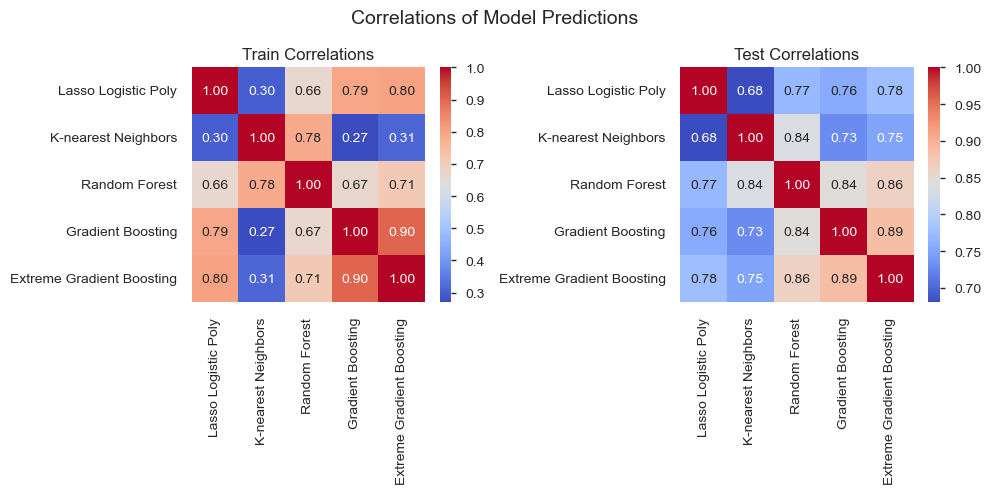

In [109]:
# plot correlations between predictions
utl.plot_predictions_corr(estimators, data)

In [110]:
# define meta-model
stc = StackingClassifier(
    estimators=estimators, 
    final_estimator=GradientBoostingClassifier(random_state=109), 
    cv=CV_FOLDS
)

start_time = time.time()

# fit meta-model
stc.fit(X_train_transformed.values, y_train.values)

end_time = time.time()
print(f"Model fitting time: {end_time - start_time:.1f} seconds")

Model fitting time: 94.0 seconds


In [111]:
# save metrics for stacked model
data = (X_train_transformed, X_test_transformed, y_train, y_test)
results.append(utl.get_performance_metrics(stc, 'Stacked Model', data))
utl.get_results_df(results, model='Stacked Model')

model partition                     metric  value
6    Stacked Model     Train   Readmitted-Rate-Observed   4.96
13   Stacked Model     Train  Readmitted-Rate-Predicted   5.61
20   Stacked Model     Train             Naive-Accuracy  95.04
27   Stacked Model     Train                   Accuracy  83.62
34   Stacked Model     Train                    AUC-ROC  99.67
41   Stacked Model     Train                     AUC-PR  89.98
48   Stacked Model     Train                   F1-Score  37.70
55   Stacked Model     Train         Recall-Sensitivity 100.00
62   Stacked Model     Train                Specificity  82.76
69   Stacked Model     Train                  Precision  23.23
76   Stacked Model      Test   Readmitted-Rate-Observed   4.96
83   Stacked Model      Test  Readmitted-Rate-Predicted   4.98
90   Stacked Model      Test             Naive-Accuracy  95.04
97   Stacked Model      Test                   Accuracy  72.10
104  Stacked Model      Test                    AUC-ROC  71.89
111  Stacked Model      Test                     AUC-PR  12.86
118  Stacked Model      Test                   F1-Score  17.00
125  Stacked Model      Test         Recall-Sensitivity  57.64
132  Stacked Model      Test                Specificity  72.86
139  Stacked Model      Test                  Precision   9.97

<a name="5.-Model-Selection-and-Interpretation"></a>
# 5. Model Selection and Interpretation

[Return to top](#Notebook-Contents)

In this section, we evaluate the performance of our six candidate models and select the best model for further scrutiny and interpretation.

<a name="5.1.-Model-Selection"></a>
## 5.1 Model Selection

[Return to top](#Notebook-Contents)

### Performance Metrics for Train and Test Sets

In our current use-case, the cost of false negatives (i.e., patients predicted to not be readmitted early who actually would be) is much higher than the cost of false positives (i.e., patients predicted to be readmitted early who actually would not be). Since we want to minimize false negatives, we want to maximizing sensitivity (aka recall), while still maintaining reasonable levels of specificity and precision.

Our primary model performance metric was therefore the area under the Receiver Operating Characteristic (AUC-ROC) curve, which quantifies the overall ability of the model to discriminate between positive and negative classes, regardless of class imbalance, with higher values indicating better performance. We also used calibration, the level of agreement between the observed frequencies and predicted probabilities of the target variable, as a secondary metric. However, for completeness, here we report a larger suite of commonly used performance metrics.

The best models in terms of test set AUC-ROC were the `XGBoost` (71.9%) and Stacked Ensemble models (71.9%). However, the latter exhbited a much larger discrepancy between training (78.5% for `XGBoost`, 99.7% for Stacked Ensemble) and testing set AUC-ROC, indicting a lack of generalizability. Both models showed good calibration on the test set. In light of these results, we therefore selected the `XGBoost` model as the best out of our six candidates. 

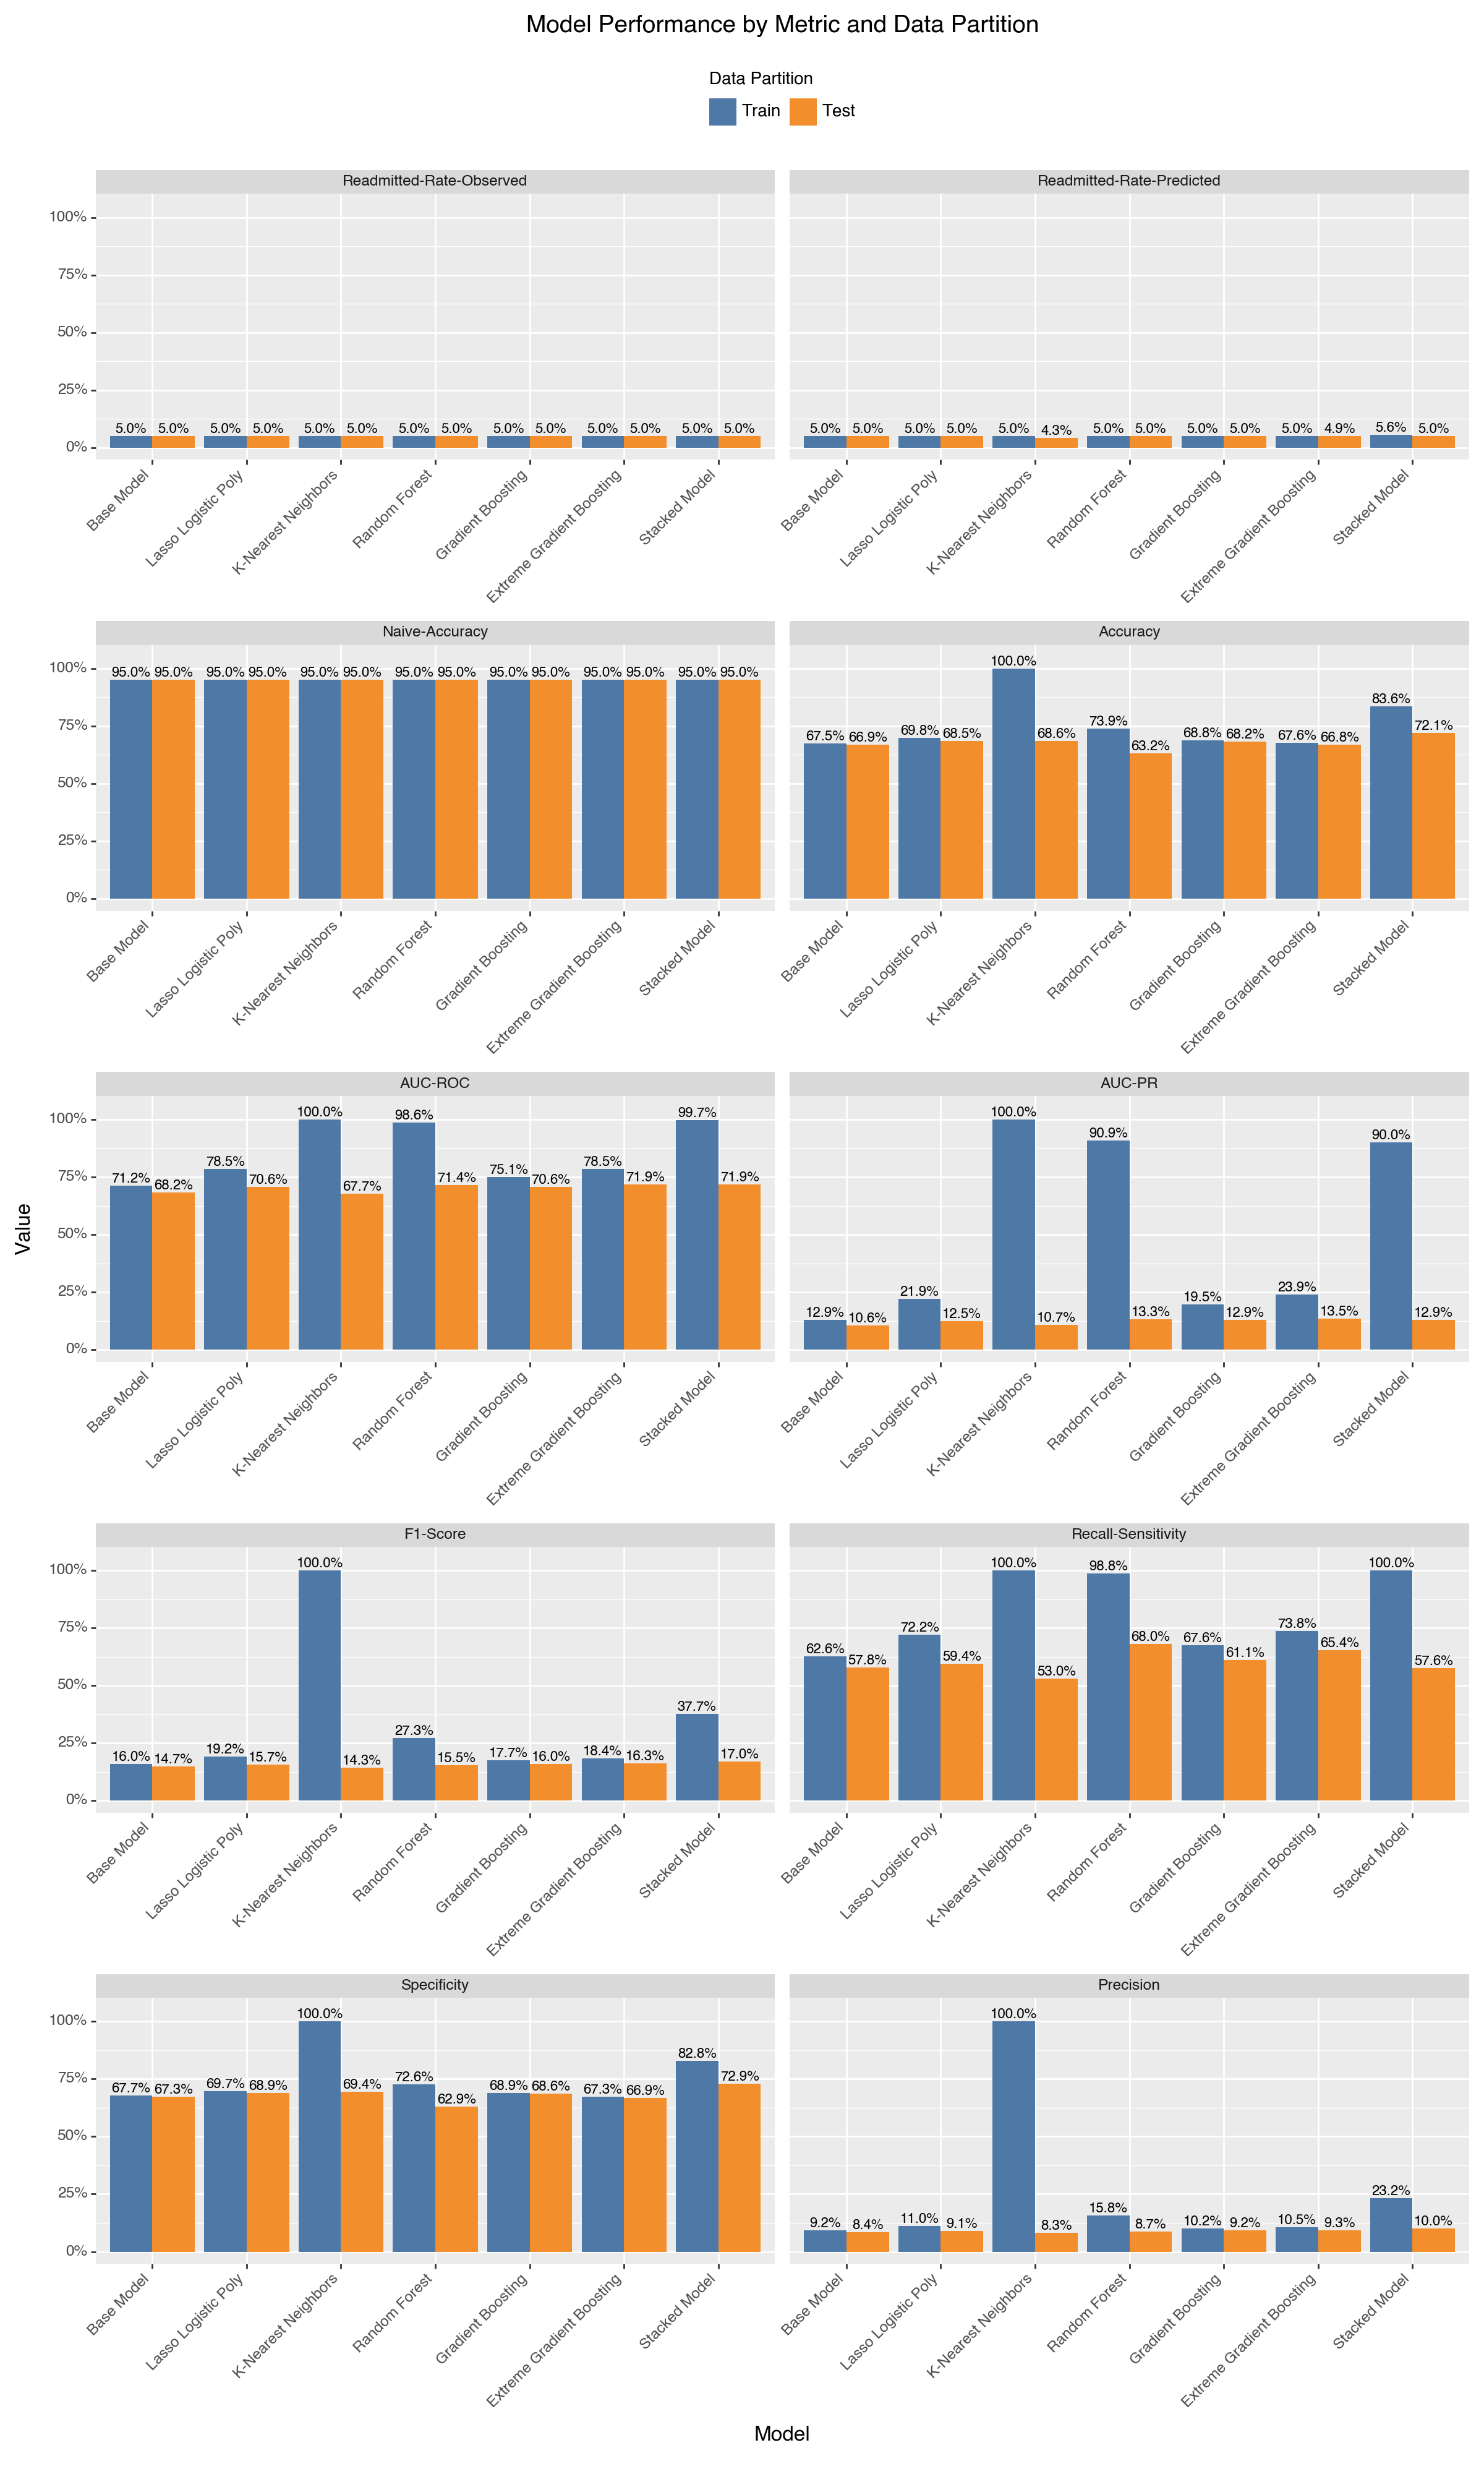

In [112]:
# collect all training and testing set metrics in a data frame
results_df = utl.get_results_df(results)

# order to plot the models
model_order = ['Base Model', 'Lasso Logistic Poly', 'K-Nearest Neighbors', 'Random Forest',    
               'Gradient Boosting', 'Extreme Gradient Boosting', 'Stacked Model']

# plot model performance metrics
utl.plot_performance_metrics(results_df, model_order=model_order)

### AUC-ROC for Train and Test Sets

The Receiver Operating Characteristic (ROC) curve provides insight into the performance of the classification models at various threshold settings. It plots the True Positive Rate (Recall) against the False Positive Rate for different threshold values and characterizes the trade-off between correctly classifying the positive class and the rate of incorrectly classifying negative instances as positive. A model that perfectly distinguishes between the two classes will have a ROC curve that hugs the top left corner, indicating a high true positive rate and a low false positive rate. 

The visualization of the ROC curves for our six candidate models confirms our previous observations from the AUC-ROC metrics. The `XGBoost` model either dominates or at least matches the other models across the whole range of ROC values. In addition, we see that the Stacked Ensemble model massively overfits the training data, while `XGBoost` has much more comparable performance on both train and test sets. This gives us greater confidence in the ability of the `XGBoost` model to perform well on new data.

In [113]:
# dict of model names and classifiers for plotting curves
models = {
    'Base Model': base_model,
    'Lasso Logistic Poly': llr_poly,
    'K-Nearest Neighbors': knn,
    'Random Forest': rf,
    'Gradient Boosting': gb,
    'Extreme Gradient Boosting': xgb,
    'Stacked Model': stc
}

# data
data = (X_train_transformed, X_test_transformed, X_train_transformed_poly,  
        X_test_transformed_poly, X_train_full_xgb, X_test_xgb, y_train, y_test)

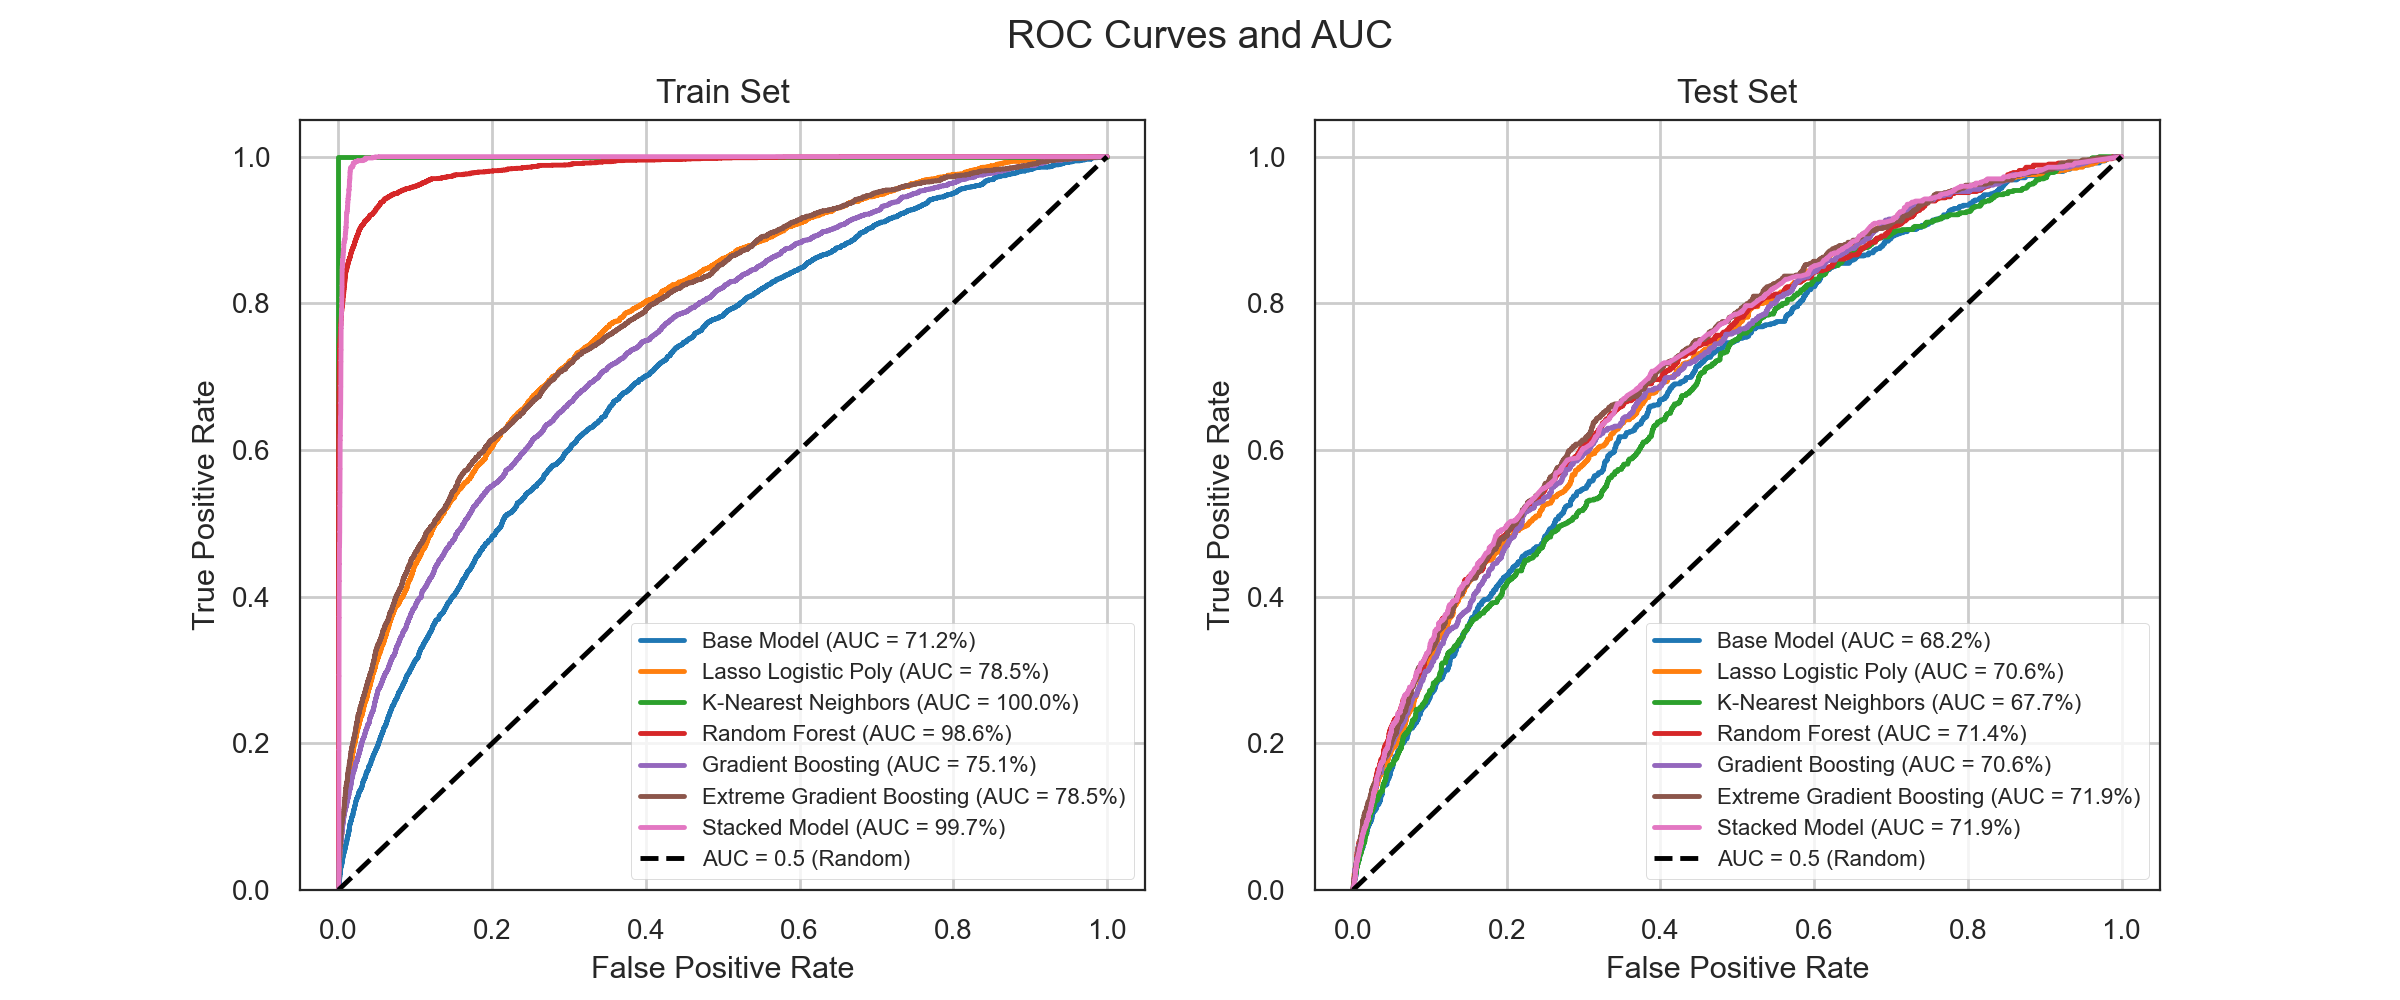

In [114]:
# ROC Curve
utl.plot_ROC_curves(models, data)

### AUC-PR for Train and Test Sets

The area under the precison-recall (AUC-PR) curve provides single measure of a model's ability to correctly predict the positive class while distinguishing it from the negative class. The precision-recall curve itself provides insight into the trade-off between precision (the proportion of true positives among all positive predictions) and recall (the proportion of true positives that were correctly identified by the model) across different thresholds. This curve can be useful in evaluating models for imbalanced datasets like ours, where positive cases are much fewer than negative ones, as it focuses on the performance of the model in predicting the positive class correctly. 

Unfortunately, for our data set, none of the models performed very well on the test set in terms of AUC-PR, meaning that we have to settle for either high levels of recall or precision, but not both.

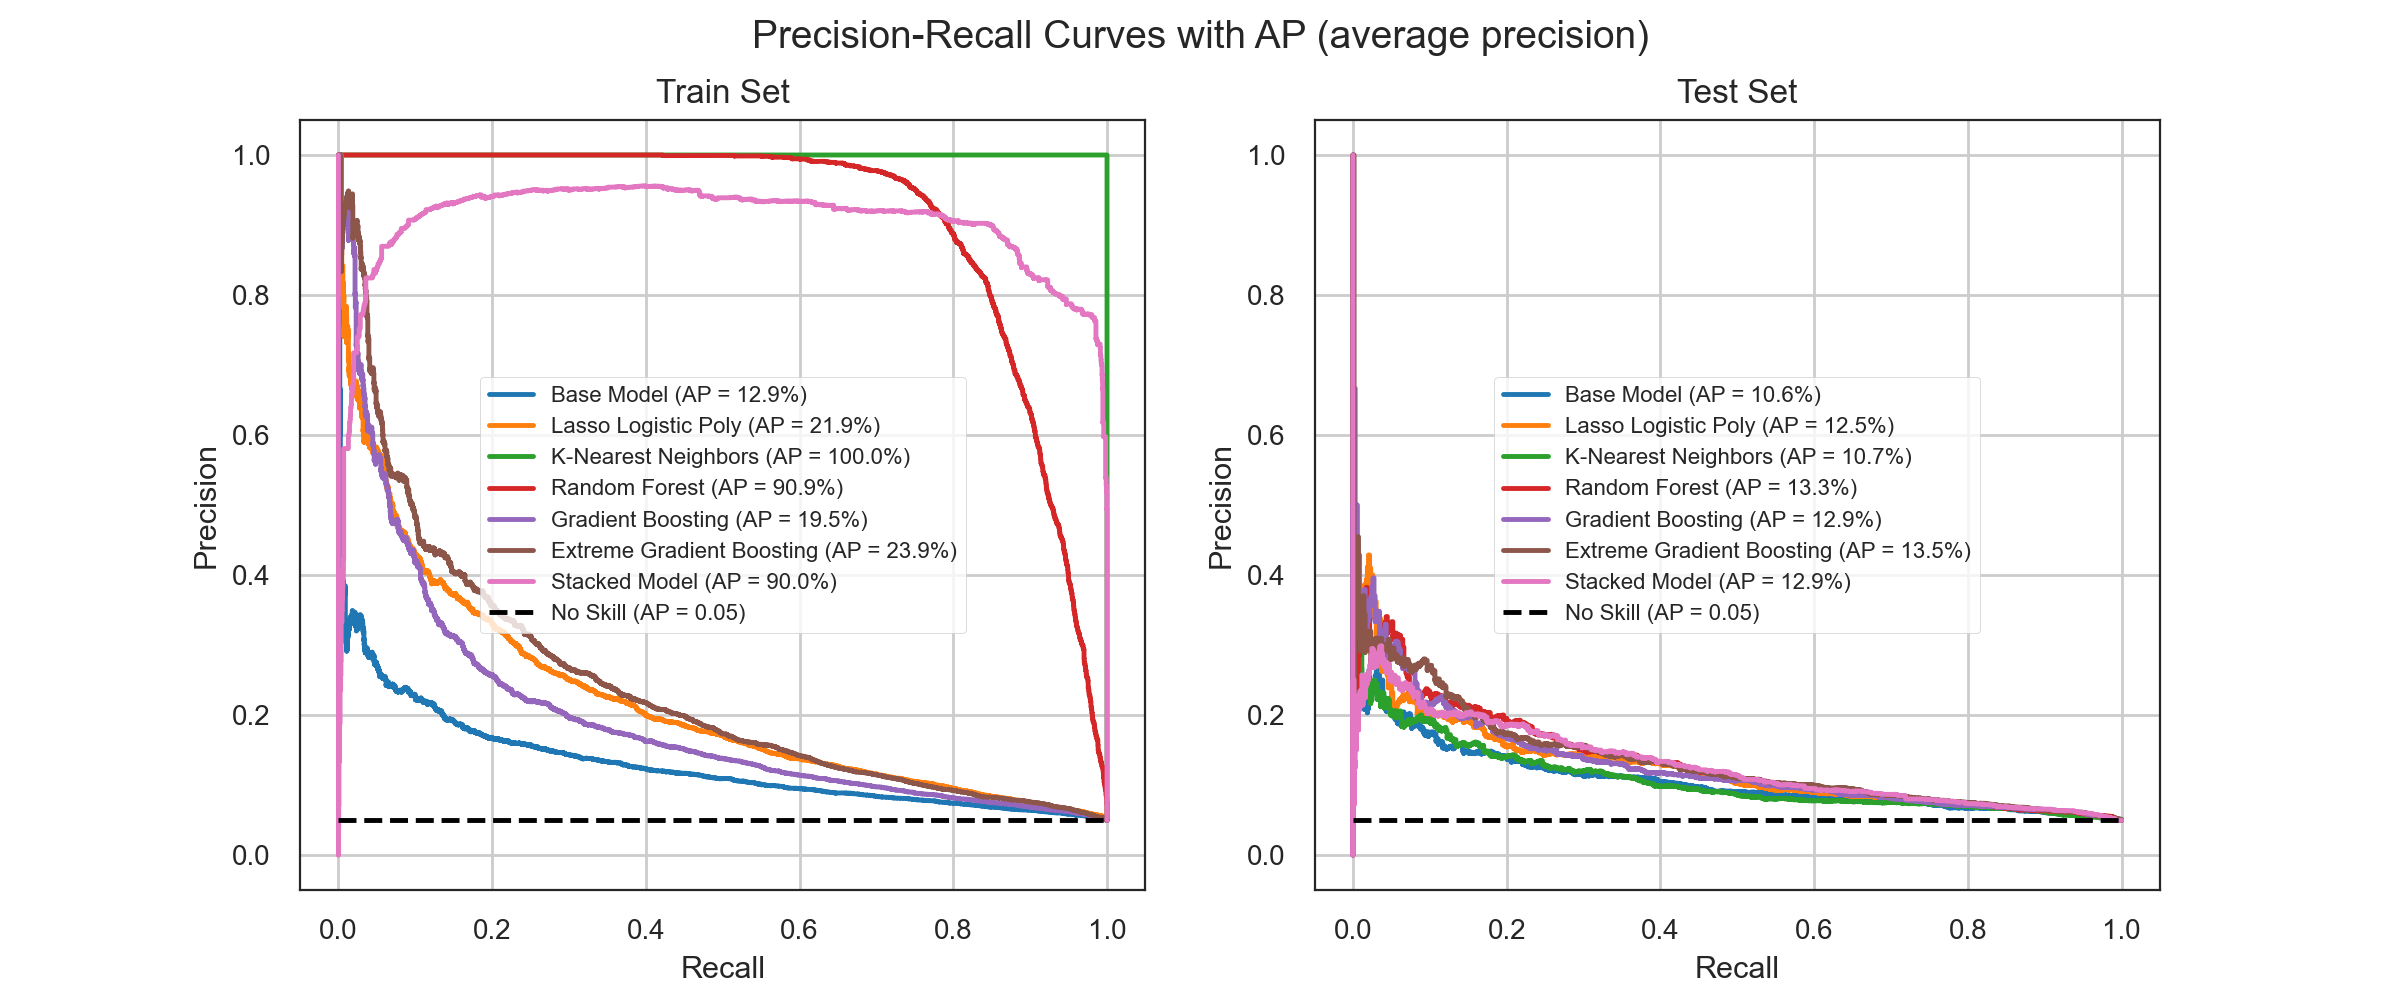

In [115]:
# Precision Recall Curve
utl.plot_PR_curves(models, data)

<a name="5.2.-Best-Model-Interpretation"></a>
## 5.2 Best Model Interpretation

[Return to top](#Notebook-Contents)

In the previous section, we selected the `XGBoost` model as the best from our six candidate models for its performance with AUC-ROC and calibration on the test set. We will now investigate which features were most important in driving model predictions using permutation importance and interpret these using SHAP values with respect to patient risk profiles.

### Distribution of Probabilities of Readmission

It is useful to look at the distribution of the predicted probabilities from the model. This helps us form our initial recommendation to the client: Medical Team should prioritize interventions or follow-ups for the 34% of patients predicted to have a higher chance than average (5%) of being readmitted early. Also, the probability distribution produced by the model in production should be monitored over time. Changes in this distribution would indicate that the model needs to be retrained.

'Min/Max: 0.004000000189989805, 0.5989999771118164'

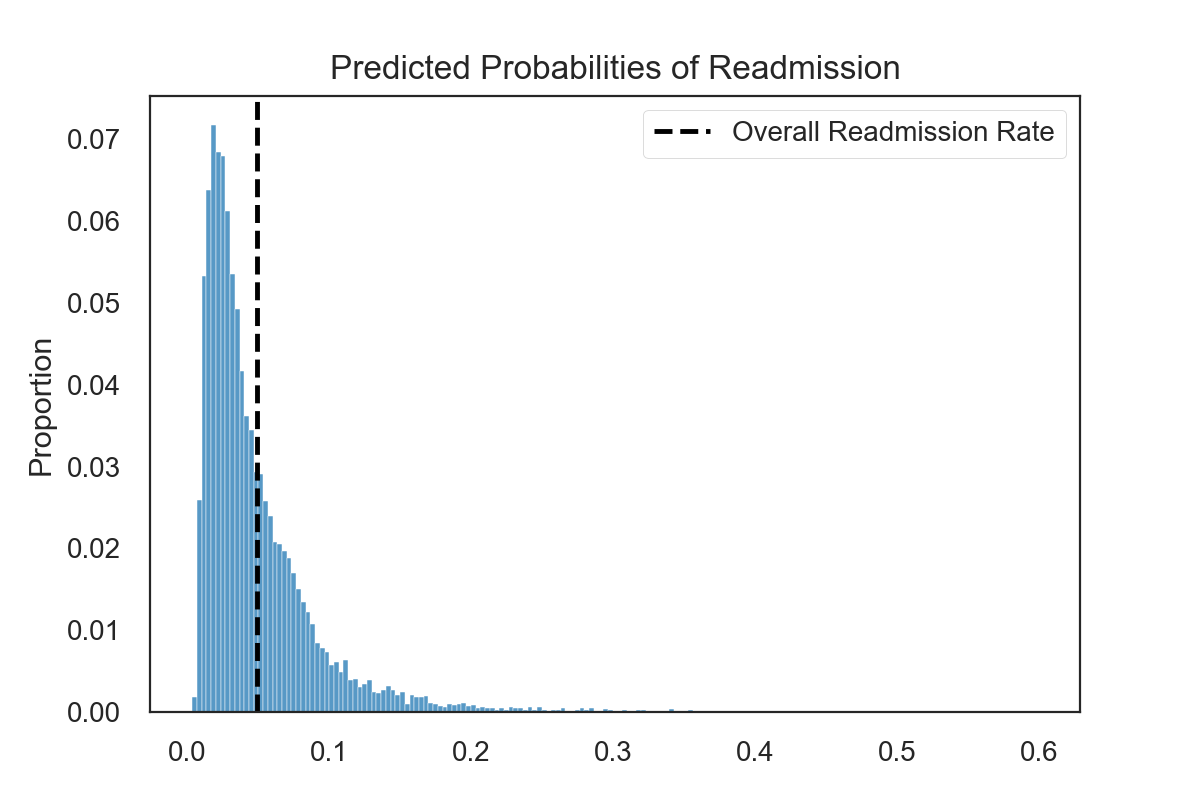

In [116]:
y_test_prob = xgb.predict_proba(X_test_xgb)[:,1]
display(f'Min/Max: {round(np.min(y_test_prob),3)}, {round(np.max(y_test_prob),3)}')

plt.figure(figsize=(6, 4))
ax = sns.histplot(y_test_prob, stat='proportion');
ax.axvline(x=y_test_prob.sum()/y_test_prob.shape[0],linestyle='--',color='black',
           label='Overall Readmission Rate')
ax.set_title('Predicted Probabilities of Readmission')
ax.legend();

### Model Calibration

Note that the recommendation above (that we should prioritize patients with above average overall readmittance rate of 5%) is reliable only if the probabilities predicted by the model are reliable. So not only do we want the model to reasonably rank patients in terms of risk (measured by AUC-ROC) but we also want the model to output probabilities close to actuals (calibration). See another example of how looking at calibration can be useful (towards the end of the notebook) in determining how fair the machine learning model is. The two graphs below show that the model is reasonably well calibrated. In the bar chart on the left, note that each of the bars (predicted vs. actual for that decile) is close to each other. In the kernel density plot on the right, the distributions are close to each other.

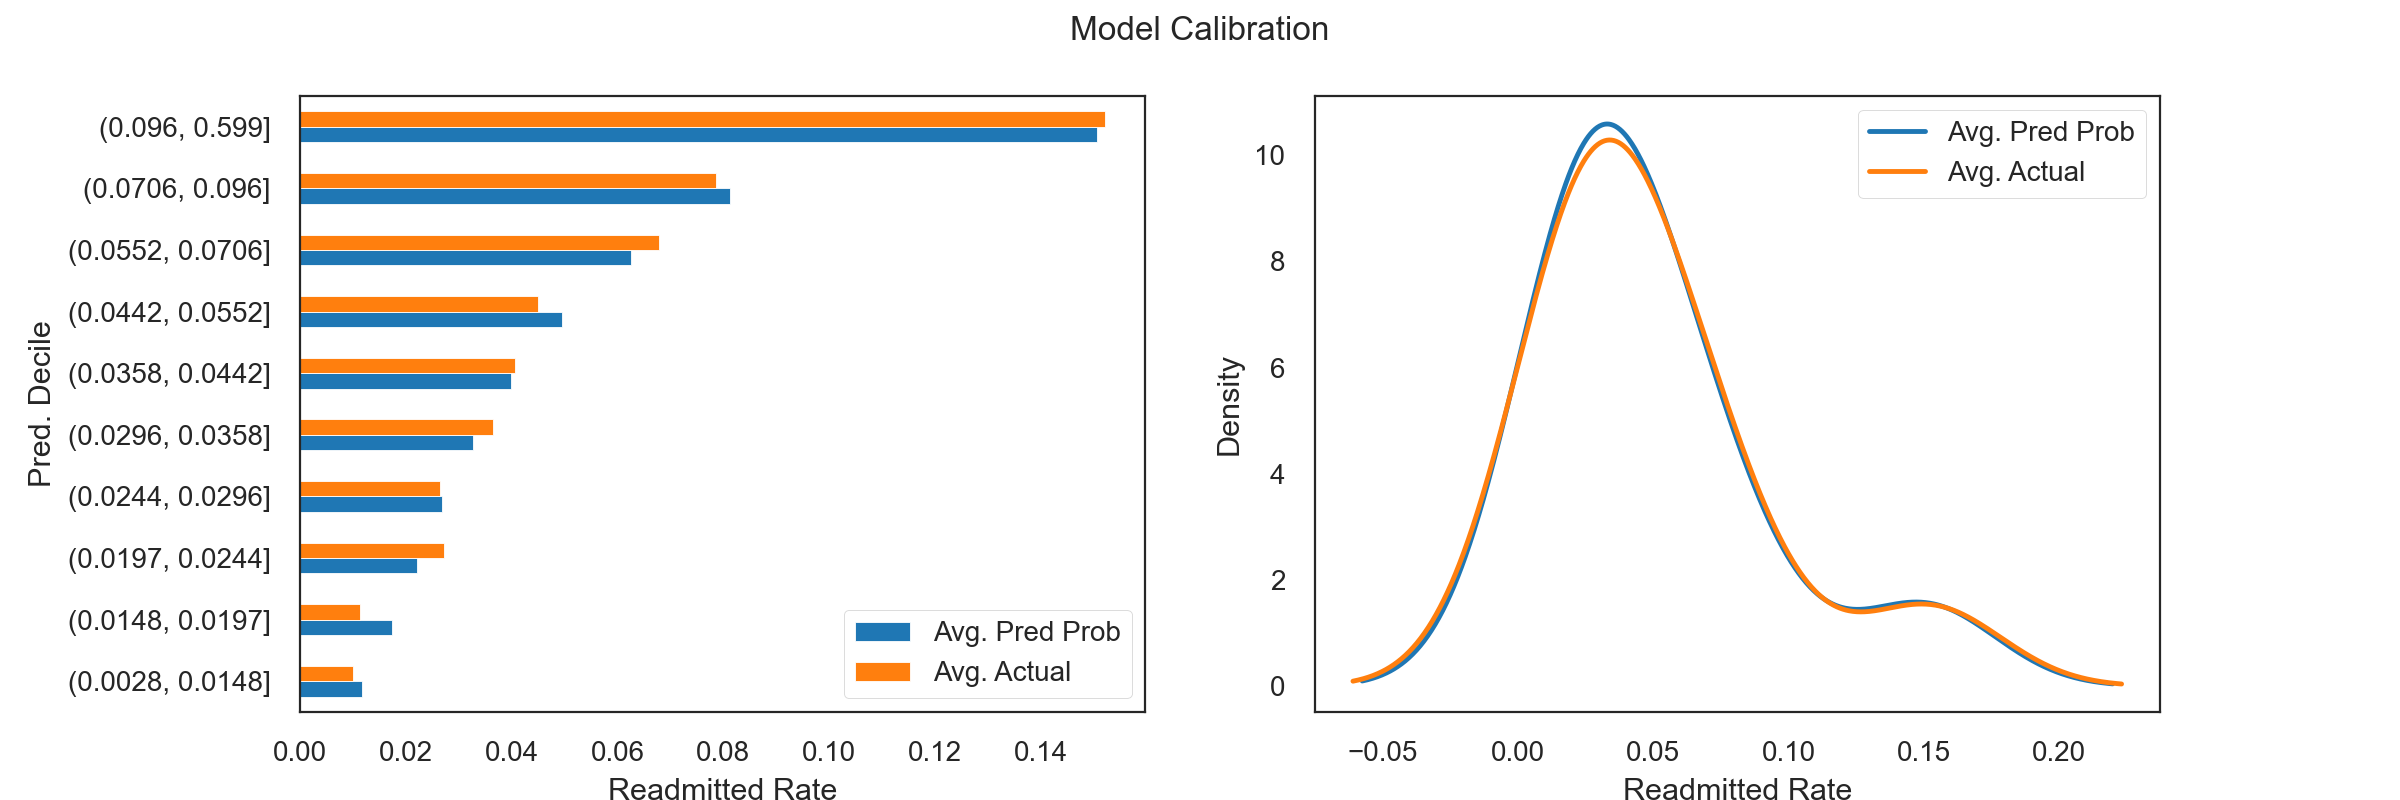

In [117]:
# calculate predicted probabilities by deciles
by_decile_df = utl.by_deciles(y_test_xgb, y_test_prob)

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
by_decile_df.plot(x='Pred. Decile',y=['Avg. Pred Prob','Avg. Actual'],kind='barh',
                  ax=axes[0])
by_decile_df.plot(x='Pred. Decile',y=['Avg. Pred Prob','Avg. Actual'],kind='kde',
                  ax=axes[1])
axes[0].set_xlabel('Readmitted Rate')
axes[1].set_xlabel('Readmitted Rate')
fig.suptitle('Model Calibration');

### Permutation Importance versus Shap Values

To interpret the model, we look at feature importance from both permutation importance and shap values. Top features associated with risk of being readmitted early include demographic factors (age and race), medical history (number of previous inpatient visits, number of current conditions, etc.), as well as where the patient is discharged to (home, nursing home, etc.). Permutation importance and Shap feature importance generally agree in the top features associated with a high risk patient, with some feature reordering between the two methods. 

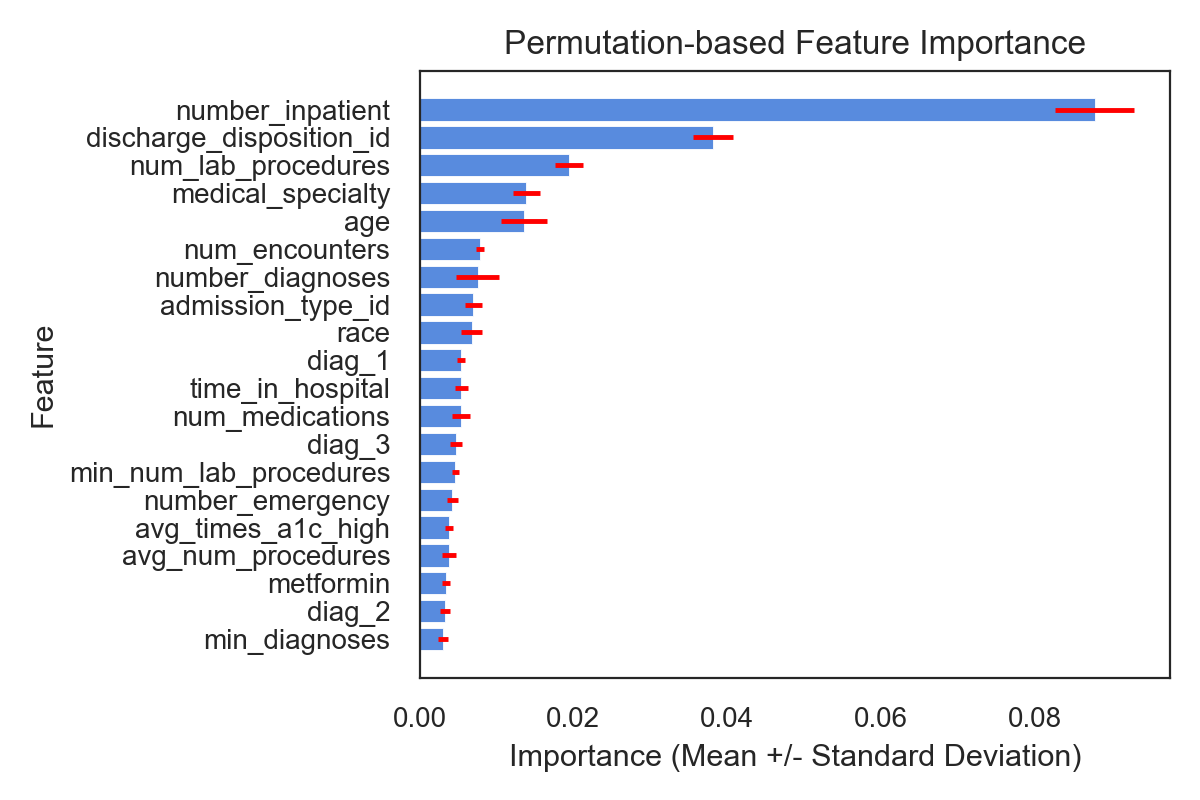

In [118]:
# permutation importance
utl.plot_feature_imp_perm(xgb, X_train_full_xgb, y_train_full_xgb)

Shap values provide additional useful information such as how feature value affects risk. For example, high age values and numbers of inpatient visits (red) are associated with high Shap values, which suggests elderly patients and those that have repeatedly visited hospital in the previous year are at higher risk of early hospital readmittance.

 98%|===================| 55060/55992 [00:52<00:00]        

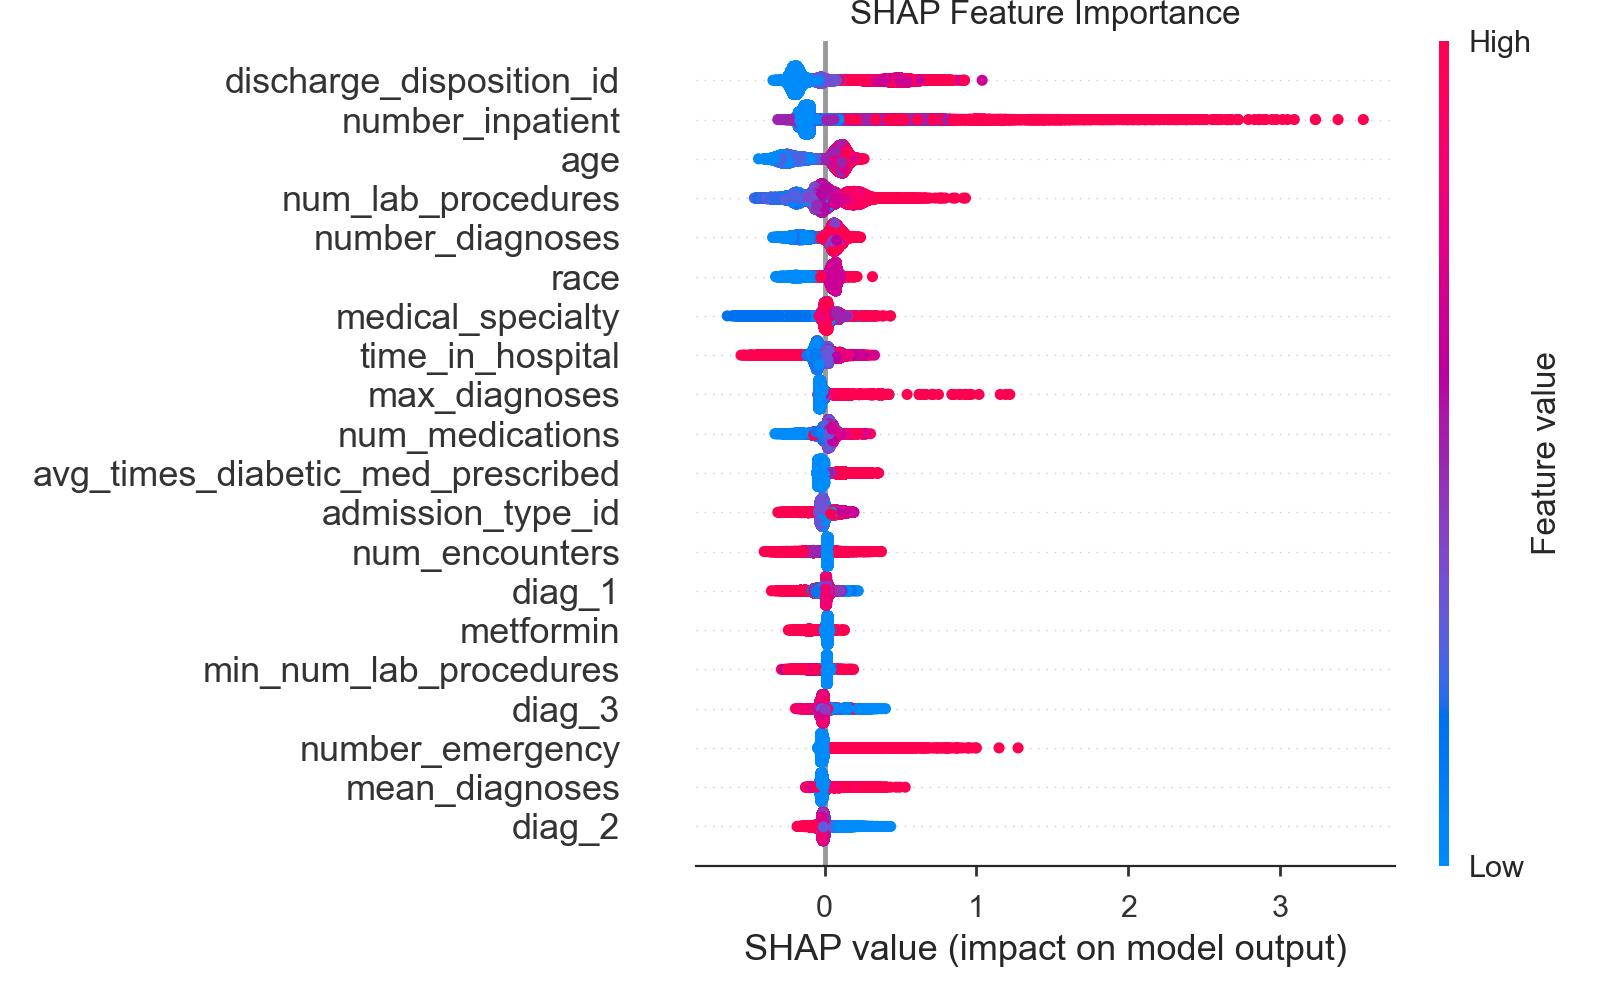

In [119]:
# SHAP value variable importance
shap_values = utl.get_shap_values(xgb, X_train_full_xgb)

### Discharge Disposition

Patients discharged to skilled nursing facilities (SNF) are at higher risk (above 0 SHAP values) than those discharged to their homes (below 0 SHAP values).

{0: 'Home', 1: 'Home w/ Service', 2: 'Other', 3: 'SNF'}

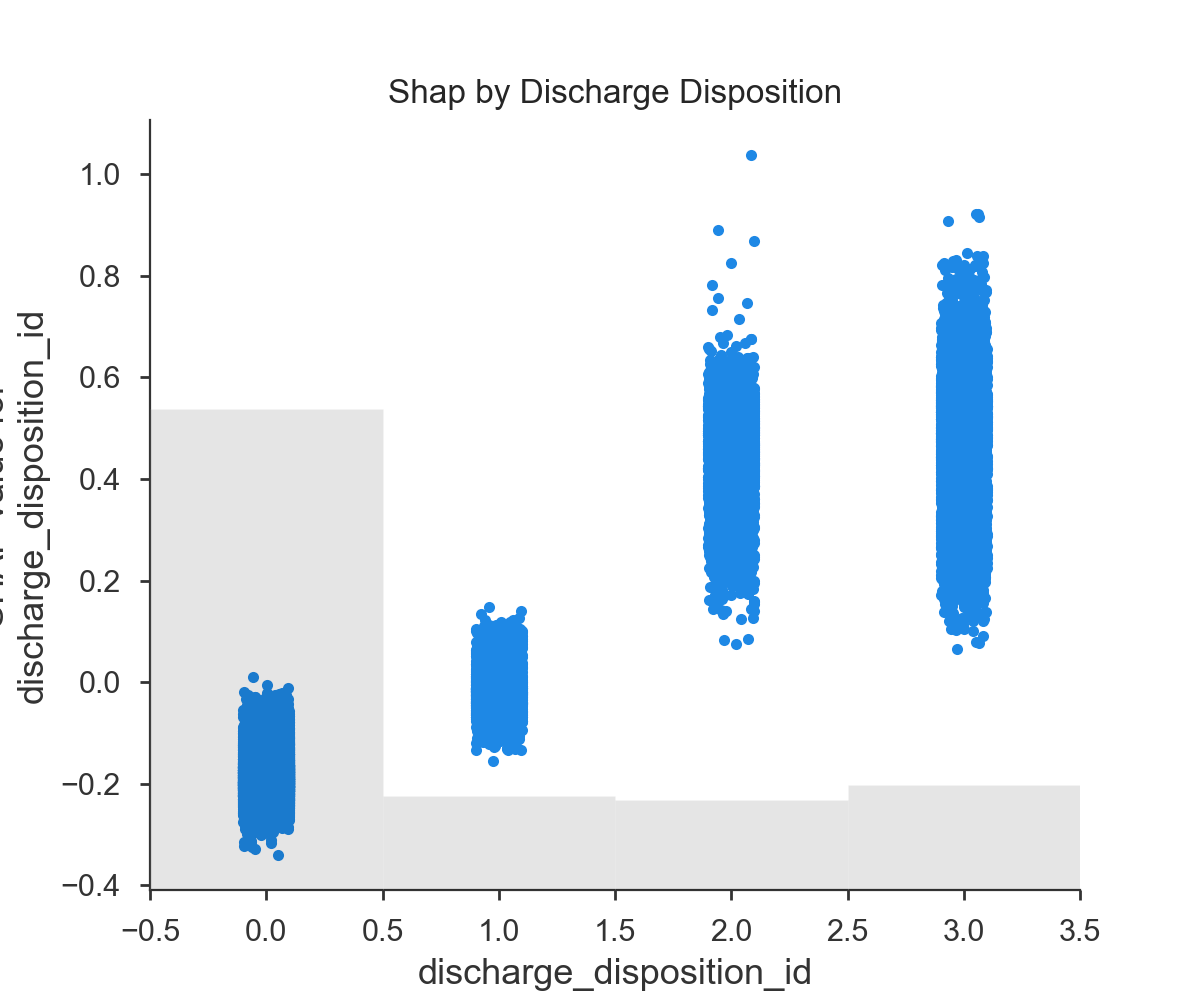

In [120]:
display(cat_to_codes['discharge_disposition_id'])
shap.plots.scatter(shap_values[:,'discharge_disposition_id'], show=False)
plt.title('Shap by Discharge Disposition')
plt.show()

### Number of In-patient Visits in Preceding Year

The higher the number of in-patient visits in the preceding year, the greater the chances of being readmitted early (since the SHAP values positively slope with increased value of visits).

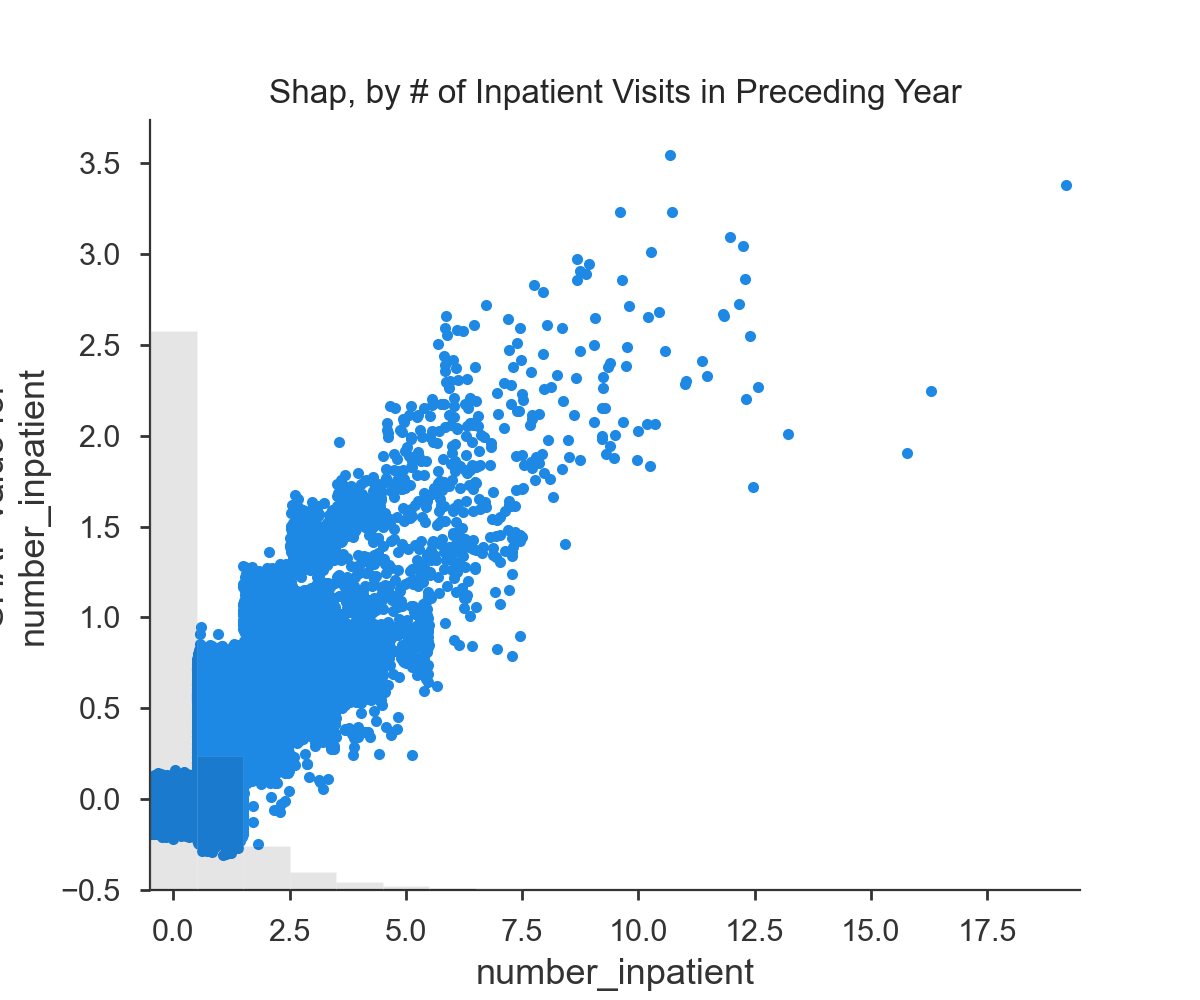

In [121]:
shap.plots.scatter(shap_values[:,'number_inpatient'],x_jitter=1, show=False)
plt.title('Shap, by # of Inpatient Visits in Preceding Year')
plt.show();

### Age

Not surprisingly, risk of early remittance increases with age for patients older than 60 (>0 Shap values).

{0: '[0-50)', 1: '[50-60)', 2: '[60-70)', 3: '[70-80)', 4: '[80-100)'}

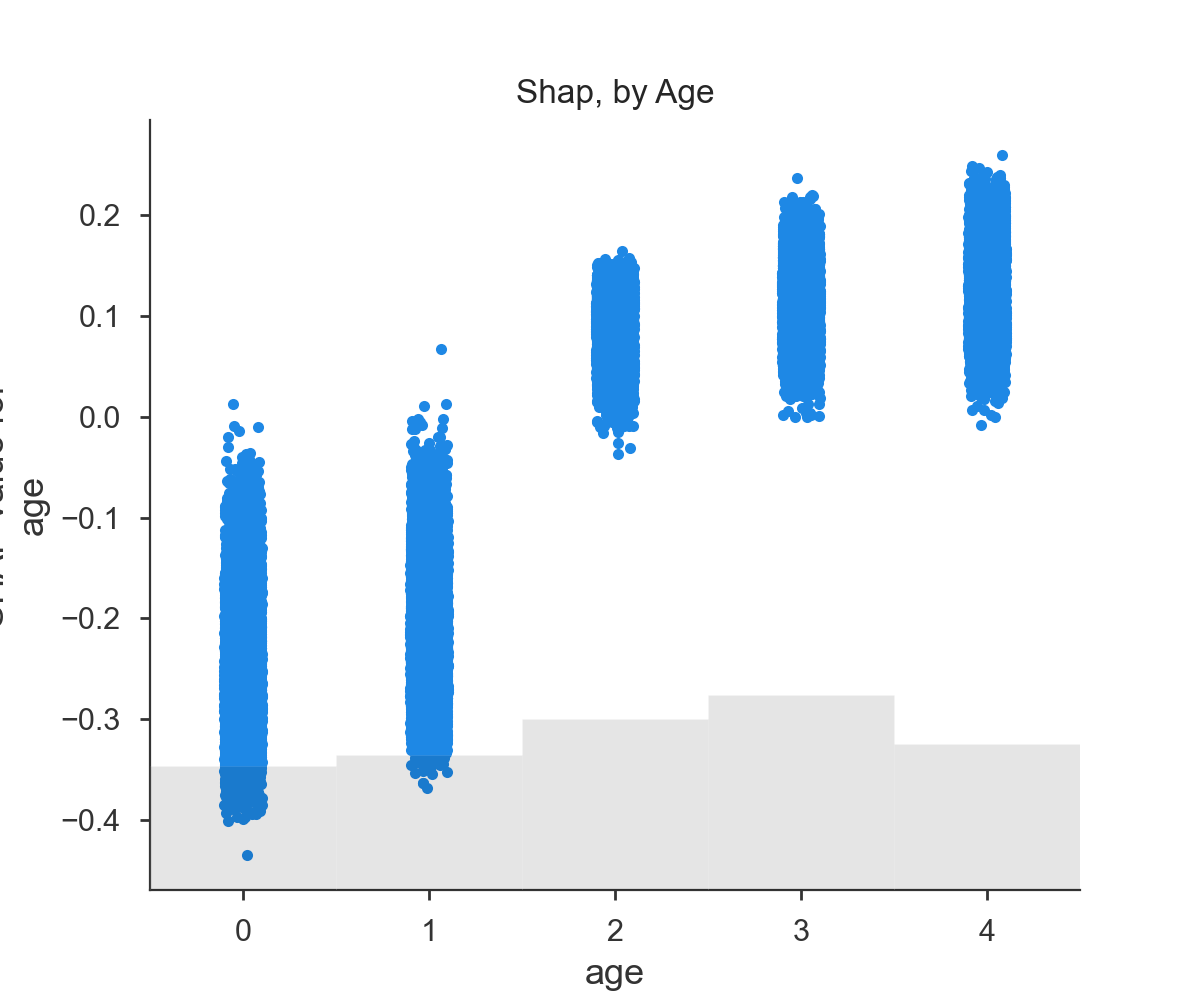

In [122]:
display(cat_to_codes['age'])
shap.plots.scatter(shap_values[:,'age'],show=False)
plt.title('Shap, by Age')
plt.show()

### Number of Diagnoses by Age Group

Risk increases with increasing number of existing conditions until about 7 conditions after which point the risk plateaus. Also, note that there is an interaction with age: unless a patient is older than 60, having fewer than four diagnoses reduces the risk of early readmittance.

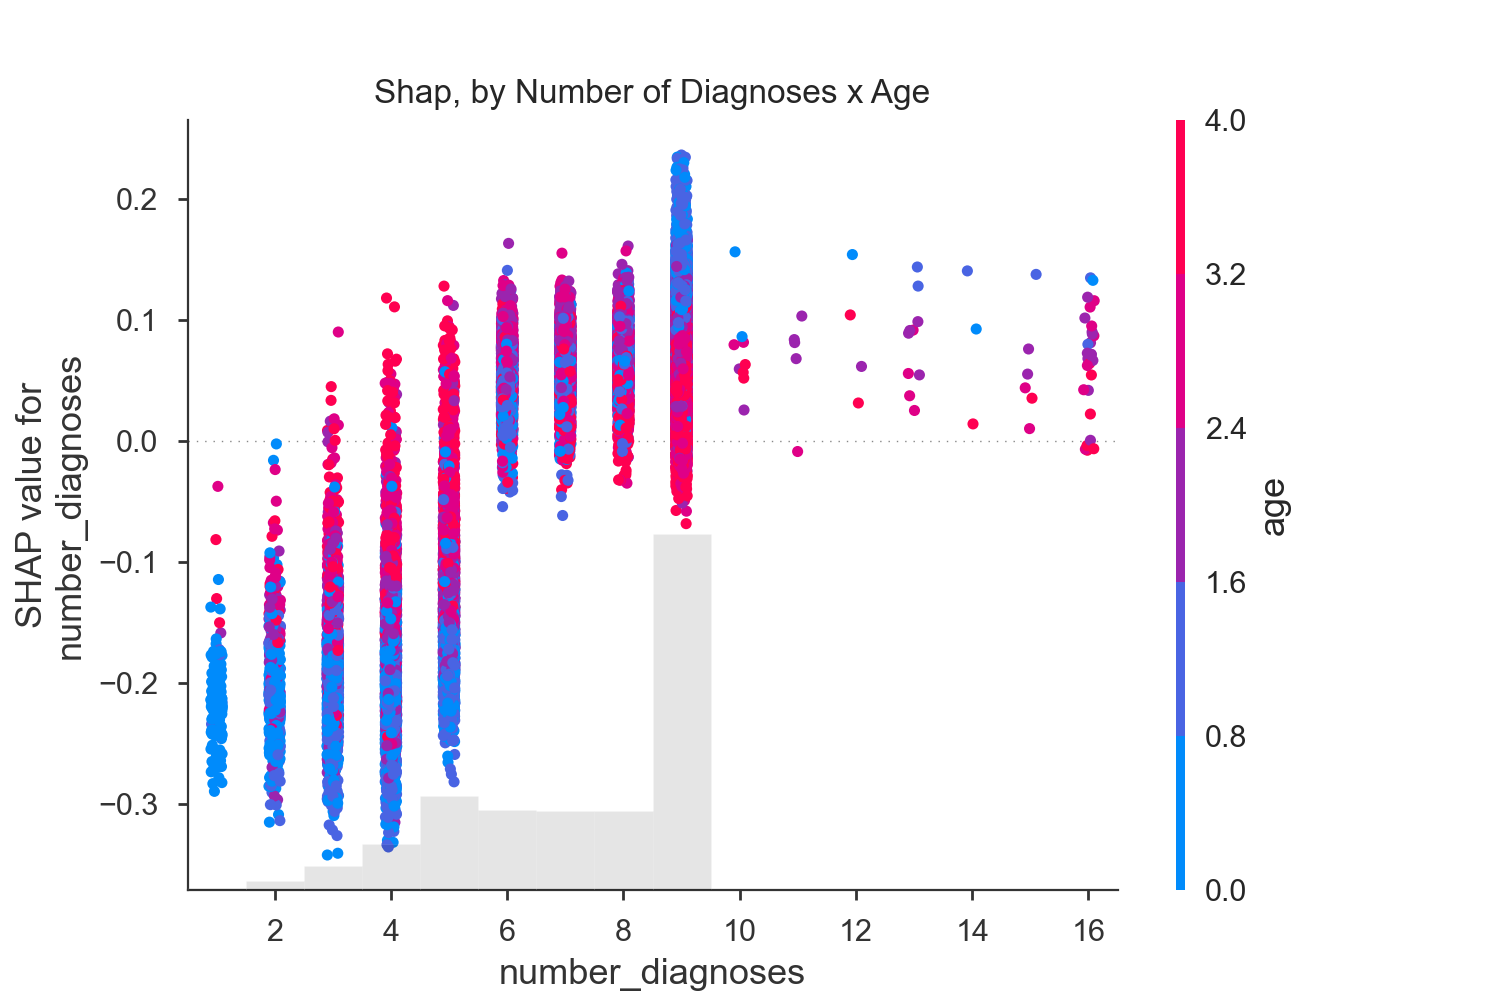

In [123]:
shap.plots.scatter(shap_values[:,'number_diagnoses'],
                   color=shap_values, show=False)
plt.title('Shap, by Number of Diagnoses x Age')
plt.show()

### Machine Learning Model Fairness

While African American patients are generally less likely to be readmitted early based on Shap values, the model is not as well calibrated for them as it is for Caucasians, leading to meaningful under-predictions for the former group in some cases.

Specifically, the bulk of Shap values for African American patients are well below zero, suggesting that they are the least likely to be readmitted early and should not be prioritized for interventions, relative to patients of other races, including Caucasians who are disproportionately over-represented in this dataset.

However, the model is not as well calibrated for African Americans as it is for Caucasians, with meaningful under-predictions in deciles with probabilities 2%-3%. This noise is likely caused by training the model on a disproportionately smaller number of examples with African Americans.

{0: 'AfricanAmerican',
 1: 'Asian',
 2: 'Caucasian',
 3: 'Hispanic',
 4: 'Other',
 5: 'UNK'}

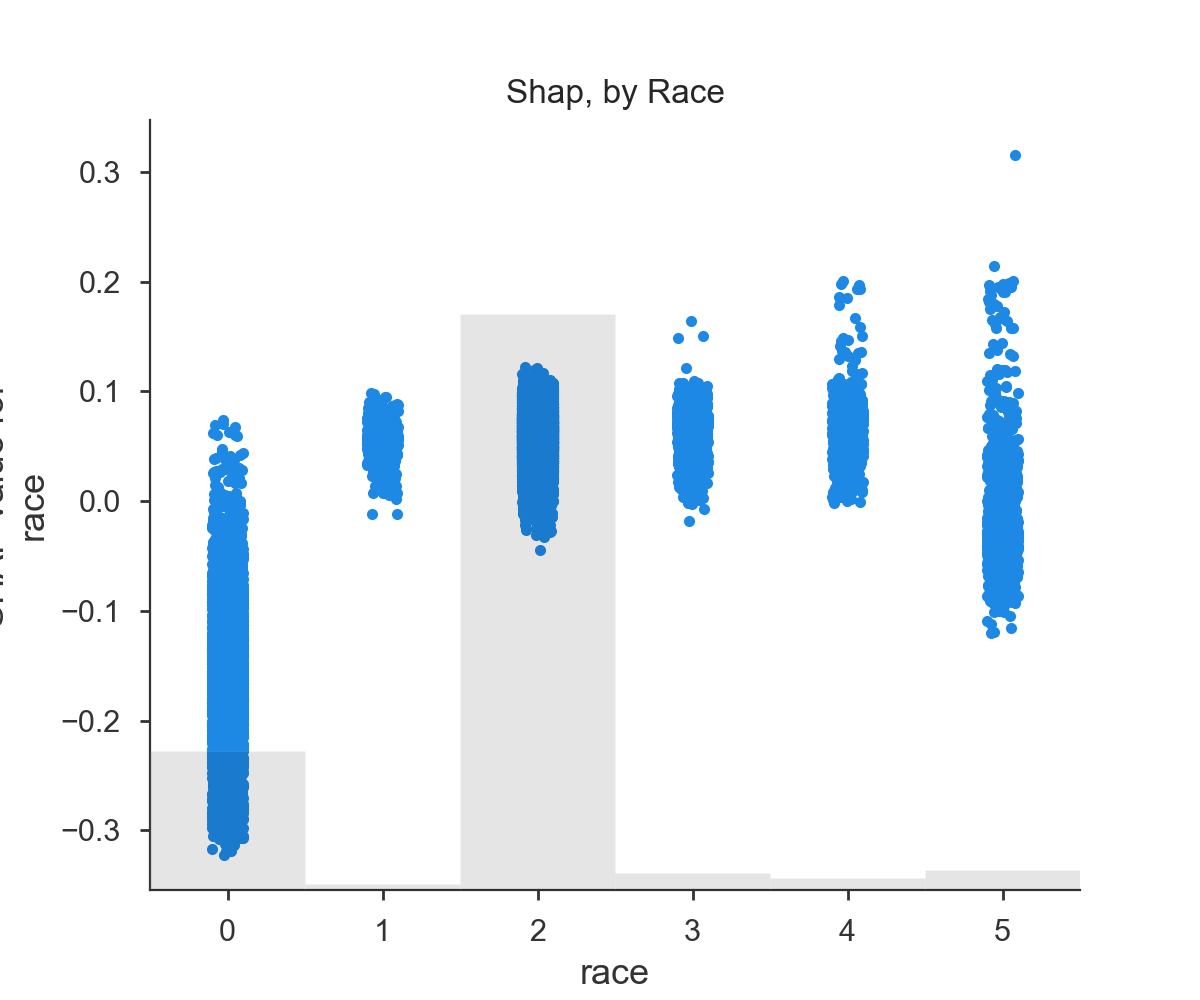

In [124]:
display(cat_to_codes['race'])
shap.plots.scatter(shap_values[:,'race'],show=False)
plt.title('Shap, by Race')
plt.show()

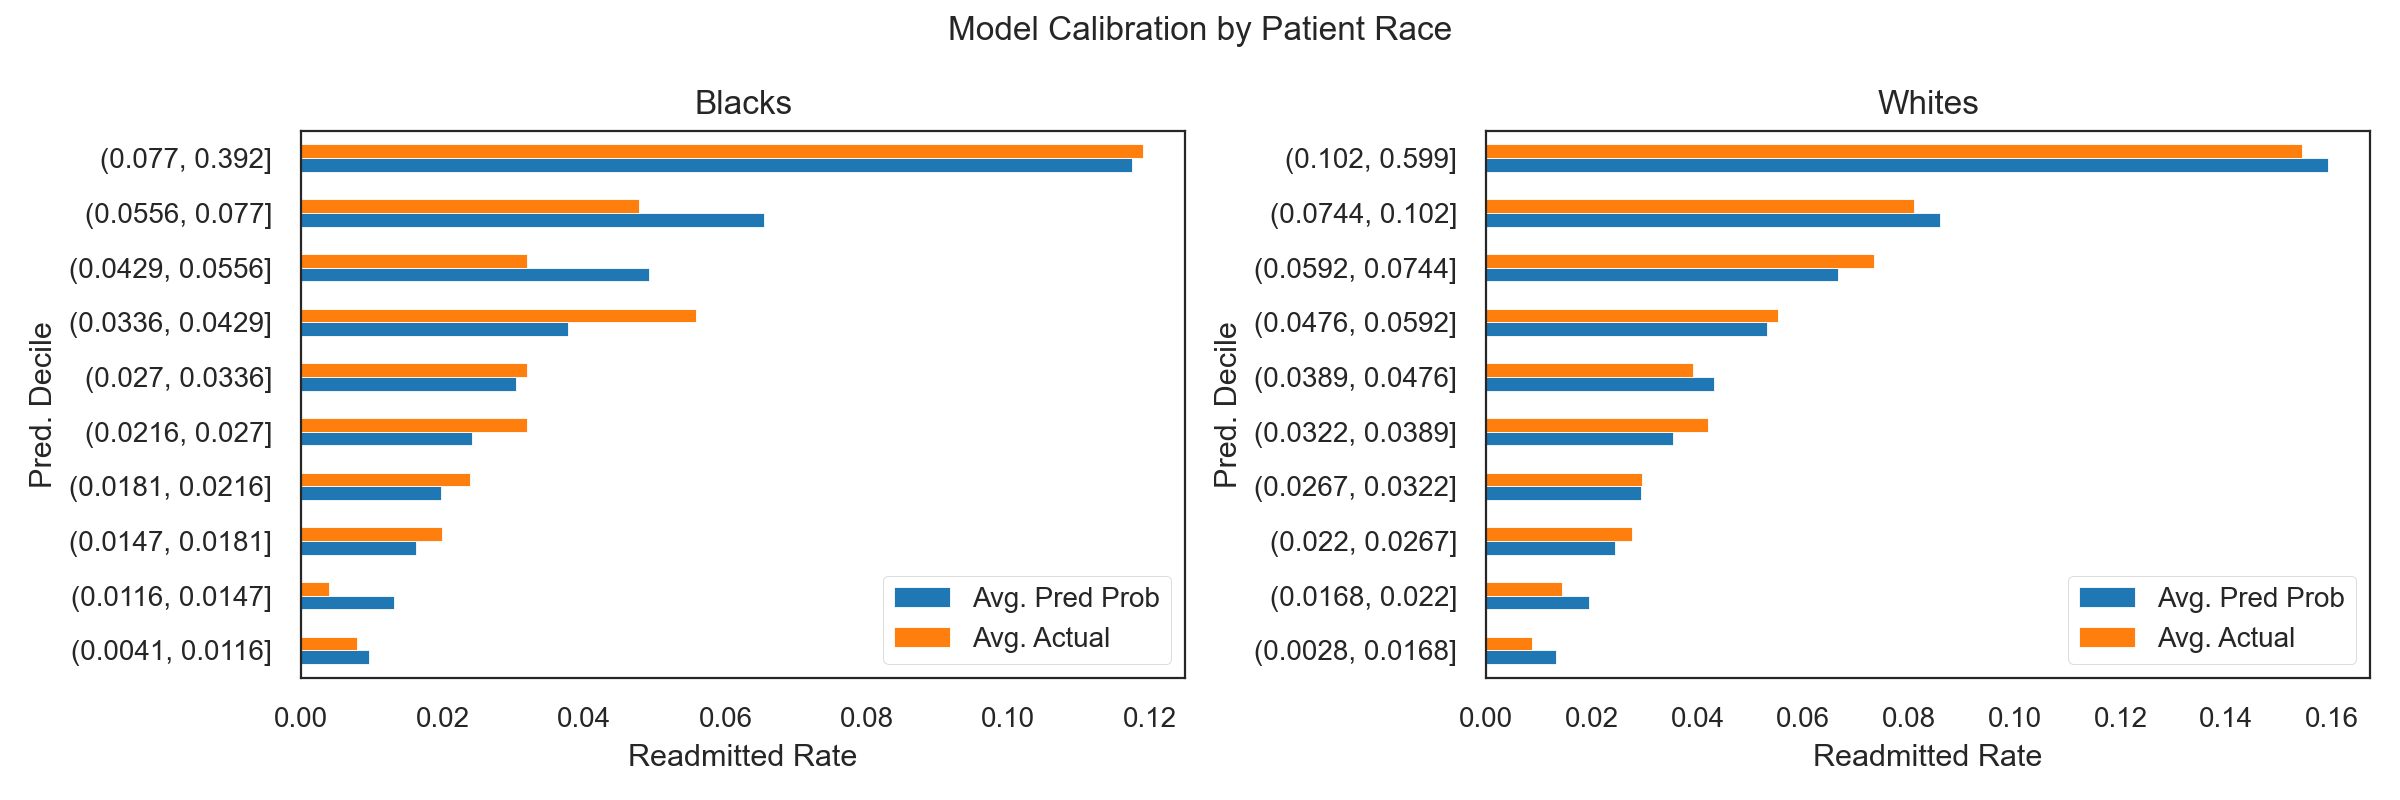

In [125]:
black_by_decile_df = utl.by_deciles(y_test[X_test_xgb['race']==0],y_test_prob[X_test_xgb['race']==0])
white_by_decile_df = utl.by_deciles(y_test[X_test_xgb['race']==2],y_test_prob[X_test_xgb['race']==2])

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
black_by_decile_df.plot(x='Pred. Decile',y=['Avg. Pred Prob','Avg. Actual'],kind='barh',
                  ax=axes[0]).set_title('Blacks')
white_by_decile_df.plot(x='Pred. Decile',y=['Avg. Pred Prob','Avg. Actual'],kind='barh',
                  ax=axes[1]).set_title('Whites')
axes[0].set_xlabel('Readmitted Rate')
axes[1].set_xlabel('Readmitted Rate')
fig.suptitle('Model Calibration by Patient Race')
plt.tight_layout();

<a name="6.-Conclusions"></a>
# 6. Conclusions

[Return to top](#Notebook-Contents)

Our major findings from this study of the early readmittance rates of diabetes patients in US-based hospital are:

1. After experimenting with several different classifiers, we were able to achieve an AUC-ROC of 71.9% on the test set using an extreme gradient boosting model. This model exhibited the least amount of overfitting out of our candidate models (78.5% AUC-ROC on the training set) and was well-calibrated (4.94% predicted early readmittance vs. 4.96% actual).

2. Clinicians should prioritize interventions or follow-ups for the 34% of patients predicted to have a higher chance than average (5%) of being readmitted early.

3. Top features associated with risk of being readmitted early include demographic factors (age and race), medical history (number of previous inpatient visits, number of current conditions, etc.), as well as where the patient is discharged to (home, nursing home, etc.). 

4. Patients discharged to Skilled Nursing Facilities (SNF) seem to be at high risk of being readmitted early. Follow-ups should be pursued here as to why SNF is associated with high readmission risk. Is it because SNFs are not taking good care of patients who go there? Is it because patients who are discharged to SNFs are so ill to begin with? Are there certain SNFs that are under-performers?
   
6. While our model suggests that African American diabetes patients seem generally less likely to be readmitted to hospital early, this may be an artifact of the model being poorly calibrated for them compared with Caucasians. This has important health care repercussions, as if African American readmittance rates are under-predicted they may be deprioritized for health interventions, relative to patients of other races. This issue is likely caused by training the model on a disproportionately smaller number of examples with African Americans.

<a name="7.-Limitations-and-Future-Work"></a>
# 7. Limitations and Future Work

[Return to top](#Notebook-Contents)

<a name="7.1.-Limitations"></a>
## 7.1 Limitations

[Return to top](#Notebook-Contents)

### Data Related

The dataset used in this project suffers from several limiting factors that presented challenges and adversely affected some of the results of the study:
1. Dates of hospitalizations were not provided in the dataset. If they were, we would have been able to come up with additional features such as inter-readmission times (i.e., the number of days between readmissions), average inter-readmission times, max/min inter-readmission times, standard deviation of inter-readmission times, month or time of year (winter vs. summer) when readmissions tend to happen more often, etc. These may have provided additional signal to the model.
2. Hospital name or location were also not included in the dataset. Having access to such information may have provided additional insights into over and underperforming hospitals, regions of low/high risk, etc.
3. Clinician notes for the encounter were also not provided. It seems to be a standard practice for healthcare related projects to perform NLP on clinician notes which may contain additional details about the encounter that would be useful to the model.
4. Weight is an extremely important risk factor for type 2 diabetes and hyperglycemia, but only ~3% of patients had data on their weight, which led to us dropping this feature from analysis.
5. The relatively high degree of class imbalance in the target variable probably negatively impacted the performance of the models. With many fewer positive cases (4.96%) than negative cases, the models sometimes struggled to distinguish between the target classes. While this is a typical situation for healthcare related data, it would have been beneficial to have a higher absolute number of patients that were readmitted early for training the models.
6. The raw data were provided at the encounter-level (i.e., the patient-hospital visit level), but only a small fraction of patients (16%) had multiple encounters recorded in the data. This presented a challenge, since the nature and outcome of previous hospital visits represents important information that we wanted to include in our models. However, the hierarchical form of the data (encounters nested within some patients) meant that single-level models would be suboptimal, since they would not be able to distinguish between enounter-level and patient-level features/effects, while the large number of singletons (84% of patients with only one encounter) rendered the use of hierarchically informed models impossible. So, we decided to aggregate the data to the patient-level, with the last-encounter selected for those patients with multiple encounters. This allowed us to create a set of new derived variables that captured the encounter-level history of hospital visits for each patient, thus keeping this important historical information in the model. However, if the data had included a larger sample of patients with multiple encounters, we would have had more options for modeling the data at the encounter-level, which would have not only increased sample size, but also allowed for the modeling of temporal effects.

### Modeling Related

There were several limitations related to the modeling stage of the project:
1. There were several modeling approaches that may have proved advantageous for these data, but which were outside the scope of the class. Given that the majority of our features were categorical, it would have been reasonable to try `CatBoost`, which is a type of boosting optimized for such features. In addition, another type of ensemble model that can sometimes give an edge in performance is an Ensemble of Neural Nets and Boosted Trees.
3. To mitigate issues related to machine learning fairness, it would have been beneficial to have had access to additional patient observations of underrepresented ethnic backgrounds, or to perhaps build models optimized for each ethnicity, or even eliminate 'race' as a feature altogether.
4. Given that the model was trained solely on US-based hospitals, it should not be used to make predictions for hospitals based in other countries.

<a name="7.2.-Future-Work"></a>
## 7.2 Future Work

[Return to top](#Notebook-Contents)

In our analysis of the diabetes dataset we have tried a variety of modeling and feature engineering approaches, but there are still several additional steps that could be taken:
1. The current data were restricted to US-based hospitals. An important next step would be to expand the scope of the study to hospitals from other countries, both to determine the international variation in diabetes readmission rates and to act as a form of external validation for the current study.
2. There are several modeling approaches that could yield greater performance for this classification task. For example, `CatBoost` is a boosting method optimized for categorical features, which are prevalent in these data. In addition, using an Ensemble of Neural Nets and Boosted Trees could leverage advantages from both modeling paradigms.
3. It would be beneficial to explore how automated feature engineering pipelines, such as [vtreat](https://github.com/WinVector/pyvtreat), could help capture nuances and interactions in the data that manual engineering might miss, and provide a systematic means to increase signal by excluding noisy features and therefore winnowing down the feature set.
4. Discharge disposition was one of the most important features associated with readmission risk and patients discharged to Skilled Nursing Facilities (SNF) seem to be at high risk of being readmitted early. Follow-ups should be pursued here as to why SNF is associated with high readmission risk. Is it because SNFs are not taking good care of patients who go there? Is it because patients who are discharged to SNFs are so ill to begin with? Are there certain SNFs that are under-performers?

<a name="8.-References"></a>
# 8. References

[Return to top](#Notebook-Contents)

The following are links to papers, blogs, and tutorials we found useful during the development of this project, organized thematically.

### Diabetes Clinical Context

- Impact of HbA1c Measurement on Hospital Readmission Rates: <https://www.hindawi.com/journals/bmri/2014/781670/>
- Hemoglobin A1c: <https://www.ncbi.nlm.nih.gov/books/NBK549816/>
- HBA1c: <https://www.diabetes.org.uk/guide-to-diabetes/managing-your-diabetes/hba1c#:~:text=HbA1c%20is%20your%20average%20blood,42mmol%2Fmol%20(6%25).>

### Feature Engineering

- Pipelines: <https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html>
- Pipelines - a guide: <https://www.askpython.com/python/examples/pipelining-in-python>
- `vtreat` - a dataframe processor/conditioner that prepares real-world data for supervised machine learning: <https://github.com/WinVector/pyvtreat>

### Modeling

- Google class imbalance taxonomy: <https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data>
- To SMOTE, or not to SMOTE: <https://arxiv.org/abs/2201.08528>
- A practical guide to stacking using sklearn: <https://towardsdatascience.com/a-practical-guide-to-stacking-using-scikit-learn-91e8d021863d>
- Using categorical variables in `XGBoost`: <https://forecastegy.com/posts/xgboost-categorical-variables/>

### Model Evaluation, Selection, and Interpretation

- How to use ROC curves and Precision-Recall curves in Python: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/>
- Explainable AI (SHAP): <https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html>
- Shapley values: <https://towardsdatascience.com/shap-explain-any-machine-learning-model-in-python-72f0bea35f7c>
- Shapley values: <https://www.kaggle.com/code/prashant111/explain-your-model-predictions-with-shapley-values>